# Table of Contents

1. [Import stuff](#import_everything)
2. [Set whether these analyses are done for this analysis or not](#set_whether_these_analyses_are_done_for_this_analysis_or_not)
3. [Load data](#os.path.exists_checkpoint_fig_dir__load_data)
    1. [Set values for indexing](#Set_some_values_for_indexing_etc)
    2. [Rearranging data](#Rearranging_data)
4. [Start Analyses](#Start_Analyses)
5. [Learning Accuracy (SSE ) over time](#Learning_Accuracy_SSE_over_time)
    1. [Print checkpoint](#Checkpoint_0:_istheoutputcolorshowncorrectlythroughoutthelearningtask)
    2. [Visualize the output layer at each epoch](#Visualizetheoutputlayerateachepoch)
6. [Correlation Analysis](#Correlation_AnalysisFirstsetupcorrelationmatricesforfinalepochineachtask)
    1. [Plot Within Pair Correlation Over Time](#Plot_Within_Pair_Correlation_Over_Time)
    2. [Is the low/med/high within pair correlation in the right order in the color layer?](#is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_color_layer?)
    3. [Is the low/med/high within pair correlation in the right order in the hidden layer?](#is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_hidden_layer?)
    4. [MDS](#MDS)
7. [Difference score](#within-pair_correlation_minus_across-pair_correlation._Done_in_the_hidden_layer._)
8. [Center of mass](#CENTER_OF_MASS)
9. [Analyze Face Layer in Association Task](#Face_Association_Task)
10. [Analyze Pop Up Over Time](#Analyze_Pop_Up_Over_Time)
    1. [Define functions to plot cycles](#Define_functions_to_plot_cycles)
    2. [Hidden Layer: Pop Up](#Hidden_Layer:_Pop_Up) 
        1. [Assign units by initial activation](#First,_Assign_units_by_initial_activation)
        2. [How many units in each category](#How_Many_in_each_category)
        3. [Plot the hidden layer pop up](#Plot_the_hidden_layer_pop_up)
        4. [Hidden Layer Pop Up over cycles PROPORTIONALLY](#Hidden_Layer_Pop_Up_over_cycles_PROPORTIONALLY)

11. [XCAL](#XCAL)
    1. [Some necessary setup for AvgSLrn](#XCAL)
    2. [Plot the AvgSLrn in each layer for target, competitor, and shared units in first epoch of Color Recall Task](#Plot_the_AvgSLrn_in_each_layer_for_target,_competitor,_and_shared_units_in_first_epoch_of_Color_Recall_Task)
    3. [Checkpoint for avgSLrn](#Checkpoint_for_avgSLrn)
    4. [Calculate NMPH Learning curve](#calc NMPH curve)
    4. [Print out param sheet for each projection type to easily paste into color_diff.go](#Print_out_param_sheet_for_each_projection_type_to_easily_paste_into_color_diff.go)
    5. [Plot scatter plot of DWt vs. AvgSLrn coproducts](#plot_scatter_plot_DWt_vs_AvgSLrn_coproducts)
12. [Add necessary checkpoint info](#Add_necessary_checkpoint_info)
13. [Save](#Save)



## Imports
<a id='import_everything'></a>

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import os as os
import sys as sys
from collections import defaultdict
import time
from IPython.display import display
from sklearn.manifold import MDS

import scipy.stats as stats
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from datetime import datetime
import traceback
import pprint
import cProfile, pstats, io
from matplotlib.lines import Line2D

codeprofiler = cProfile.Profile()

pp = pprint.PrettyPrinter(indent=4)

idx = pd.IndexSlice

sns.set_style(style='white')
pd.set_option('display.max_columns', 30)


In [2]:
print('Number of arguments:', len(sys.argv), 'arguments.')
print('Argument List:', str(sys.argv))
print('---')
from_cmdLine = sys.argv[-1]
print(from_cmdLine)

print('---', flush=True)


Number of arguments: 3 arguments.
Argument List: ['/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/mnt/cup/people/qanguyen/.local/share/jupyter/runtime/kernel-827632b8-fc15-4201-8b3e-ad01505f0816.json']
---
/mnt/cup/people/qanguyen/.local/share/jupyter/runtime/kernel-827632b8-fc15-4201-8b3e-ad01505f0816.json
---


In [3]:
if from_cmdLine == 'cmd' :
    data_file = sys.argv[-2]
    print('using command line to set data')
    dataDir = data_file + '/'
else :
    print('using script to set data')

    #Set the date of the data we want to look at:

    data_file = '2021-11-20-13-41-01' #<-testing
    dataDir = 'data/' + data_file + '/'


using script to set data


### set whether these analyses are done for this analysis or not
<a id='set_whether_these_analyses_are_done_for_this_analysis_or_not'></a>

In [4]:
test_trial_done = 1
train_trial_done = 1
test_cycle_done = 0
train_cycle_done = 0

#Do you want this code to spit out a good NMPH curve based on the activity? 
#For regular analyses, that code chunk should get skipped.
calculate_learning_curve = 0



# Load Data
<a id='os.path.exists_checkpoint_fig_dir__load_data'></a>

In [5]:
# Create the correct directories
figDir = dataDir + 'fig/'
checkpoint_fig_dir = figDir + 'checkpoints/'
results_fig_dir = figDir + 'results/'
eps_dir = results_fig_dir + 'eps_files/'

if not os.path.exists(figDir) :
    os.mkdir(figDir)
    
if not os.path.exists(results_fig_dir) :
    os.mkdir(results_fig_dir)
    
if not os.path.exists(checkpoint_fig_dir) :
    os.mkdir(checkpoint_fig_dir)
    
if not os.path.exists(eps_dir) :
    os.mkdir(eps_dir)

if not os.path.exists(checkpoint_fig_dir + 'cycle_plots/') :
    os.mkdir(checkpoint_fig_dir + 'cycle_plots/')

In [6]:
codeprofiler.enable()
print('code profiler')

code profiler


In [7]:
data_epc = pd.read_csv(dataDir + 'color_diff_Base_epc.csv', sep = '\t')

In [8]:
if (test_trial_done == 1) :
    print('loading test trial data')
    
    data_test = pd.read_csv(dataDir + 'color_diff_Base_tsttrl.csv', sep = '\t')
    data_test = data_test[data_test['|Run'] != '|Run'] ## because of error where header line is repeated. remove that one lne
    assert set(data_test['$TrialName']) == {'med1', 'med2'}, "Trial name must be either med1 or med2"
    
data_test[(data_test["|Epoch"] <1)]

loading test trial data


,|Run,|Epoch,$CurrentTask,$CurrentTest,|Trial,$TrialName,#Face_Err,#Face_SSE,#Face_AvgSSE,#Face_CosDiff,#Object_Err,#Object_SSE,#Object_AvgSSE,#Object_CosDiff,#Output_Err,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
0,0,-1,TaskColorWOOsc,TestColorAll,0,med1,0,0.000,0.0000,0.9977,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1,0,-1,TaskColorWOOsc,TestColorAll,1,med2,0,0.000,0.0000,1.0000,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
2,0,0,TaskColorRecall,TestColorAll,0,med1,0,0.000,0.0000,1.0000,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
3,0,0,TaskColorRecall,TestColorAll,1,med2,0,0.000,0.0000,0.9990,0,0,0,1,1,...,8.547000e-04,4.941000e-04,8.320000e-26,3.322000e-29,1.842000e-36,3.271000e-37,2.003000e-36,2.522000e-44,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
4,0,0,TaskColorRecall,TestFaceAll,0,med1,1,2.240,0.3733,0.3933,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,49,-1,TaskColorWOOsc,TestColorAll,1,med2,0,0.000,0.0000,0.9977,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
4020,49,0,TaskColorRecall,TestColorAll,0,med1,0,0.000,0.0000,1.0000,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
4021,49,0,TaskColorRecall,TestColorAll,1,med2,0,0.000,0.0000,0.9997,0,0,0,1,1,...,1.341000e-08,1.306000e-08,1.760000e-08,2.467000e-18,6.696000e-14,2.945000e-21,1.026000e-21,5.071000e-30,4.170000e-40,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
4022,49,0,TaskColorRecall,TestFaceAll,0,med1,1,2.306,0.3844,0.3790,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45


In [9]:
def fill_dummy_stim(data_test, task_type) :


    if task_type == 'test' :
        first_columns = [c for c in data_test.columns if c in ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest']]
        remaining_columns = [c for c in data_test.columns if c not in ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '|Trial', '$TrialName']]

    elif task_type == 'train':
        first_columns = [c for c in data_test.columns if c in ['|Run', '|Epoch', '$CurrentTask', ]]
        remaining_columns = [c for c in data_test.columns if c not in ['|Run', '|Epoch', '$CurrentTask', '|Trial', '$TrialName']]

    numeric_columns = [c for c in remaining_columns if c not in ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '$TrialName']]
    ### DF 1:
    #make a df with the columns that we want to be not-zero for our dummy values
    df_1 = data_test[first_columns].drop_duplicates()

    #add a dummy column so that we can do an outer merge later
    df_1['dummy'] = 1
    
    ### DF2 :
    #make a second df with just the trial number, trial names, and all the columns that will be zero
    df_2 = pd.DataFrame(columns = remaining_columns)
    
    #add the rows taht are zeroed out for each of our fake stimuli
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)
    df_2 = df_2.append(pd.Series(0, index=df_2.columns), ignore_index=True)


    #add in a column with the values of each stim. This df now has 4 rows (one for each of our fake stim)
    df_2.insert(0, "$TrialName", ['low1','low2','high1','high2'], False) 
    df_2.insert(0, "|Trial", [2,3,4,5], False) 
    
    #add a dummy column so that we can do an outer merge
    df_2['dummy'] = 1
    df_2[numeric_columns] = df_2[numeric_columns].apply(pd.to_numeric)
    #do an outer merge of the two dfs. This is everything we need for the fake stim.
    fake_stim = pd.merge(df_1, df_2, on = 'dummy', how = 'outer')
    fake_stim = fake_stim.drop(['dummy'], axis = 1)

    #append to orginal dataframe. Sort.
    data_test = data_test.append(fake_stim)
    data_test = data_test.sort_values(by = ['|Run', '|Epoch', '|Trial']).reset_index(drop = True)

    return data_test


In [10]:
if 'high1' in data_test['$TrialName'].unique() :
    pass
else:
    print('LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI FOR TEST DATA')
    tick = time.time()
    data_test = fill_dummy_stim(data_test, 'test')
    print(f"fill_dummy_stim took {time.time() - tick} s")
    print('done', flush=True)


LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI FOR TEST DATA
fill_dummy_stim took 0.46120738983154297 s
done


In [11]:
if (train_trial_done == 1) :
    print('loading train trial data')
    
    data_train = pd.read_csv(dataDir + 'color_diff_Base_trntrl.csv', sep = '\t')
    data_train = data_train[data_train['|Run'] != '|Run'] ## because of error where header line is repeated. remove that one lne

    print('done')
    
data_train

loading train trial data
done


,|Run,|Epoch,$CurrentTask,|Trial,$TrialName,#Face_Err,#Face_SSE,#Face_AvgSSE,#Face_CosDiff,#Object_Err,#Object_SSE,#Object_AvgSSE,#Object_CosDiff,#Output_Err,#Output_SSE,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
0,0,0,TaskColorRecall,0,med1,0,0,0,0.9986,0,0,0,1,0,0.0000,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1,0,0,TaskColorRecall,1,med2,0,0,0,0.8852,0,0,0,1,1,0.7609,...,6.480000e-01,6.581000e-01,2.132000e-01,4.767000e-08,4.344000e-18,3.683000e-17,7.421000e-20,2.602000e-30,2.833000e-33,1.874000e-39,2.056000e-41,1.401000e-45,1.401000e-45,1.401000e-45,4.064000e-44
2,0,1,TaskColorRecall,0,med1,0,0,0,0.9993,0,0,0,1,0,0.0000,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
3,0,1,TaskColorRecall,1,med2,0,0,0,0.9992,0,0,0,1,0,0.0000,...,9.345000e-01,9.401000e-01,5.557000e-13,4.500000e-16,5.407000e-23,5.174000e-26,4.075000e-28,4.458000e-36,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
4,0,2,TaskColorRecall,0,med1,0,0,0,0.9993,0,0,0,1,0,0.0000,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,49,17,TaskColorRecall,1,med1,0,0,0,0.9997,0,0,0,1,0,0.0000,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1996,49,18,TaskColorRecall,0,med1,0,0,0,0.9998,0,0,0,1,0,0.0000,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1997,49,18,TaskColorRecall,1,med2,0,0,0,0.9999,0,0,0,1,0,0.0000,...,9.792000e-01,9.792000e-01,9.792000e-01,7.389000e-12,9.574000e-12,1.733000e-14,6.064000e-15,3.828000e-23,6.393000e-33,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1998,49,19,TaskColorRecall,0,med1,0,0,0,0.9998,0,0,0,1,0,0.0000,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45


In [12]:
if 'high1' in data_train['$TrialName'].unique() :
        ;
else :
    print('LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI FOR TRAIN DATA')
    
    tick = time.time()
    data_train = fill_dummy_stim(data_train, 'train')
    print(f"fill_dummy_stim took {time.time() - tick} s")
    print('done')


LOOKS LIKE NOT ALL THE VARIABLES ARE HERE. MAKING DUMMY STIMULI FOR TRAIN DATA
fill_dummy_stim took 45.05170655250549 s
done


In [13]:
if (train_cycle_done == 1) :
    print('loading train cycle data')
    data_trn_cyc = pd.read_csv(dataDir + 'color_diff_Base_trncyc.csv', sep = '\t')
    data_trn_cyc.head(200)
    print('done')


In [14]:
if (test_cycle_done == 1) : 
    print('loading test cycle data')
    data_tst_cyc = pd.read_csv(dataDir +'color_diff_Base_tstcyc.csv', sep = '\t')
    data_tst_cyc.head(200)
    print('done')

In [15]:
codeprofiler.disable()


#### Set some values for indexing etc
<a id='Set_some_values_for_indexing_etc'></a>

In [16]:
#set values for start and endpoints of output layer and hidden layer to use for indexing
numPairs = 3

face_Start_AvgSLrn = '#FaceAvgSLrn[4:0,0,0,0]<4:2,1,1,3>'
face_End_AvgSLrn = '#FaceAvgSLrn[4:1,0,0,2]'

outputM_Start = '#OutActM[2:0,0]<2:1,50>'
outputM_End = '#OutActM[2:0,49]'


faceM_Start = '#FaceActM[4:0,0,0,0]<4:2,1,1,3>'
faceM_End = '#FaceActM[4:1,0,0,2]'

output_Start = '#OutAct[2:0,0]<2:1,50>'
output_End = '#OutAct[2:0,49]'

output_Start_AvgS = '#OutAvgS[2:0,0]<2:1,50>'
output_End_AvgS = '#OutAvgS[2:0,49]'

output_Start_AvgM = '#OutAvgM[2:0,0]<2:1,50>'
output_End_AvgM = '#OutAvgM[2:0,49]'

output_Start_AvgSLrn = '#OutAvgSLrn[2:0,0]<2:1,50>'
output_End_AvgSLrn = '#OutAvgSLrn[2:0,49]'

filter_colM = [col for col in data_train if col.startswith('#OutActM[')]
filter_HiddM = [col for col in data_train if col.startswith('#HiddenActM[')]
filter_col_AvgSLrn = [col for col in data_train if col.startswith('#OutAvgSLrn[')]
filter_Hidden_AvgSLrn = [col for col in data_train if col.startswith('#HiddenAvgSLrn[')]
filter_colP = [col for col in data_train if col.startswith('#OutActP[')]
filter_HiddenP = [col for col in data_train if col.startswith('#HiddenActP[')]
if 'data_trn_cyc' in locals():
    filter_col = [col for col in data_trn_cyc if col.startswith('#OutAct[')]
    filter_face = [col for col in data_trn_cyc if col.startswith('#FaceAct[')]


hidden_dimensions = 1

if hidden_dimensions == 1 :
    study_task_run = 0;
elif hidden_dimensions == 2 :
    study_task_run = 1;
    
if hidden_dimensions == 2 :
    
    hiddenM_Start = '#HiddenActM[2:0,0]<2:10,10>'    
    hiddenM_End = '#HiddenActM[2:9,9]'

    hidden_Start = '#HiddenAct[2:0,0]<2:10,10>'    
    hidden_End = '#HiddenAct[2:9,9]'

    hidden_Start_AvgL = '#HiddenAvgL[2:0,0]<2:10,10>'    
    hidden_End_AvgL = '#HiddenAvgL[2:9,9]'

    hidden_Start_AvgM = '#HiddenAvgM[2:0,0]<2:10,10>'    
    hidden_End_AvgM = '#HiddenAvgM[2:9,9]'

    hidden_Start_AvgS = '#HiddenAvgS[2:0,0]<2:10,10>'    
    hidden_End_AvgS = '#HiddenAvgS[2:9,9]'

    hidden_Start_AvgSLrn = '#HiddenAvgSLrn[2:0,0]<2:10,10>'    
    hidden_End_AvgSLrn = '#HiddenAvgSLrn[2:9,9]'
    
    
elif hidden_dimensions == 1 :
    
    hiddenM_Start = '#HiddenActM[2:0,0]<2:1,50>'  
    hiddenM_End = '#HiddenActM[2:0,49]'

    hidden_Start = '#HiddenAct[2:0,0]<2:1,50>'  
    hidden_End = '#HiddenAct[2:0,49]'

    hidden_Start_AvgL = '#HiddenAvgL[2:0,0]<2:1,50>'   
    hidden_End_AvgL = '#HiddenAvgL[2:0,49]'

    hidden_Start_AvgM = '#HiddenAvgM[2:0,0]<2:1,50>'    
    hidden_End_AvgM = '#HiddenAvgM[2:0,49]'

    hidden_Start_AvgS = '#HiddenAvgS[2:0,0]<2:1,50>'    
    hidden_End_AvgS = '#HiddenAvgS[2:0,49]'

    hidden_Start_AvgSLrn = '#HiddenAvgSLrn[2:0,0]<2:1,50>'  
    hidden_End_AvgSLrn = '#HiddenAvgSLrn[2:0,49]'



hidden_to_hidden_weights_Start = '#HiddentoHiddenWeights[1:0]<1:9900>'
hidden_to_hidden_weights_End = '#HiddentoHiddenWeights[1:9899]'

output_to_hidden_weights_Start = '#OutputtoHiddenWeights[1:0]<1:5000>'
output_to_hidden_weights_End = '#OutputtoHiddenWeights[1:4999]'

hidden_to_output_weights_Start = '#HiddentoOutputWeights[1:0]<1:5000>'
hidden_to_output_weights_End = '#HiddentoOutputWeights[1:4999]'

hidden_to_hidden_DWt_Start = '#HiddentoHiddenDWt[1:0]<1:9900>'
hidden_to_hidden_DWt_End = '#HiddentoHiddenDWt[1:9899]'

output_to_hidden_DWt_Start = '#OutputtoHiddenDWt[1:0]<1:5000>'
output_to_hidden_DWt_End = '#OutputtoHiddenDWt[1:4999]'

hidden_to_output_DWt_Start = '#HiddentoOutputDWt[1:0]<1:5000>'
hidden_to_output_DWt_End = '#HiddentoOutputDWt[1:4999]'

face_to_hidden_DWt_Start = '#FacetoHiddenDWt[1:0]<1:600>'
face_to_hidden_DWt_End = '#FacetoHiddenDWt[1:599]'

hidden_to_face_DWt_Start = '#HiddentoFaceDWt[1:0]<1:600>'
hidden_to_face_DWt_End = '#HiddentoFaceDWt[1:599]'

obj_Start = '#ObjAct[2:0,0]<2:1,3>'
obj_End = '#ObjAct[2:0,2]'

#hidden net input:
hidden_ge_start = '#HiddenGe[2:0,0]<2:10,10>'
hidden_ge_end = '#HiddenGe[2:9,9]'

if (numPairs == 2) :
    stim_names = ['small1', 'small2', 'small3', 'small4']
    
elif (numPairs == 3) :
    stim_names = ['low1','low2','med1', 'med2', 'high1','high2']
    
medium_only_analysis = True

if medium_only_analysis == True :
    stim_names = ['med1', 'med2']

if (numPairs == 2) :
    #post- pools:

    face_Start = '#FaceAct[4:0,0,0,0]<4:2,1,1,2>'
    face_End = '#FaceAct[4:1,0,0,1]'

    #face net input:
    face_ge_start = '#FaceGe[4:0,0,0,0]<4:2,1,1,2>'
    face_ge_end = '#FaceGe[4:1,0,0,1]'

elif (numPairs==3) :
    face_Start = '#FaceAct[4:0,0,0,0]<4:2,1,1,3>'
    face_End = '#FaceAct[4:1,0,0,2]'

    #face net input:
    face_ge_start = '#FaceGe[4:0,0,0,0]<4:2,1,1,3>'
    face_ge_end = '#FaceGe[4:1,0,0,2]'


#dictionary for face layer to use for later analyses

if (numPairs == 2) :
    
    faceKey = {'#FaceAct[4:0,0,0,0]<4:2,1,1,2>' : 'small2', '#FaceAct[4:0,0,0,1]' : 'small4', '#FaceAct[4:1,0,0,0]': 'small1', '#FaceAct[4:1,0,0,1]': 'small3'}
    faceKey_ge = {'#FaceGe[4:0,0,0,0]<4:2,1,1,2>' : 'small2 Ge', '#FaceGe[4:0,0,0,1]' : 'small4 Ge', '#FaceGe[4:1,0,0,0]': 'small1 Ge', '#FaceGe[4:1,0,0,1]': 'small3 Ge'}

elif (numPairs ==3) :
    faceKey = {'#FaceAct[4:0,0,0,0]<4:2,1,1,3>' : 'low2', '#FaceAct[4:0,0,0,1]' : 'med2', '#FaceAct[4:1,0,0,0]': 'low1', '#FaceAct[4:1,0,0,1]': 'med1', '#FaceAct[4:1,0,0,2]': 'high1', '#FaceAct[4:0,0,0,2]': 'high2'}
    faceKey_ge = {'#FaceGe[4:0,0,0,0]<4:2,1,1,3>' : 'low2 Ge', '#FaceGe[4:0,0,0,1]' : 'med2 Ge', '#FaceGe[4:1,0,0,0]': 'low1 Ge', '#FaceGe[4:1,0,0,1]': 'med1 Ge', '#FaceGe[4:1,0,0,2]': 'high1 Ge', '#FaceGe[4:0,0,0,2]': 'high2 Ge'}
    faceKeyM = {'#FaceActM[4:0,0,0,0]<4:2,1,1,3>' : 'low2_ActM', '#FaceActM[4:0,0,0,1]' : 'med2_ActM', '#FaceActM[4:1,0,0,0]': 'low1_ActM', '#FaceActM[4:1,0,0,1]': 'med1_ActM', '#FaceActM[4:1,0,0,2]': 'high1_ActM', '#FaceActM[4:0,0,0,2]': 'high2_ActM'}
    
faceKey_AvgSLrn = {key.replace("Act", "AvgSLrn"): value for key, value in faceKey.items()}

    
nepochs = max(data_test['|Epoch'])
nruns = max(data_test[data_test['|Epoch']==nepochs]['|Run']) # only get maximum run that reached the end. 
num_runs_scheduled = sys.argv[-3]
try:
    num_runs_scheduled = int(num_runs_scheduled)
except:
    num_runs_scheduled = None
if num_runs_scheduled is not None:
    assert nruns+1 == num_runs_scheduled, "The total number of runs {nruns+1} does not match the total number of runs scheduled {num_runs_scheduled}. Exiting without creating graphs now !"
try: 
    epoch_end_ColorWOOsc = max(data_test[data_test['$CurrentTask'] == 'TaskColorWOOsc']['|Epoch'])
except:
    epoch_end_ColorWOOsc = 0
    print('could not find any ColorWOOSC trials. May want to check this out.')

# epoch_end_Face = max(data_test[data_test['$CurrentTask'] == 'TaskFaceRecall']['|Epoch'])
# epoch_end_initial = max(epoch_end_ColorWOOsc,epoch_end_Face)
epoch_end_initial = -1 # was epoch_end_ColorWOOsc

if (numPairs == 2) :
    face_palette = {'small1' : (0.6, .3, .6), 
                       'small2' : (0.8, .5, .8), 
                       'small3' : (0.3, .5, .6),
                       'small4' : (0.5, .7, .8)}

    face_palette_ge = {'small1 Ge' : (0.6, .3, .6), 
                       'small2 Ge' : (0.8, .5, .8), 
                       'small3 Ge' : (0.3, .5, .6),
                       'small4 Ge' : (0.5, .7, .8)}
    
    hidden_palette = {'small1' : (0.6, .3, .6), 
                      'small2' : (0.8, .5, .8), 
                      'small12': (1, .7, 1),
                      'small3' : (0., .5, .6),
                      'small4' : (0.5, .7, .8),
                      'small34' : (0.6, .85, .95),
                      'cross-pair': (.7, .5, .5),
                     'not active': (0.5, .5, .5)
                     }
    hidd_order=["small1", "small2", "small12", 'small3','small4','small34','cross-pair', 'not active']
    
elif (numPairs == 3) :
    face_palette = {'low1' : (0.6, .3, .6), 
                   'low2' : (0.8, .5, .8), 
                   'med1' : (0.2, .3, .6),
                   'med2' : (0.4, .5, .8),
                   'high1': (.4, .7, .4),
                   'high2' : (.6, .9, .6)}

    face_palette_ge = {'low1 Ge' : (0.6, .3, .6), 
                   'low2 Ge' : (0.8, .5, .8), 
                   'med1 Ge' : (0.2, .3, .6),
                   'med2 Ge' : (0.4, .5, .8),
                   'high1 Ge': (.4, .7, .4),
                   'high2 Ge' : (.6, .9, .6)}
    
    category_palette = {'low' : (.7, .4, .7),
                       'med': (.3, .4, .7),
                       'high': (.5, .8, .5)}
    hidden_palette = {'low1' : (0.6, .3, .6), 
                      'low2' : (0.8, .5, .8), 
                      'low1+2': (1, .7, 1),
                      'med1' : (0.2, .3, .6),
                      'med2' : (0.4, .5, .8),
                      'med1+2' : (0.6, .7, .9),
                      'high1' : (0.4, .7, .4),
                      'high2' : (0.6, .9, .6),
                      'high1+2' : (0.8, 1, .8),
                      'cross-pair': (.7, .5, .5),
                     'not active': (0.5, .5, .5)
                     }
    
    correl_palette = {'high1-high2': (.5, .8, .5),
                      'med1-med2' : (0.6, .7, .9),
                      'low1-low2' : (.7, .4, .7),
                      'across': (.7, .5, .5)
        
    }

    hidd_order=["low1", "low2", "low1+2", 'med1','med2','med1+2','high1','high2','high1+2','cross-pair', 'not active']

print(f"setting variables took {time.time() - tick} s", flush=True)

setting variables took 45.23481559753418 s


In [17]:
# figure out what type of tasks were done
print("figure out what type of tasks were done", flush=True)

color_task_run = os.path.exists(dataDir + 'color_diff_Base_Params_TaskColorRecall.csv')
face_task_run = os.path.exists(dataDir + 'color_diff_Base_Params_TaskFaceRecall.csv')


if color_task_run and not face_task_run :
    task_run = 'just_color'
elif color_task_run and face_task_run :
    task_run = 'interleaved'
elif not color_task_run and face_task_run :
    task_run = 'just_face'
    
else:
    task_run = 0
    error('something went wrong. Task not run properly.')

    


figure out what type of tasks were done


#### decide if you want to run all the dwt, XCAL, weight analysis stuff (useful when choosing parameters, but not needed for general analysis)

In [18]:

if task_run == 'just_face':
    run_learning_analyses = 0
    dwt_coprod_plot = 1 # add in dwt vs. co_prod plot for the paper
else:
    run_learning_analyses = 0 #usually would make this 1, but skipping for now
    dwt_coprod_plot = 1 # add in dwt vs. co_prod plot for the paper

In [19]:
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

def competitor_trial(trial_name) :
# if you have med1 as an input argument, it will return med2

    overlap_type = trial_name[:-1]
    pair_unit = int(trial_name[-1])
    other_unit = pair_unit % 2 + 1
    other_trial = overlap_type + str(other_unit)
    return other_trial

def get_parameter_values():
    if task_run != 'just_face':
        params_file = dataDir + "color_diff_Base_Params_TaskColorRecall.csv"
    else: 
        params_file = dataDir + "color_diff_Base_Params_TaskFaceRecall.csv"
        
    Layer_ThrP_NMPH_dict = {}
    Layer_Drev_dict = {}
    Layer_DThr_dict = {}
    LTD_mult_TaskColorRecall = None
    Layer_OscAmnt_dict = {}
    Layer_Gi_dict = {}
    overlap_dict = {}
    
    parameter_values = {}

    with open(params_file, 'r') as f:
        for line in f.readlines():
            if line[:6] == "Layer:": # get layer name
                layername = line.split(" ")[-1][:-1]

            if line[:5] == "Prjn:": # get layer name
                prjnname = line.split(" ")[-1][:-1]
                
            if "OscAmnt" in line: # get oscAmnt
                Layer_OscAmnt_dict[layername] = float(line.split(" ")[-2])
            if "Layer" in line and "Gi" in line:
                Layer_Gi_dict[layername] = float(line.split(" ")[9])
                
            if "ThrP_NMPH" in line: # get AveL value (only occurs 4 times in csv file)
                Layer_ThrP_NMPH_dict[prjnname] = float(line.split(" ")[-8])
            if "DRev_NMPH" in line: # get AveL value (only occurs 4 times in csv file)
                Layer_Drev_dict[prjnname] = float(line.split(" ")[-20])
            if (LTD_mult_TaskColorRecall == None) and ('LTD_mult' in line):
                LTD_mult_TaskColorRecall = float(line.split(" ")[-2])
            if "DThr_NMPH" in line:
                Layer_DThr_dict[prjnname] = float(line.split(" ")[-23])

    if task_run != 'just_face':
        params_file = dataDir + "color_diff_Base_Params_TaskColorRecall.csv"
    else: 
        params_file = dataDir + "color_diff_Base_Params_TaskFaceRecall.csv"
        
    Color_to_Hidden_wt_scale = {}
    with open(params_file, 'r') as f:
        for line in f.readlines():
            if line[:5] == "Prjn:": # get layer name
                prjnname = line.split(" ")[-1][:-1]
            if "Rel:" in line: # get AveL value (only occurs 4 times in csv file)
                Color_to_Hidden_wt_scale[prjnname] = float(line.split(" ")[-1])
            if "NumOverlapUnits" in line:
                
                line_split = line.split(" ")
                overlap_dict['numOverlapUnits'] = int(line_split[[i for i, x in enumerate(line_split) if "NumOverlapUnits" in x][0] + 1])
                overlap_dict['numTotalUnits'] = int(line_split[[i for i, x in enumerate(line_split) if "NumTotalUnits" in x][0] + 1])
                overlap_dict['overlapType'] = str(overlap_dict['numOverlapUnits']) + '/' + str(overlap_dict['numTotalUnits'])



    parameter_values['ThrP_NMPH'] = Layer_ThrP_NMPH_dict
    parameter_values['DRev_NMPH'] = Layer_Drev_dict
    parameter_values['DThr_NMPH'] = Layer_DThr_dict

    parameter_values['LTD_mult'] = LTD_mult_TaskColorRecall
    parameter_values['Wt_Scale'] = Color_to_Hidden_wt_scale
    parameter_values['OscAmnt'] = Layer_OscAmnt_dict
    parameter_values['Gi'] = Layer_Gi_dict
    
    parameter_values['Num_units_per_layer'] = {
        'Object': 2, 'Face': 6, 'Output': 50
    }
    if hidden_dimensions == 1:
        parameter_values['Num_units_per_layer']['Hidden'] = 50
    elif hidden_dimensions == 2:
        parameter_values['Num_units_per_layer']['Hidden'] = 100

    parameter_values['overlap'] = overlap_dict
    return parameter_values


print('getting parameter values', flush=True)

parameter_values = get_parameter_values() 

getting parameter values


In [20]:
parameter_values['overlap']['overlapType']

'2/6'

In [21]:
parameter_values

{'ThrP_NMPH': {'HiddenToObject': 0.46,
  'HiddenToFace': 0.46,
  'FaceToHidden': 0.46,
  'ObjectToHidden': 0.46,
  'OutputToHidden': 0.6,
  'HiddenToHidden': 0.4,
  'HiddenToOutput': 0.6,
  'OutputToOutput': 0.68},
 'DRev_NMPH': {'HiddenToObject': 0.3,
  'HiddenToFace': 0.3,
  'FaceToHidden': 0.3,
  'ObjectToHidden': 0.3,
  'OutputToHidden': 0.4,
  'HiddenToHidden': 0.24,
  'HiddenToOutput': 0.44,
  'OutputToOutput': 0.6},
 'DThr_NMPH': {'HiddenToObject': 0.2,
  'HiddenToFace': 0.2,
  'FaceToHidden': 0.2,
  'ObjectToHidden': 0.2,
  'OutputToHidden': 0.1,
  'HiddenToHidden': 0.15,
  'HiddenToOutput': 0.1,
  'OutputToOutput': 0.53},
 'LTD_mult': 0.11111112,
 'Wt_Scale': {'HiddenToObject': 1.0,
  'HiddenToFace': 1.0,
  'FaceToHidden': 1.0,
  'ObjectToHidden': 1.0,
  'OutputToHidden': 1.0,
  'HiddenToHidden': 1.0,
  'HiddenToOutput': 1.0,
  'OutputToOutput': 1.0},
 'OscAmnt': {'Object': 0.0, 'Face': 0.22, 'Hidden': 0.11, 'Output': 0.115},
 'Gi': {'Object': 1.8, 'Face': 0.9, 'Hidden': 1.0, 

# Re arranging data
<a id='Rearranging_data'></a>


### Stacked Test and Cycle data
Most of the analyses can be done with these two stacked dataframes. They're arranged so that the columns are the 4 trials, and all the values for each trial are in rows. 

It's a hierarchical dataframe, with multiple indices

for data_test_stacked, the indices are Run, |Epoch, $CurrentTask, and then a column for all the value names. NOTE-- NEED TO ADD IN TITLE FOR THAT COLUMN. 

for data_test_stacked, the indices are Run, |Epoch, |Cycle, $CurrentTask, and then a column for all the value names. NOTE-- NEED TO ADD IN TITLE FOR THAT COLUMN. 

You can get a subset by using .loc with each index. i.e.
#### To get the hidden layer activity in the final task for just the first (0th) run, that would be:
    data_test_stacked.loc[('0', 'TaskColorRecall', slice(hidden_Start, hidden_End)),:]
    
#### To get the output layer activity in the baseline task for EACH run, that would be:
    data_test_stacked.loc[(slice(None), 'TaskColorWOOsc', slice(outputM_Start, outputM_End)),:]
    
#### To get the SSE in the final task for EACH run, that would be:
    data_test_stacked.loc[(slice(None), 'TaskColorRecall', '#SSE'),:]

In [22]:
codeprofiler.enable()


In [23]:
if (test_cycle_done == 1) :
    #make stacked data for cycles. Explanation below.
    data_tst_cyc_stacked = data_tst_cyc.set_index(['|Run', '|Epoch', '|Cycle', '$TrialName', '$CurrentTask', '$CurrentTest']).stack().unstack(level='$TrialName')
    data_tst_cyc_stacked.index.names = ['|Run', '|Epoch', '|Cycle', '$CurrentTask', '$CurrentTest','key']

    data_tst_cyc_stacked


In [24]:
if (train_cycle_done == 1 ) :
    #make stacked data for cycles. Explanation below.
    data_trn_cyc_stacked = data_trn_cyc.set_index(['|Run', '|Epoch', '|Cycle', '$TrialName', '$CurrentTask']).stack().unstack(level='$TrialName')
    data_trn_cyc_stacked.index.names = ['|Run', '|Epoch', '|Cycle', '$CurrentTask', 'key']


In [25]:
if (test_trial_done == 1) :
    #make stacked data. Explanation below.
    data_test_stacked = data_test.set_index(['|Run', '|Epoch', '$TrialName', '$CurrentTask', '$CurrentTest']).stack().unstack(level='$TrialName')

    data_test_stacked.head()
    data_test_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', 'key']
    # data_test_stacked = pd.DataFrame(currData.stack())# data_test_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask', 'key']
    data_test_stacked

In [26]:
data_test[data_test.duplicated(subset= ['|Run','|Epoch','$CurrentTask', '$TrialName'])]

,|Run,|Epoch,$CurrentTask,$CurrentTest,|Trial,$TrialName,#Face_Err,#Face_SSE,#Face_AvgSSE,#Face_CosDiff,#Object_Err,#Object_SSE,#Object_AvgSSE,#Object_CosDiff,#Output_Err,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
7,0,0,TaskColorRecall,TestFaceAll,0,med1,1,2.240,0.3733,0.3933,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
9,0,0,TaskColorRecall,TestFaceAll,1,med2,1,3.598,0.5996,-0.8987,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
11,0,0,TaskColorRecall,TestFaceAll,2,low1,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
13,0,0,TaskColorRecall,TestFaceAll,3,low2,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
15,0,0,TaskColorRecall,TestFaceAll,4,high1,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12291,49,19,TaskColorRecall,TestFaceAll,1,med2,1,3.664,0.6107,-0.9046,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
12293,49,19,TaskColorRecall,TestFaceAll,2,low1,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
12295,49,19,TaskColorRecall,TestFaceAll,3,low2,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
12297,49,19,TaskColorRecall,TestFaceAll,4,high1,0,0.000,0.0000,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [27]:
if (train_trial_done == 1) :
    #make stacked data. Explanation below.
    data_train_stacked = data_train.set_index(['|Run', '|Epoch', '$TrialName', '$CurrentTask']).stack().unstack(level='$TrialName')

    data_train_stacked.head()
    data_train_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask', 'key']
    data_train_stacked

In [28]:
data_train_stacked.head()

$TrialName                                 high1  high2  low1  low2    med1  \
|Run |Epoch $CurrentTask    key                                               
0    0      TaskColorRecall |Trial           4.0    5.0   2.0   3.0  0.0000   
                            #Face_Err        0.0    0.0   0.0   0.0  0.0000   
                            #Face_SSE        0.0    0.0   0.0   0.0  0.0000   
                            #Face_AvgSSE     0.0    0.0   0.0   0.0  0.0000   
                            #Face_CosDiff    0.0    0.0   0.0   0.0  0.9986   

$TrialName                                   med2  
|Run |Epoch $CurrentTask    key                    
0    0      TaskColorRecall |Trial         1.0000  
                            #Face_Err      0.0000  
                            #Face_SSE      0.0000  
                            #Face_AvgSSE   0.0000  
                            #Face_CosDiff  0.8852

In [29]:
#make stacked data epoch. Explanation below.

data_epc_stacked = pd.DataFrame(data_epc.set_index(['|Run', '|Epoch', '$CurrentTask']).stack())
data_epc_stacked.index.names = ['|Run', '|Epoch', '$CurrentTask','key']
data_epc_stacked.rename(columns = {0: 'value'});


In [30]:
### Some potentially useful other ways of arranging the test data
#### Really this can be updated, but these dfs were made first for some of the correlation analyses...

# get the task specific data

#data after colors are learned:
data_baseline_all = data_test[data_test['$CurrentTask'] == 'TaskColorWOOsc']

## get just the last epoch for this task
data_baseline = data_test[(data_test['$CurrentTask'] == 'TaskColorWOOsc') & (data_test['|Epoch'] == epoch_end_initial)]

#data after oscillations:

data_final_all = data_test[data_test['$CurrentTask'] == 'TaskColorRecall']

## get just the last epoch for this task
try:
    if task_run !='just_face':
        max_final_epoch = max(data_test[data_test['$CurrentTask'] == 'TaskColorRecall']['|Epoch'])
    else:
        max_final_epoch = max(data_test[data_test['$CurrentTask'] == 'TaskFaceRecall']['|Epoch'])
except: ## sometimes we don't have TaskColorRecall for testing purposes
    traceback.print_exc()

    max_final_epoch = max(data_test[data_test['$CurrentTask'] == 'TaskColorWOOsc']['|Epoch'])
data_final = data_test[(data_test['$CurrentTask'] == 'TaskColorRecall') & (data_test['|Epoch'] == max_final_epoch)]


print('done arranging data',flush=True)
print(f"rearranging data took {time.time() - tick} s", flush=True)

done arranging data
rearranging data took 152.42130088806152 s


# Get order

In [31]:

## Get the initial order: 

data_train_order = data_train.copy()
data_train_order= data_train_order[['|Run','|Epoch', '$CurrentTask', '|Trial', '$TrialName']]
data_train_order = data_train_order[data_train_order['$CurrentTask'] == 'TaskColorRecall']
data_train_order = data_train_order[data_train_order['$TrialName'].isin(['med1','med2'])]

data_train_order = data_train_order[data_train_order['|Epoch'] == min(data_train_order['|Epoch']) ]
print(data_train_order)

order_map_dict = {0: 'first', 1:'second'}
data_train_order['order'] = data_train_order['|Trial'].map(order_map_dict)
data_train_order = data_train_order[['|Run', '$TrialName', 'order']]

      |Run  |Epoch     $CurrentTask  |Trial $TrialName
0        0       0  TaskColorRecall       0       med1
1        0       0  TaskColorRecall       1       med2
120      1       0  TaskColorRecall       0       med2
121      1       0  TaskColorRecall       1       med1
240      2       0  TaskColorRecall       0       med2
...    ...     ...              ...     ...        ...
5641    47       0  TaskColorRecall       1       med1
5760    48       0  TaskColorRecall       0       med1
5761    48       0  TaskColorRecall       1       med2
5880    49       0  TaskColorRecall       0       med1
5881    49       0  TaskColorRecall       1       med2

[100 rows x 5 columns]


# Start Analyses
<a id='Start_Analyses'></a>

In [32]:
print('starting analyses', flush=True)

starting analyses


In [33]:
checkpoints_df = pd.DataFrame(columns = ['checkpoint', 'TF', 'Value', 'Info'])
results_df = pd.DataFrame(columns = ['result', 'TF', 'Value', 'Info'])
analyses_df = pd.DataFrame(columns = ['analysis', 'TF', 'Info'])
    
def add_analysis_to_analyses_df(analyses_df, title, true_or_false, info = ""):
    """
    First argument: analyses_df data frame
    Second argument: name of the analysis that was executed
    Third argument: whether the analysis succeeded
    Fourth argument: info -- any extra information can be added as a string
    """
    temp_series = pd.Series([title, true_or_false, ""], index = analyses_df.columns)
    return analyses_df.append(temp_series, ignore_index = True)
    
    

# Learning Accuracy (SSE ) over time
<a id='Learning_Accuracy_SSE_over_time'></a>

In [34]:
def plotSSE(data, taskType, testOrTrain, palette_type, analyses_df):
    title = 'SSE in Color Layer During ' + testOrTrain.capitalize() + 'ing'
    try:
        if (testOrTrain == 'Test') :
            currData = data.loc[(slice(None), slice(None), slice(None),taskType, '#Output_AvgSSE'),:]

        elif (testOrTrain == 'Train') :
            currData = data.loc[(slice(None), slice(None), taskType, '#Output_AvgSSE'),:]


        currData = pd.DataFrame(currData.stack()) # get a column of just the SSE
        currData = currData.rename(columns = {0: 'SSE'})
        currData = currData.reset_index()

        print(currData['$CurrentTask'].unique())
        plt.clf()
        plt.axhline(y=0, color='k', linestyle='-')

        g = sns.lineplot(x="|Epoch", y="SSE", palette = palette_type,
               data=currData)

    #     g.set_ylim(-1, 1)


        if (taskType == 'TestColorAll') or (taskType == 'TaskColorWOOsc') or (taskType == 'TaskColorRecall'):
            learningType = 'Color'
        elif (taskType == 'TestFaceAll') or (taskType == 'TaskFaceRecall') :
            learningType = 'Face'


        minX = min(data.index.levels[1])
        maxX = max(data.index.levels[1])

        plt.xlim(minX,maxX)
        plt.ylim(0, 2)
        
        plt.title(title)
        plt.tight_layout()
        plt.savefig(checkpoint_fig_dir + title +'.png', bbox_inches = "tight")
        if from_cmdLine != 'cmd' :
            plt.show()
        
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 

    except:
        traceback.print_exc()

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
    return analyses_df



In [35]:
#Look at SSE split by overlap type
def plotSSEbyCat(data, testOrTrain, palette_type, analyses_df) :
    title = 'SSE in Color Layer During ' + testOrTrain.capitalize() + 'ing by Overlap'
    try:
        plt.clf()
        
        if testOrTrain == 'train' :
            sse = data.loc[idx[:,:,:,'#Output_AvgSSE'],:].reset_index().drop(columns= 'key')
        elif testOrTrain == 'test' :
            sse = data.loc[idx[:,:,:,'TestColorAll', '#Output_AvgSSE'],:].reset_index().drop(columns= ['$CurrentTest','key'])

    #     sse = sse.reset_index().drop(columns= 'key')
        sse_melt = pd.melt(sse, id_vars = ['|Run', '|Epoch', '$CurrentTask'], var_name = 'trial_type', value_name = 'SSE')

        sse_melt['Overlap'] = sse_melt.trial_type.str[:-1]

        g = sns.lineplot(x = '|Epoch', y = 'SSE', hue = 'Overlap', palette = palette_type, data = sse_melt)
        
        plt.title(title)
        plt.ylim(0, 1)
        plt.xlim(-1,40)
        plt.tight_layout()
        plt.savefig(checkpoint_fig_dir + title +'.png', bbox_inches = "tight")
        if from_cmdLine != 'cmd' :
            plt.show()
        
        
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True)
    except:
        traceback.print_exc()

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False)
    return analyses_df


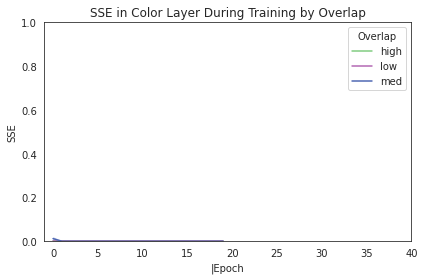

In [36]:
analyses_df = plotSSEbyCat(data_train_stacked, 'train', category_palette, analyses_df)

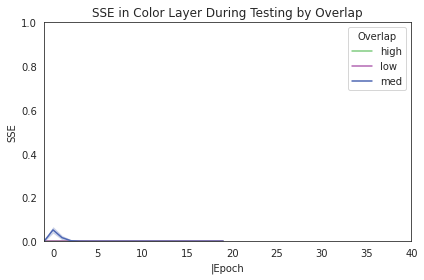

In [37]:
analyses_df = plotSSEbyCat(data_test_stacked, 'test', category_palette, analyses_df)

In [38]:
if study_task_run == 1:
    analyses_df = plotSSE(data_train_stacked, 'TaskColorWOOsc', 'Train', face_palette, analyses_df)

['TaskColorRecall']


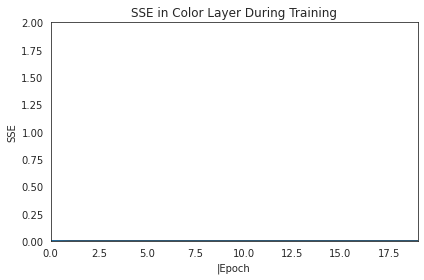

plotting SSE over time took 170.50178146362305 s


In [39]:
analyses_df = plotSSE(data_train_stacked, 'TaskColorRecall', 'Train', face_palette, analyses_df)
print(f"plotting SSE over time took {time.time() - tick} s", flush=True)

## Print checkpoint
<a id='Checkpoint_0:_istheoutputcolorshowncorrectlythroughoutthelearningtask'></a>

### Color Layer


In [40]:
# Checkpoint 0: is the output color shown correctly throughout the learning task
tick = time.time()
if study_task_run == 1 :
    sse = data_train_stacked.loc[idx[:,:,:,'#Output_AvgSSE'],:]
    sse_mean_task = sse.groupby('$CurrentTask').mean()

    baseline_SSE = sse_mean_task.loc['TaskColorWOOsc']
    print(baseline_SSE.mean())

    if baseline_SSE.mean() < .001 :
        checkpoint_TF = True
    else :
        checkpoint_TF = False
    temp = ['color SSE train', checkpoint_TF, baseline_SSE.mean(), 'is the output color shown correctly throughout the learning task - value ']
    temp_series = pd.Series(temp, index = checkpoints_df.columns)
    checkpoints_df = checkpoints_df.append(temp_series, ignore_index = True)


In [41]:
#checkpoint 1 : is the object input correctly shown throughout the learning and recall phase?
## ADD THIS

In [42]:
sse = data_train_stacked.loc[idx[:,:,:,'#Object_AvgSSE'],:]
# sse_mean_task = sse.groupby('$CurrentTask').mean()
sse_mean = sse.mean(axis = 1).mean(axis = 0)
sse_mean 

if sse_mean < .001 :
    checkpoint_TF = True
else :
    checkpoint_TF = False
temp = ['object SSE train', checkpoint_TF, sse_mean, 'is the object input correctly shown throughout the learning and recall phase?']
temp_series = pd.Series(temp, index = checkpoints_df.columns)
checkpoints_df = checkpoints_df.append(temp_series, ignore_index = True)

In [43]:
#checkpoint 2: is the face input correctly shown throughout the learning and recall phase?
## ADD THIS

In [44]:
sse = data_train_stacked.loc[idx[:,:,:,'#Face_AvgSSE'],:]
# sse_mean_task = sse.groupby('$CurrentTask').mean()
sse_mean = sse.mean(axis = 1).mean(axis = 0)
sse_mean 

if sse_mean < .001 :
    checkpoint_TF = True
else :
    checkpoint_TF = False
temp = ['face SSE train', checkpoint_TF, sse_mean, 'is the face input correctly shown throughout the learning and recall phase?']
temp_series = pd.Series(temp, index = checkpoints_df.columns)
checkpoints_df = checkpoints_df.append(temp_series, ignore_index = True)

In [45]:
#checkpoint 3: are the colors learned by the end of the study phase?

In [46]:
if study_task_run == 1 :
    sse = data_test_stacked.loc[idx[:,epoch_end_initial,'TaskColorWOOsc', 'TestColorAll','#Output_AvgSSE'],:]

    final_learning_SSE_per_run = sse.mean(axis = 1)
    final_learning_SSE = final_learning_SSE_per_run.mean()
    print(final_learning_SSE)

    if final_learning_SSE < .015 :
        checkpoint_TF = True
    else :
        checkpoint_TF = False
    temp = ['color learned at baseline', checkpoint_TF, final_learning_SSE, 'are the colors learned by the end of the study phase?']
    temp_series = pd.Series(temp, index = checkpoints_df.columns)
    checkpoints_df = checkpoints_df.append(temp_series, ignore_index=True)

    checkpoints_df
print(f"printing checkpoint took {time.time() - tick} s", flush=True)

printing checkpoint took 0.6915707588195801 s


### Visualize the output layer at each epoch
<a id='Visualizetheoutputlayerateachepoch'></a>

visualizing the output at each epoch
------------------


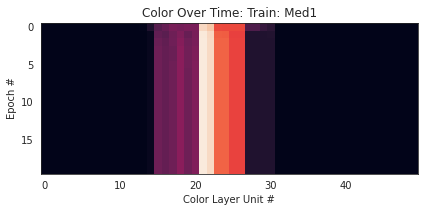

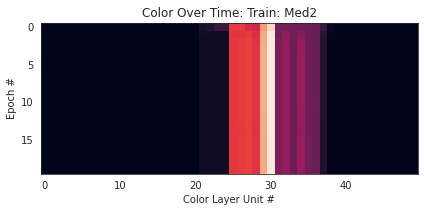

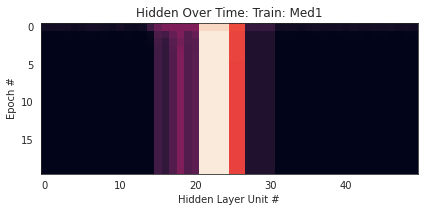

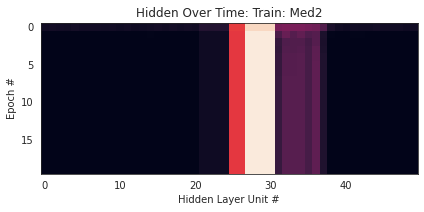

------------------


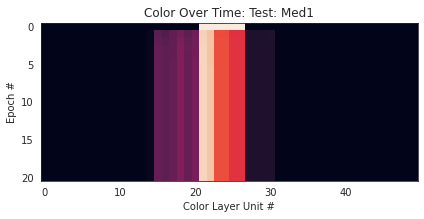

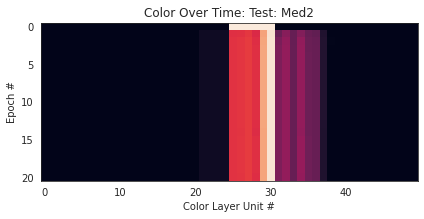

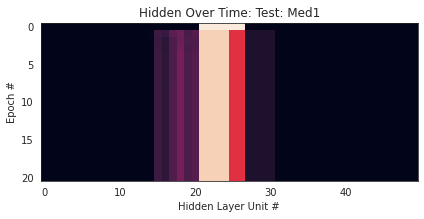

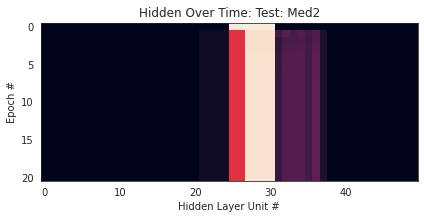

------------------


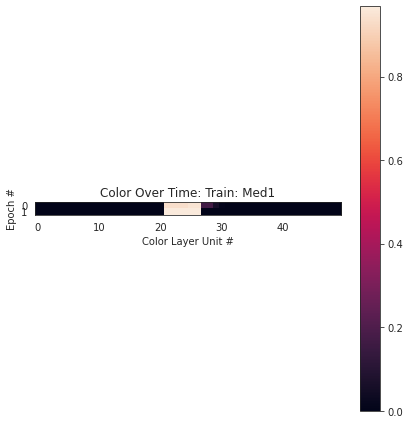

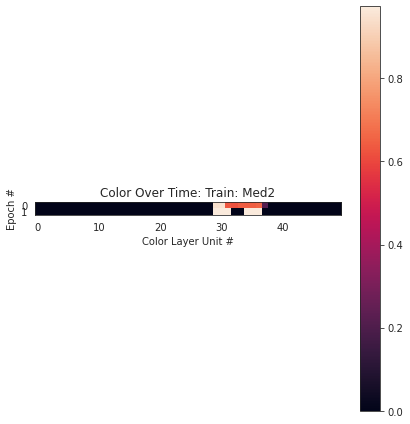

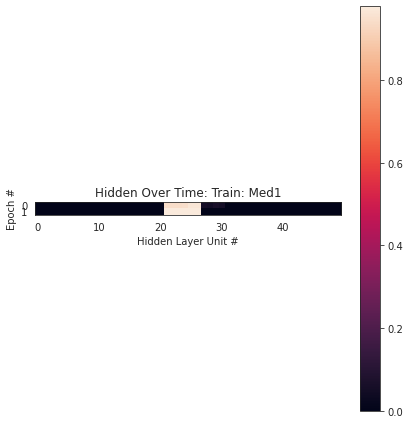

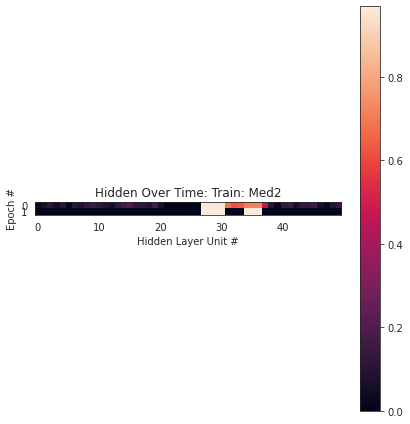

------------------


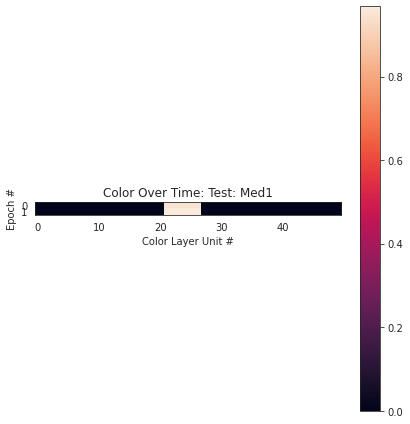

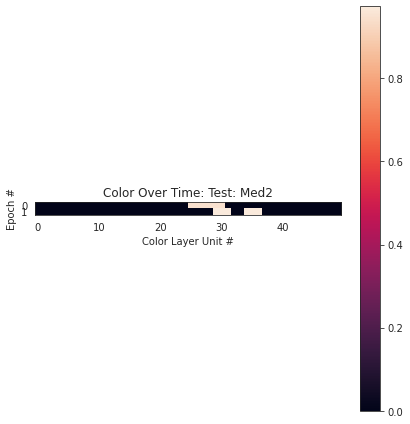

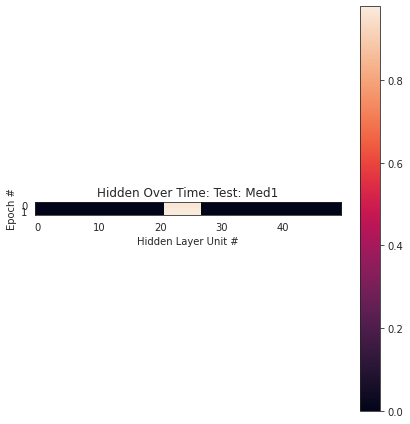

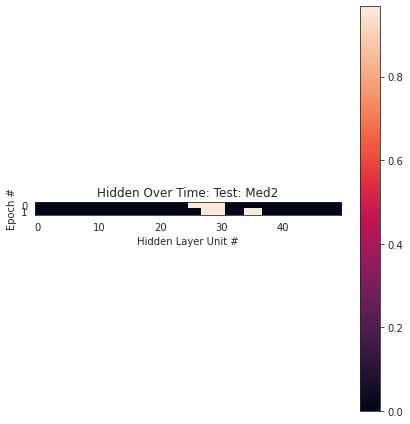

------------------


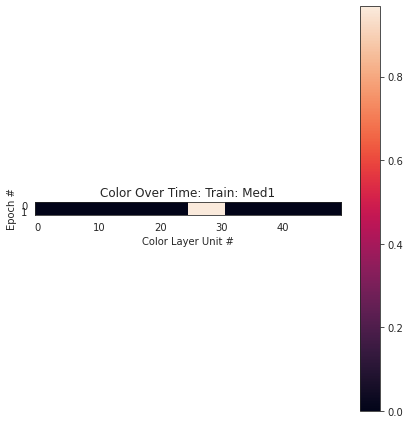

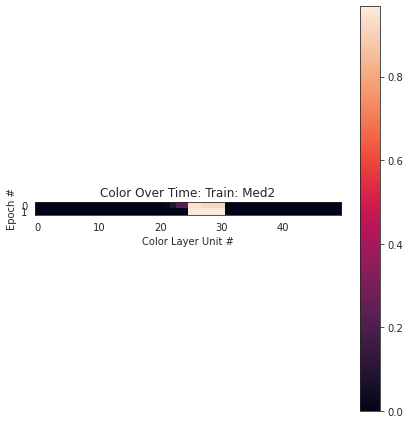

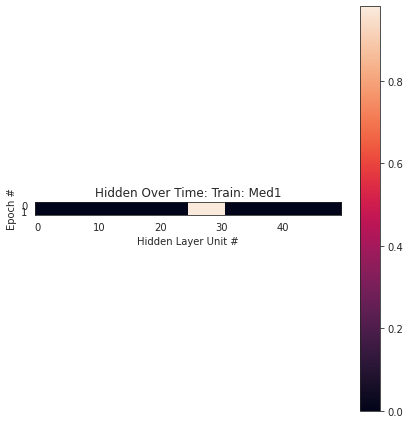

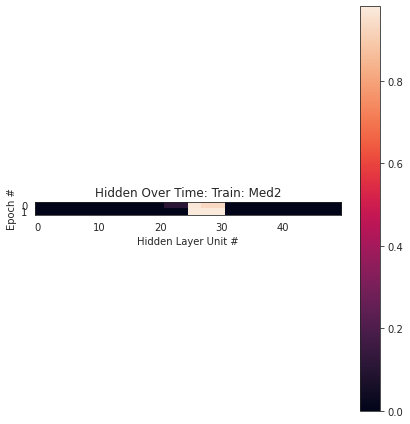

------------------


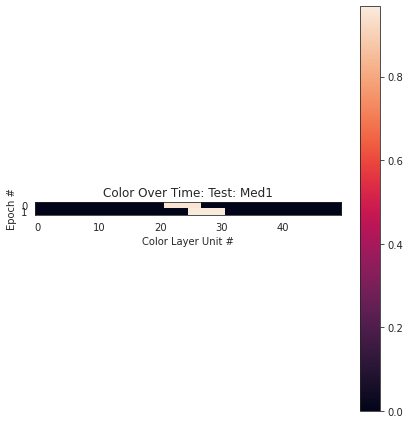

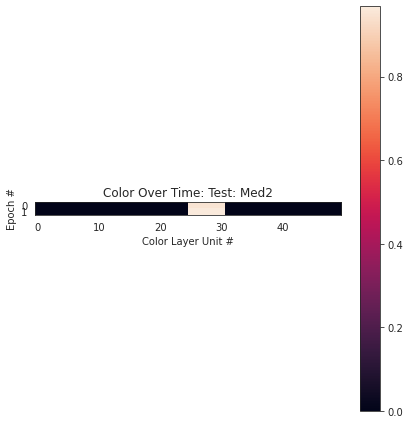

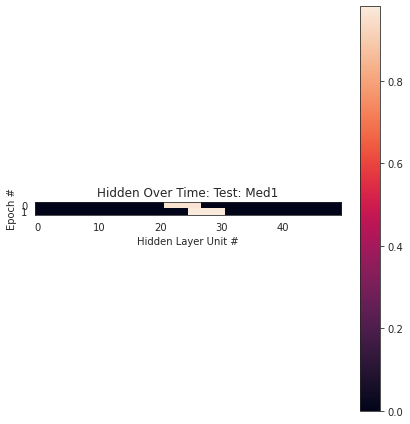

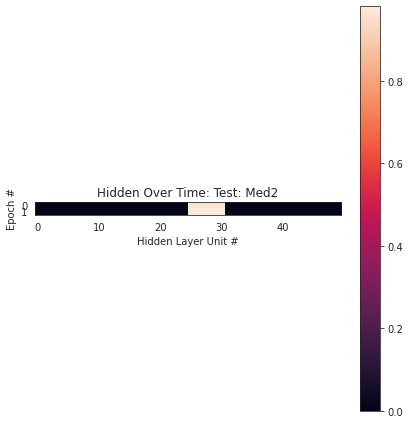

------------------


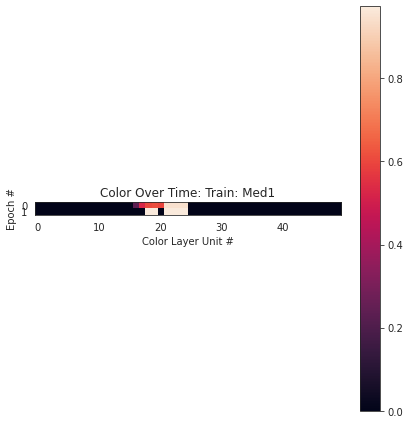

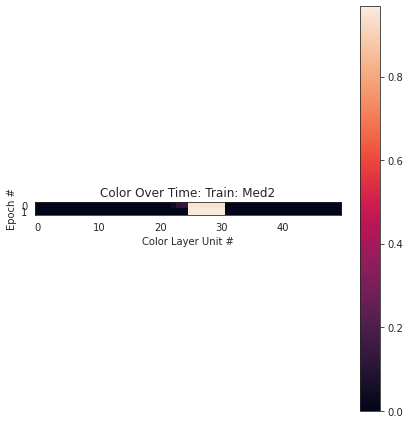

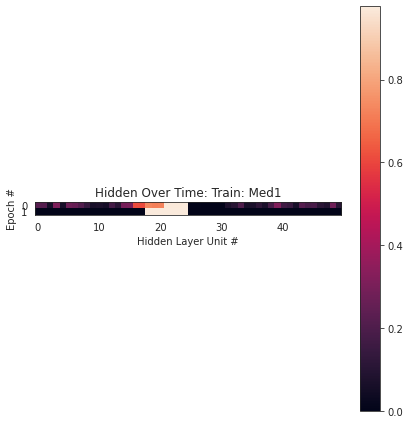

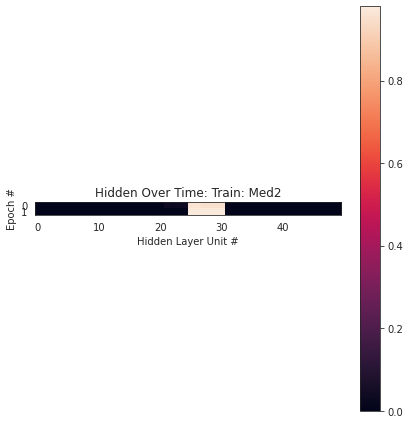

------------------


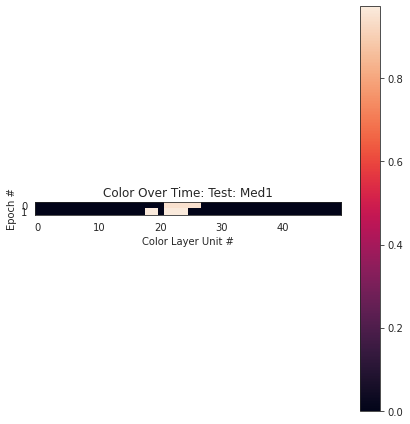

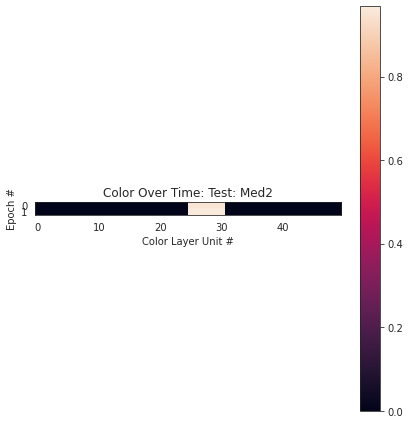

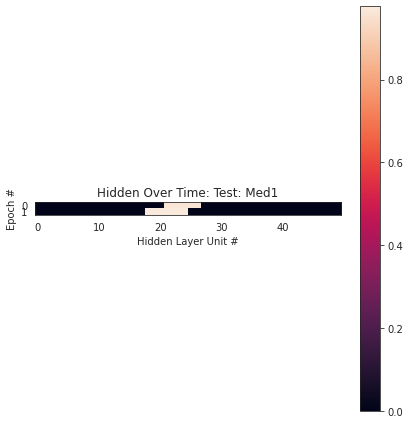

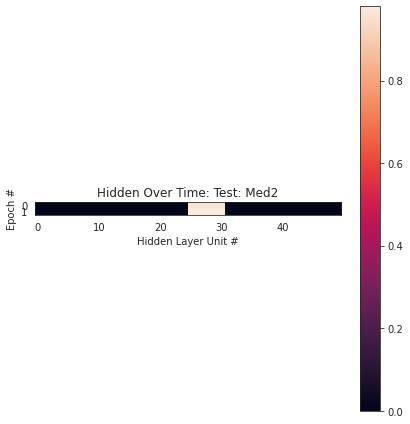

------------------


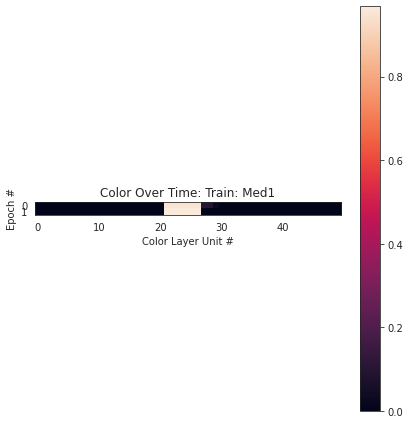

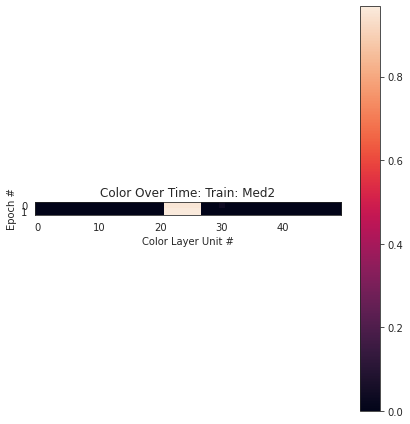

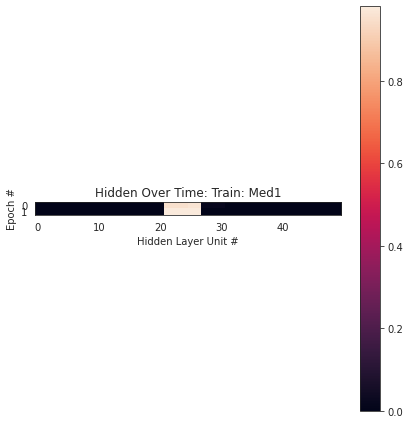

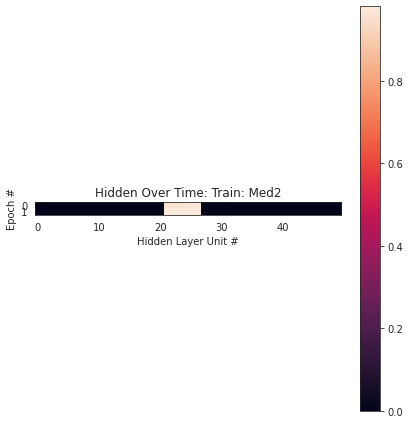

------------------


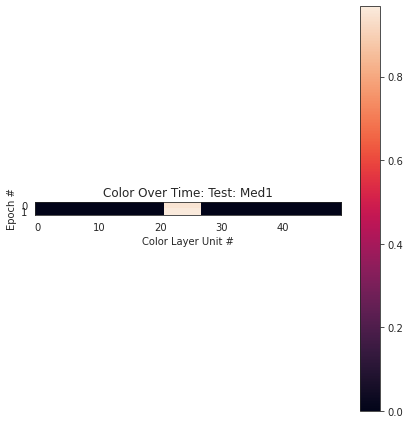

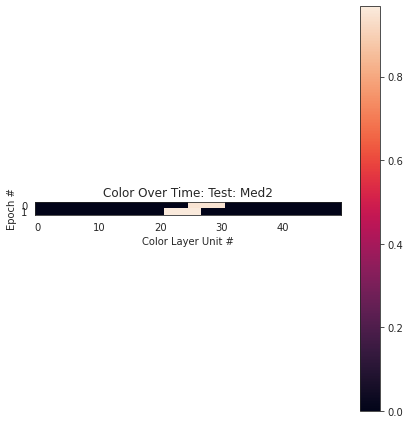

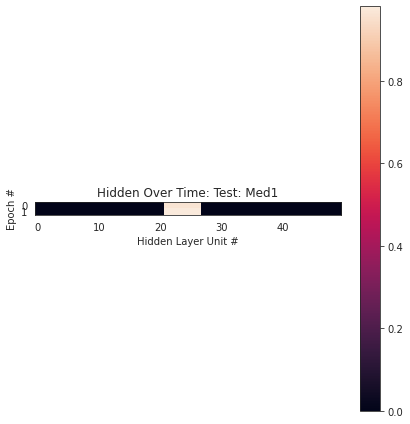

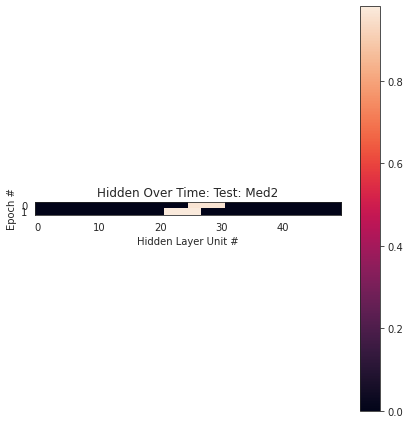

------------------


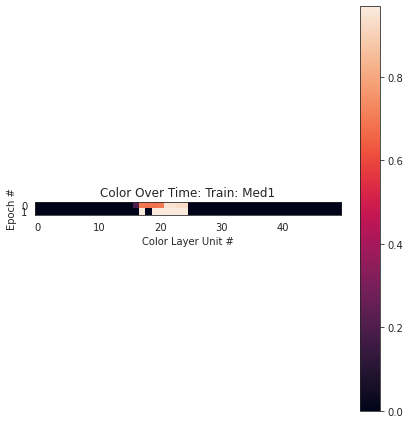

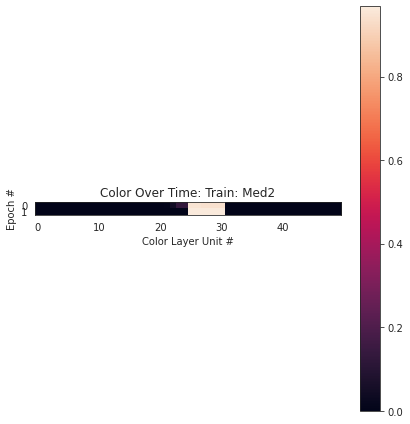

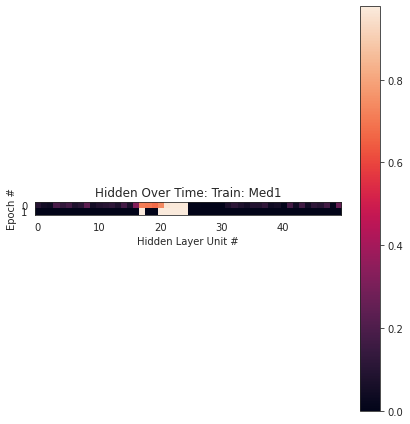

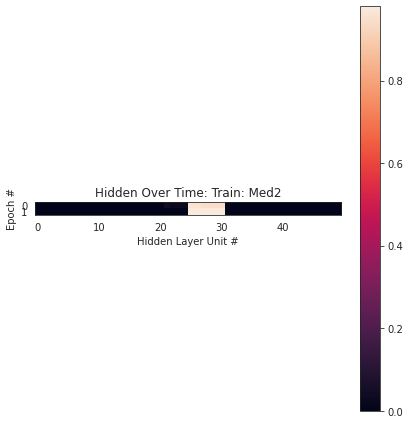

------------------


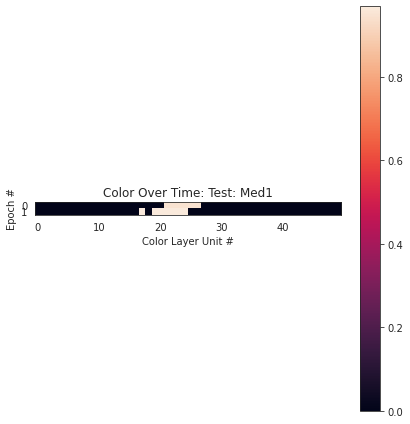

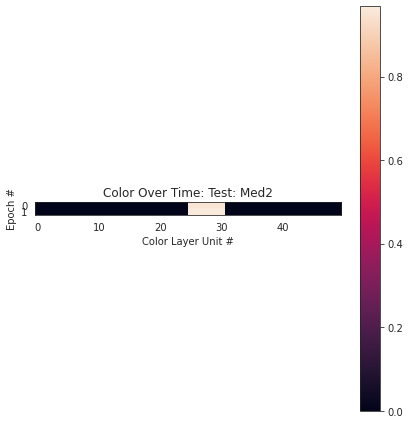

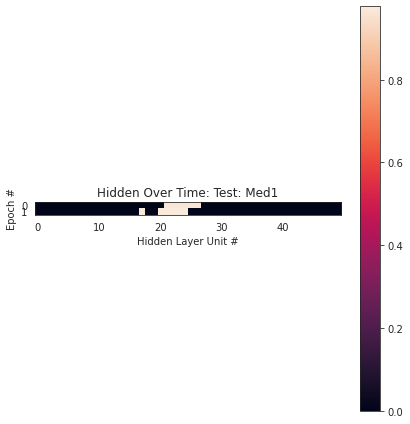

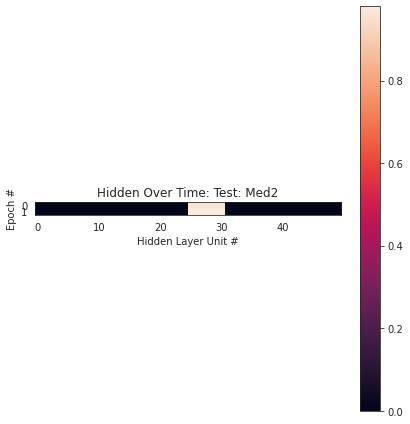

------------------


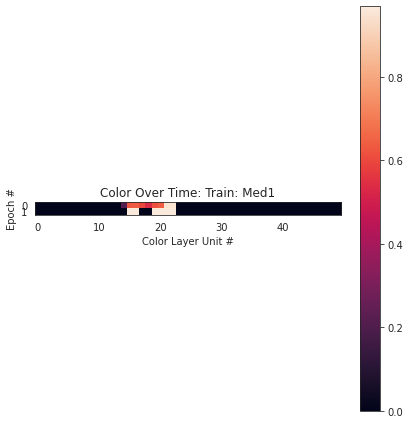

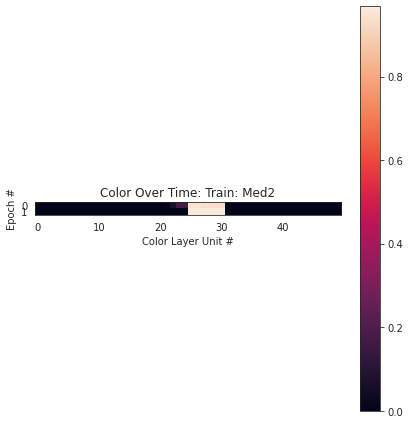

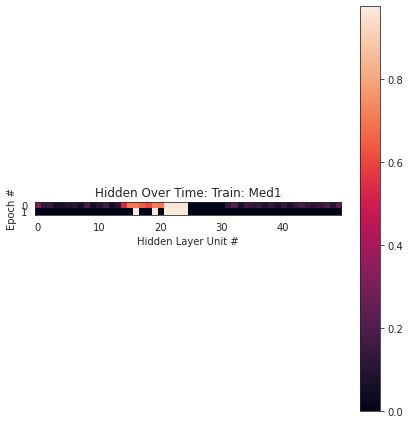

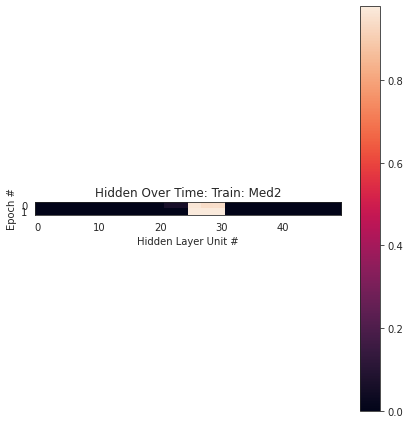

------------------


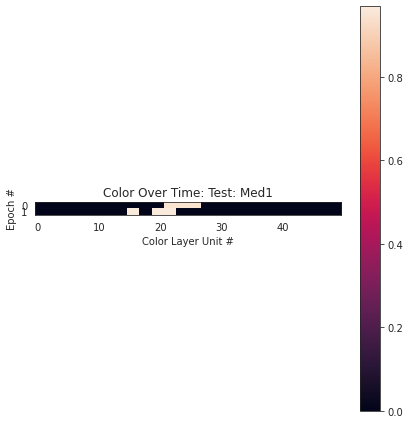

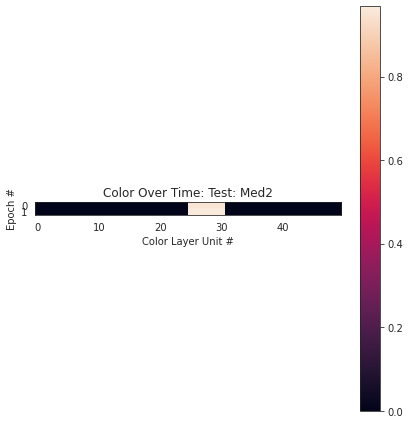

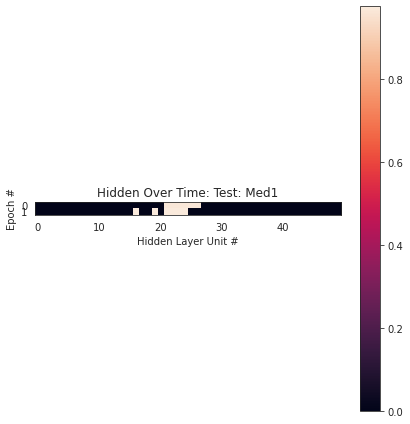

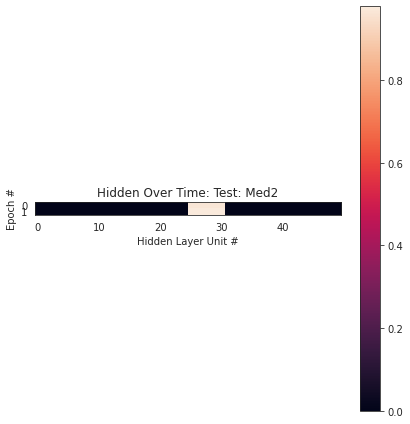

------------------


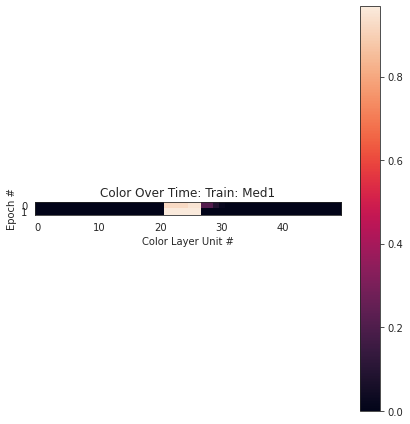

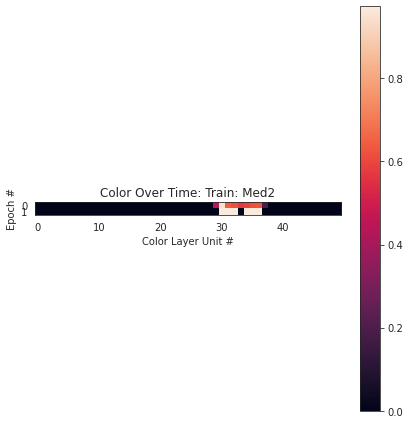

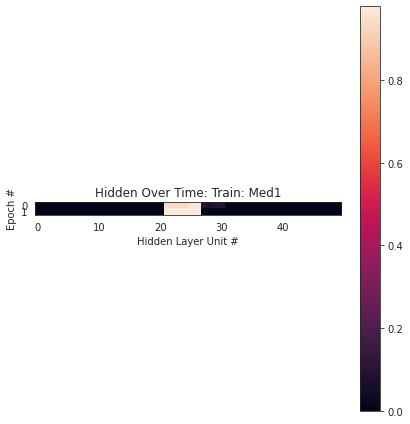

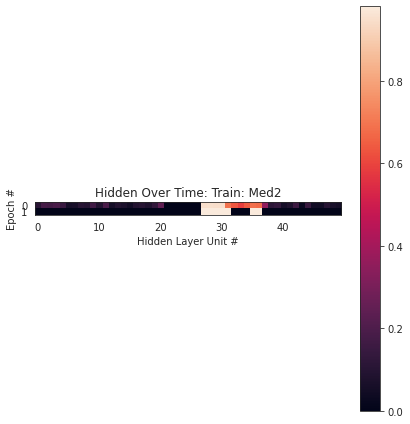

------------------


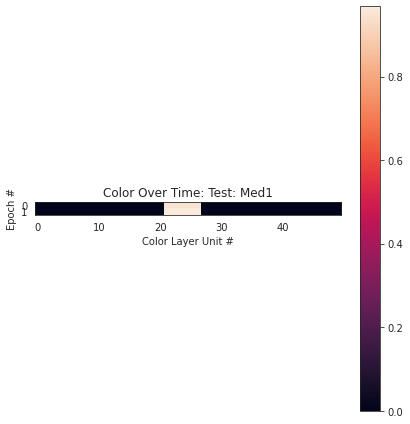

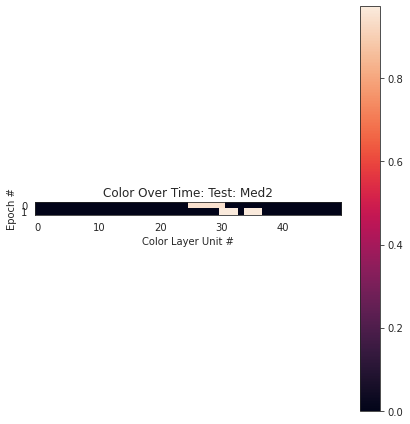

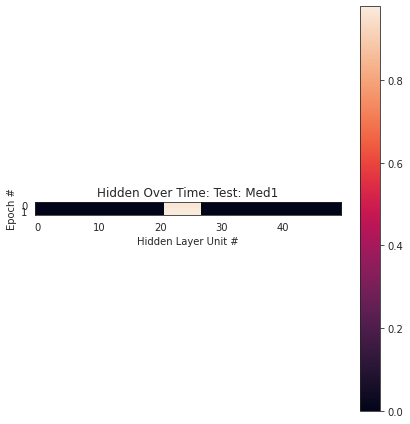

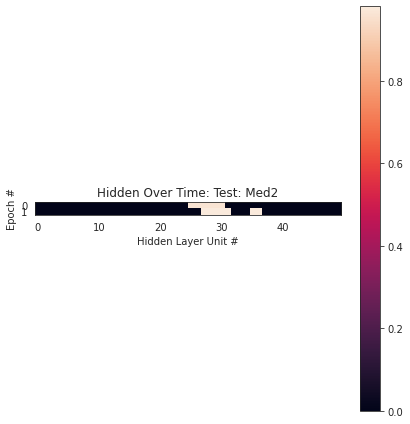

------------------


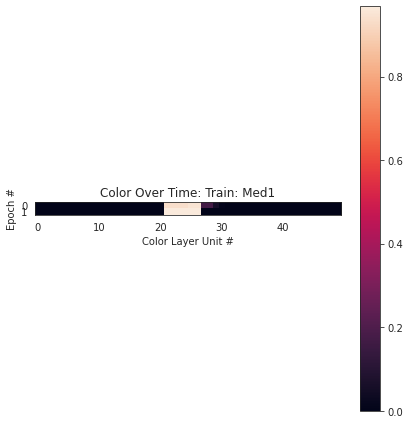

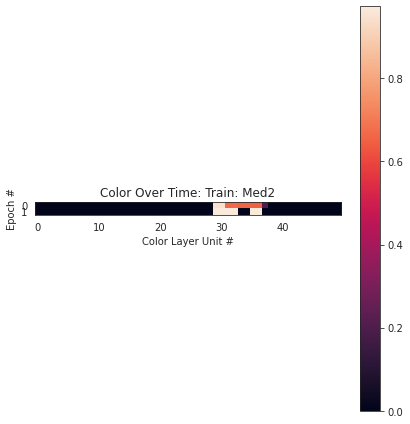

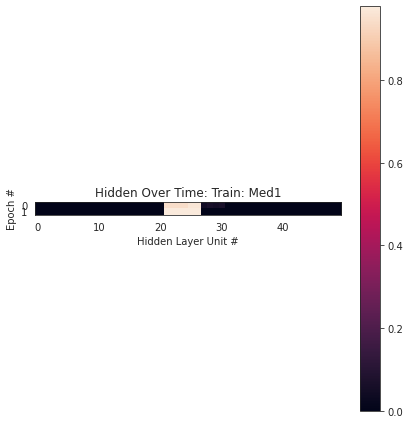

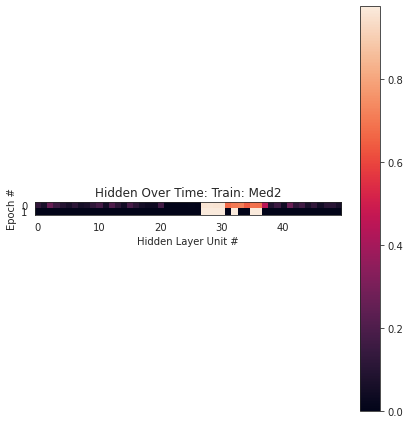

------------------


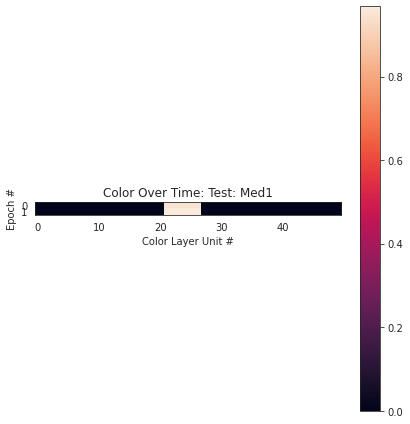

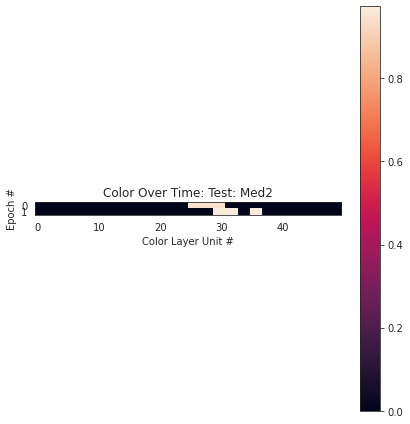

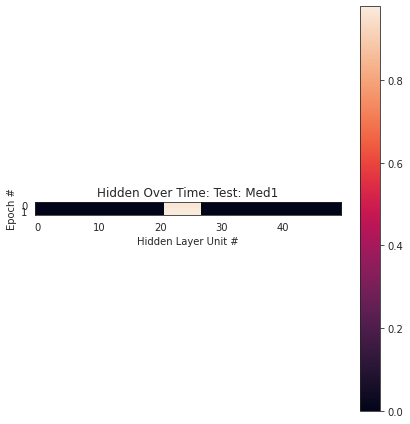

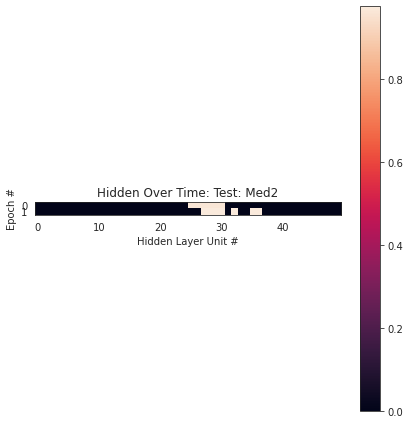

------------------


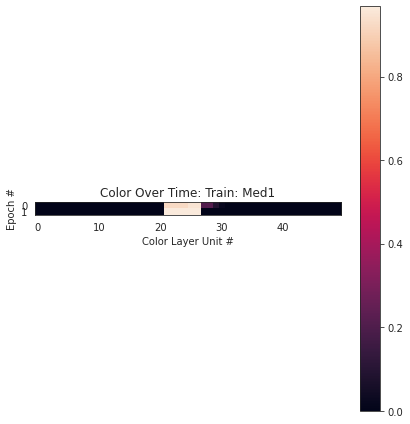

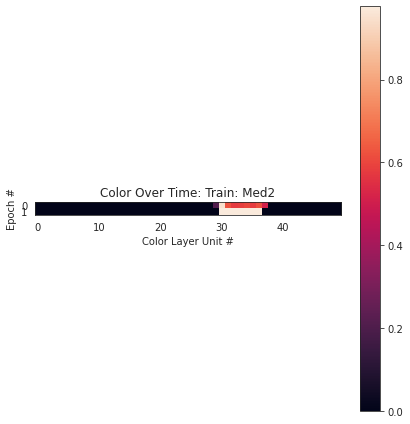

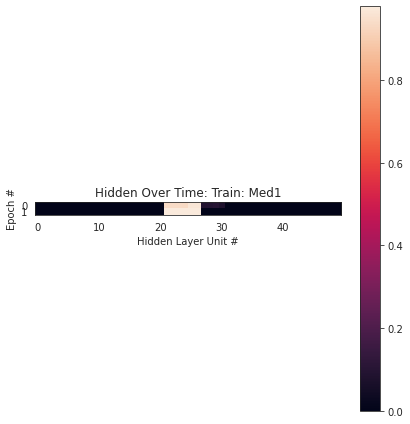

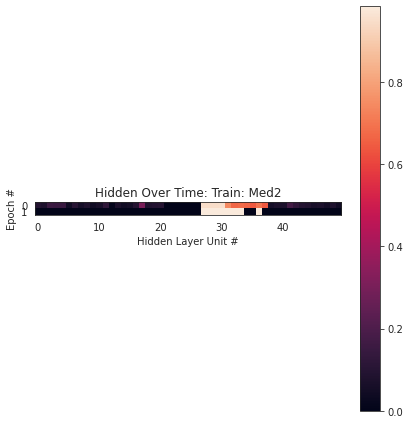

------------------


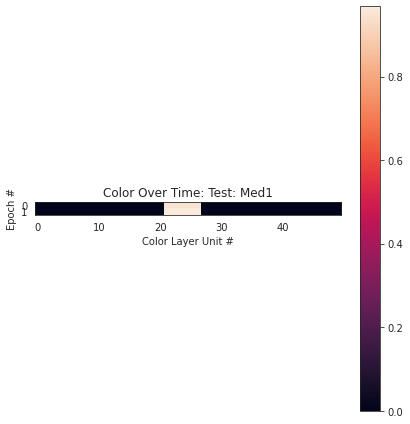

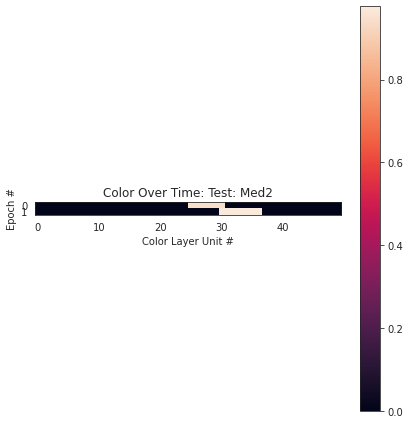

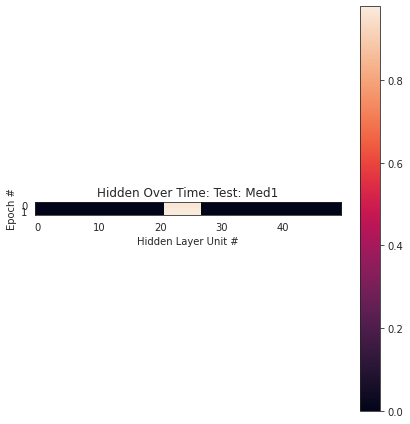

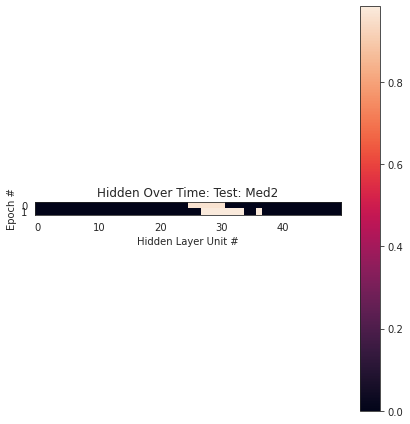

------------------


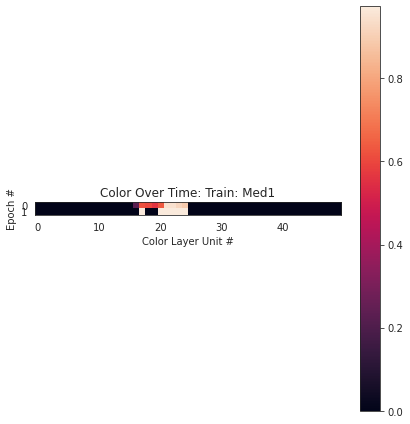

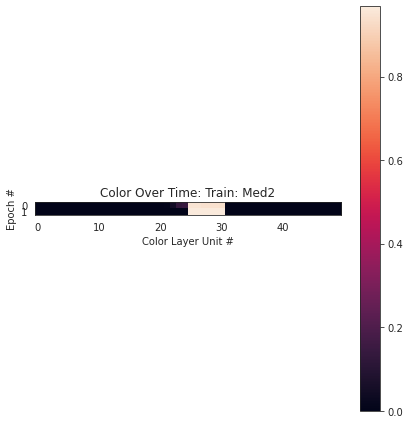

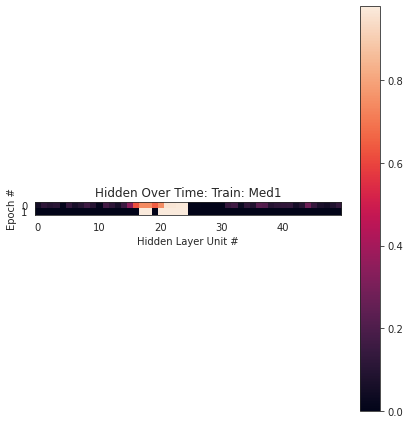

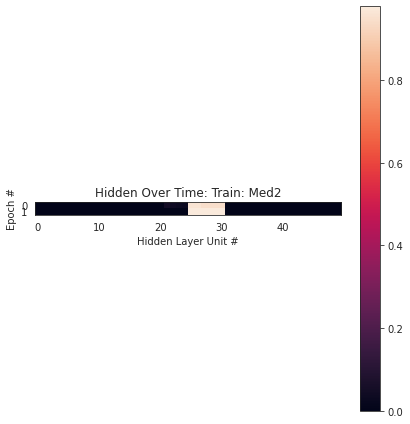

------------------


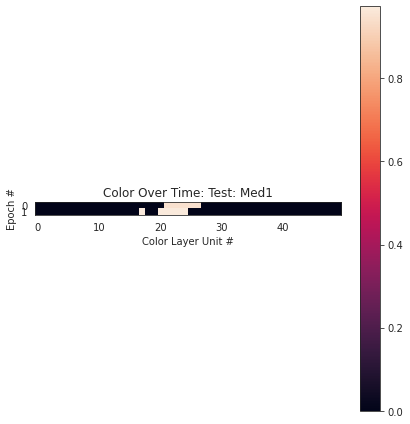

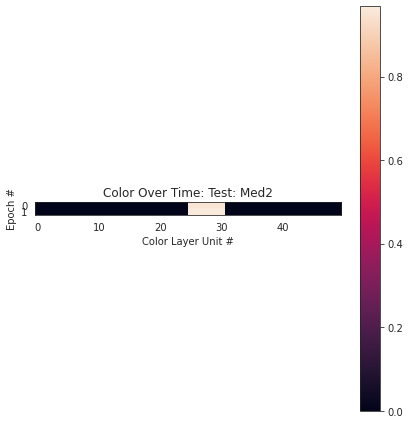

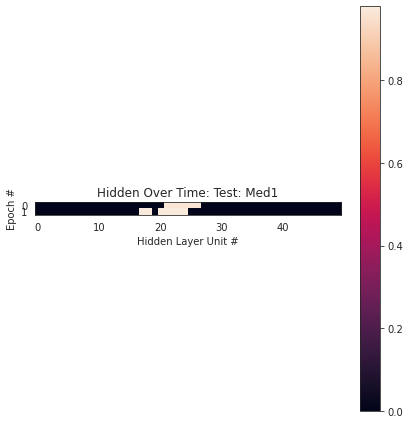

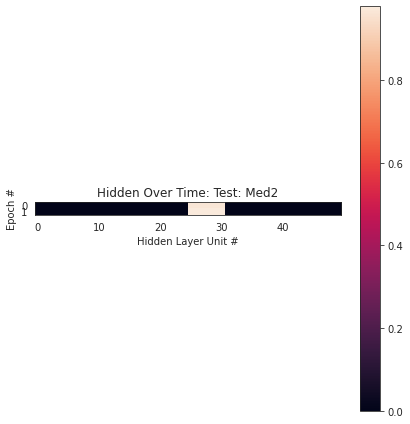

In [47]:

print('visualizing the output at each epoch',flush=True)
tick = time.time()
def prep_output_color_test(data, name, test_or_train, filter_colM, run) : 
    #run can be 'all' or a specific integer for a run to look at. 
    
    if name == 'TestColorAll' :
        data = data.loc[(slice(None), slice(None), slice(None), name, filter_colM),:]
    elif name == 'TaskColorRecall' :


        data = data.loc[(slice(None), slice(None), name, filter_colM),:]


    data = data.reset_index()

    if (run == 'all') :

        data = data.groupby(['|Epoch', 'key']).mean().drop(['|Run'], axis = 1).stack().unstack('key')

    else : ## specific run

        data = data[data['|Run'] == run]
        data = data.drop(columns= ['|Run', '$CurrentTask', test_or_train])
        data = data.set_index(['|Epoch', 'key']).stack().unstack(level = 'key')

    data = data[filter_colM] #put columns back in the correct order

    return data


# # plot the output layer at test
# for stim in stim_names :
#     data = prep_output_color_test(data_test_stacked, 'TestColorAll', '$CurrentTest', filter_colM, 'all')
#     plt.figure(figsize=(6,6))
#     plt.imshow(data.loc[(slice(None), stim),:])
#     title = 'Color Representation Over Time: ' + stim.capitalize()
#     plt.title(title)
#     plt.ylabel('Epoch #')
#     plt.xlabel('Color Layer Unit #')
#     plt.tight_layout()
#     plt.savefig(results_fig_dir + title + '.png', bbox_inches = "tight")
#     if from_cmdLine != 'cmd' :
#         plt.show()
#     analyses_df = add_analysis_to_analyses_df(analyses_df, title, True)



# for stim in stim_names :
#     data = prep_output_color_test(data_train_stacked, 'TaskColorRecall', '$CurrentTask', filter_colM, 'all')
#     plt.figure(figsize=(6,6))
#     plt.imshow(data.loc[(slice(None), stim),:])
#     title = 'Color Representation Over Time: ' + stim.capitalize()
#     plt.title(title)
#     plt.ylabel('Epoch #')
#     plt.xlabel('Color Layer Unit #')
#     plt.tight_layout()
#     plt.savefig(results_fig_dir + title + '.png', bbox_inches = "tight")
#     if from_cmdLine != 'cmd' :
#         plt.show()
#     analyses_df = add_analysis_to_analyses_df(analyses_df, title, True)

filter_HiddM
filter_col_AvgSLrn
# plot the output layer at train


def plot_visual_layer(runN, analyses_df, all_epochs = True):

    for type_run in ['Train', 'Test'] :
        print('------------------')
        if type_run == 'Test' :
            data_t= data_test_stacked

            name = 'TestColorAll'
            test_or_train = '$CurrentTest'
        elif type_run == 'Train' :
            data_t = data_train_stacked
            if task_run !='just_face' :
                name = 'TaskColorRecall'
            else:
                name = 'TaskFaceRecall'
            test_or_train = '$CurrentTask'

        for layer in ['Color', 'Hidden'] : 
            if layer == 'Color' :
                if type_run == 'Train' :
                    units = filter_colP
                else:
                    units = filter_colM
            elif layer == 'Hidden' :
                if type_run == 'Train' :
                    units = filter_HiddenP
                else:
                    units = filter_HiddM

            for stim in stim_names :
                data = prep_output_color_test(data_t, name, test_or_train, units, runN)
                plt.figure(figsize=(6,6))
                plt.clf()
                


                if all_epochs==False:
                    min_epoch = data.reset_index()['|Epoch'].min()
                    max_epoch = data.reset_index()['|Epoch'].max()

                    plt.imshow(data.loc[([min_epoch,max_epoch], stim),:])
                    plt.colorbar()

                if all_epochs==True:
                    plt.imshow(data.loc[(slice(None), stim),:])
                title = layer + ' Over Time: ' + type_run + ': ' + stim.capitalize()
                plt.title(title)
                plt.ylabel('Epoch #')
                plt.xlabel(layer + ' Layer Unit #')
                plt.tight_layout()


                if all_epochs ==True:

                    plt.savefig(results_fig_dir + title + '.pdf', bbox_inches = "tight")
                else:
                    plt.savefig(eps_dir + 'run '+ str(runN) + title + '.eps', bbox_inches = "tight")

                if from_cmdLine != 'cmd' :
                    plt.show()
                analyses_df = add_analysis_to_analyses_df(analyses_df, title, True)

                if layer == 'Hidden' :
                    if type_run == 'Test':
                        data2 = data
                            
                    
                plt.close()
    
# for the following, set runN to be 'all' in the default version.
# but to set it to see for a specific run, enter that run (i.e. plot_visual_layer(1))

plot_visual_layer('all', analyses_df, all_epochs = True)

if nruns < 10:
    num_runs_to_save_act = nruns
    
else:
    num_runs_to_save_act = 10

for r in range(num_runs_to_save_act):
    plot_visual_layer(r, analyses_df, all_epochs = False)






In [48]:
print(f"visualizing color output at each epoch took {time.time() - tick} s", flush=True)

visualizing color output at each epoch took 266.2335247993469 s


# Correlation Analysis
<a id='Correlation_AnalysisFirstsetupcorrelationmatricesforfinalepochineachtask'></a>

## First set up correlation matrices for final epoch in each task


In [49]:

hiddenData = data_test_stacked.loc[(slice(None), slice(None), slice(None),slice(None),slice(hiddenM_Start, hiddenM_End)),:]

outputData = data_test_stacked.loc[(slice(None),  slice(None), slice(None),slice(None), slice(outputM_Start, outputM_End)),:]


## Plot Within Pair Correlation Over Time
<a id='Plot_Within_Pair_Correlation_Over_Time'></a>

In [50]:
def make_corr_long(dataframe, LayerType, testType, numPairs) :

    df = dataframe.loc[(slice(None),  slice(None), slice(None),slice(testType), slice(None)),:]
    df_corr = df.groupby(['|Run','|Epoch','$CurrentTask', '$CurrentTest']).corr()

        
    df_corr.index.names = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', 'firstItem']
    df_corr_long = pd.DataFrame(df_corr.stack())
    df_corr_long.head()
    df_corr_long.index.names = ['|Run', '|Epoch', '$CurrentTask','$CurrentTest', 'firstItem', 'secondItem']
    df_corr_long = df_corr_long.rename(columns = {0: 'correlation'})
    df_corr_long = df_corr_long.reset_index()
    df_corr_long['pair'] = df_corr_long[['firstItem', 'secondItem']].apply(lambda x: '-'.join(x), axis = 1)

    df_corr_long


    if (numPairs ==2) :
        pairtypeDict = {'small1-small1': 'identity', 
                   'small1-small2': 'within',
                   'small1-small3': 'across',
                   'small1-small4': 'across',
                   'small2-small1': 'redundant',
                   'small2-small2': 'identity',
                   'small2-small3': 'across',
                   'small2-small4': 'across',
                   'small3-small1': 'redundant',
                   'small3-small2': 'redundant',
                   'small3-small3': 'identity',
                   'small3-small4': 'within',
                   'small4-small1': 'redundant',
                   'small4-small2': 'redundant',
                   'small4-small3': 'redundant',
                   'small4-small4': 'identity'}
        
    elif (numPairs == 3) :
        pairtypeDict = {'low1-low1': 'identity',
                       'low1-low2': 'low1-low2',
                       'low1-med1': 'across', 
                       'low1-med2': 'across',
                       'low1-high1': 'across',
                       'low1-high2': 'across',
                       'low2-low1': 'redundant',
                       'low2-low2': 'identity',
                       'low2-med1': 'across',
                       'low2-med2': 'across',
                       'low2-high1': 'across',
                       'low2-high2': 'across',
                        'med1-low1': 'redundant',
                        'med1-low2': 'redundant',
                        'med1-med1': 'identity',
                        'med1-med2': 'med1-med2',
                        'med1-high1': 'across',
                        'med1-high2': 'across',
                        'med2-low1': 'redundant',
                        'med2-low2': 'redundant',
                        'med2-med1': 'redundant',
                        'med2-med2': 'identity',
                        'med2-high1': 'across',
                        'med2-high2': 'across',
                        'high1-low1': 'redundant',
                        'high1-low2': 'redundant',
                        'high1-med1': 'redundant',
                        'high1-med2': 'redundant',
                        'high1-high1': 'identity',
                        'high1-high2': 'high1-high2',
                        'high2-low1': 'redundant',
                        'high2-low2': 'redundant',
                        'high2-med1': 'redundant',
                        'high2-med2': 'redundant',
                        'high2-high1': 'redundant',
                        'high2-high2': 'identity',
                       }


    df_corr_long['pair_type'] = df_corr_long['pair'].map(pairtypeDict)
    return df_corr_long



In [51]:
def plot_correlation_over_time(dataframe, LayerType, testType, numPairs, analyses_df) :
    #dataframe_corr is either outputData_corr_long or hiddenData_corr_long. 
    #layer type is for the plot title - hidden or color.
    #testType is TestColorAll or TestFaceAll
    
    title = 'Pair Correlation (' + LayerType + ' Layer)'
    try:
        plt.clf()
        plt.figure(figsize=(10,10))
        if (numPairs == 2) :
            df_corr_long_plot = dataframe[dataframe['pair_type'].isin(['within', 'across'])]
        elif (numPairs == 3) :
            df_corr_long_plot = dataframe[dataframe['pair_type'].isin(['low1-low2','med1-med2', 'high1-high2', 'across'])]
        #plot!
        
        sns.set_palette("husl", 2)

        g = sns.lineplot(x="|Epoch", y="correlation",
        hue="pair_type", palette = correl_palette, 
                 data=df_corr_long_plot)
            
        if study_task_run == 1 :
            g = sns.lineplot(x="|Epoch", y="correlation",
                    hue="pair_type",  style = "$CurrentTask", palette = correl_palette, 
                             data=df_corr_long_plot)
        elif study_task_run == 0 : 
            g = sns.lineplot(x="|Epoch", y="correlation",
            hue="pair_type", palette = correl_palette, 
                 data=df_corr_long_plot)

#         print(df_corr_long_plot.head())
        g.set_xlabel('Time (Epoch #)')
        g.set_ylim(-1, 1.1)
        plt.title(title)
        g.axhline(0, ls='-', color = 'gray')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png', bbox_inches = "tight")
        if from_cmdLine != 'cmd' :
            plt.show()

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
    return analyses_df
        
    
    




In [52]:
def plot_final_correlation_over_time(dataframe, LayerType, analyses_df) :
    title = 'final within pair correlation by type : ' + LayerType + ' Layer'
    try:
        plt.clf()
        temp = dataframe[dataframe['pair_type'].isin(['med1-med2', 'low1-low2','high1-high2'])]
        final_corr = temp[temp['|Epoch'] == max_final_epoch]
    #     sns.swarmplot(x = 'pair_type', y = 'correlation', data=final_corr)
        sns.boxplot(x = 'pair_type', y = 'correlation', order = ['low1-low2', 'med1-med2', 'high1-high2'],
                    palette = correl_palette, data=final_corr)
        plt.ylim(-1.1,1.1)
        plt.axhline(0, ls='-', color = 'gray')
        plt.title(title)
        if from_cmdLine != 'cmd' :
            plt.show()


        sns.swarmplot(x = 'pair_type', y = 'correlation',  order = ['low1-low2', 'med1-med2', 'high1-high2'], 
                       palette = correl_palette, data=final_corr)
        plt.ylim(-1.1,1.1)
        plt.axhline(0, ls='-', color = 'gray')
        title = 'final within pair correlation by type : ' + LayerType + ' Layer'
        plt.title(title)
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png')
        if from_cmdLine != 'cmd' :
            plt.show()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
        return final_corr, analyses_df
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        return "error", analyses_df
    
    
    # sns.swarm(x=)



In [53]:
def analyze_within_pair_correlation(final_corr_df) :
    ##################

    mod = ols('correlation ~ C(pair_type)', data = final_corr_df).fit()
    print(mod.summary())

    print('-------------------')
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print('HERE')
    print(aov_table)

    print('\n\n\n -------------------\n')
    print("IS THERE A SIGNIFICANT DIFFERENCE BETWEEN GROUPS? \n\n")
    if aov_table.iloc[0]['PR(>F)'] < .05 :
        print('yes, p = ' + str(aov_table.iloc[0]['PR(>F)']) +'\n')

        mc = MultiComparison(final_corr_df['correlation'], final_corr_df['pair_type'])
        mc_results = mc.tukeyhsd()
        print(mc_results)
        group_diff = True
    else :
        print('no')
        group_diff = False


    #########
    print('\n\n ARE THE MEAN WITHIN PAIR CORRELATIONS IN TH ORDER MED < LOW < HIGH? \n\n')
    corr_mean = final_corr_df.groupby('pair_type').mean()

    if corr_mean.loc['med1-med2', 'correlation'] < corr_mean.loc['low1-low2', 'correlation'] and corr_mean.loc['low1-low2', 'correlation'] < corr_mean.loc['high1-high2', 'correlation']:
        print('yes\n')
        group_order = True
    else: 
        print('no\n')
        sortedmeans = corr_mean.sort_values(by=['correlation']).index.get_level_values(0)
        print(list(sortedmeans))
        group_order = False


    #########

    high_corr = final_corr_df[final_corr_df['pair_type'] == 'high1-high2']['correlation']
    low_corr = final_corr_df[final_corr_df['pair_type'] == 'low1-low2']['correlation']
    med_corr = final_corr_df[final_corr_df['pair_type'] == 'med1-med2']['correlation']

    if med_corr.mean() < 0 :
        print('\n\n IS MEDIUM PAIR WITHIN CORRELATION SIGNIFICANTLY BELOW 0?')
        result = stats.ttest_1samp(med_corr, 0)
        print('t : ' + str(result[0]) + 'p : ' + str(result[1]))
        if result[1] < .05 :
            print('yes')

        else :
            print('no')


    if high_corr.mean() >0 :
        print('\n\n IS HIGH PAIR WITHIN CORRELATION SIGNIFICANTLY ABOVE 0?')
        result = stats.ttest_1samp(high_corr, 0)
        print('t : ' + str(result[0]) + 'p : ' + str(result[1]))
        if result[1] < .05 :
            print('yes')

        else :
            print('no')

    return mod, group_diff, group_order


In [54]:
def plot_correlation_comparison(dataframe, LayerType, analyses_df) :
    try:
        plt.clf()
        temp = dataframe[dataframe['pair_type'].isin(['med1-med2', 'low1-low2','high1-high2'])]
        final_corr = temp[temp['|Epoch'].isin([epoch_end_initial, max_final_epoch])]
        g = sns.FacetGrid(final_corr, col = "pair_type", hue = '|Run', col_order = ['low1-low2', 'med1-med2', 'high1-high2'])
        g.map(sns.pointplot, "|Epoch", "correlation", color="xkcd:plum", alpha = .5);

        title = 'correlation before and after: ' + LayerType + ' Layer'
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle(title.title()) # can also get the figure from plt.gcf()
        axes = g.axes.flatten()
        axes[0].set_title("Low")
        axes[1].set_title("Medium")
        axes[2].set_title("High")
        g.set(ylim=(-1.1, 1.1))

        for col in range(numPairs) :
            g.axes[0][col].axhline(y = 0, color='black', ls='--', linewidth=2, alpha=.7)
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png')

        if from_cmdLine != 'cmd' :
            plt.show()
            
        plt.clf()
        g = sns.FacetGrid(final_corr, col = "pair_type", col_order = ['low1-low2', 'med1-med2', 'high1-high2'])
        g.map(sns.pointplot, "|Epoch", "correlation", color="xkcd:plum");

        title = 'correlation before and after Ave: ' + LayerType + ' Layer'
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle(title.title()) # can also get the figure from plt.gcf()
        axes = g.axes.flatten()
        axes[0].set_title("Low")
        axes[1].set_title("Medium")
        axes[2].set_title("High")
        g.set(ylim=(-1.1, 1.1))

        for col in range(numPairs) :
            g.axes[0][col].axhline(y = 0, color='black', ls='--', linewidth=2, alpha=.7)
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png')
        if from_cmdLine != 'cmd' :
            plt.show()

    #     sns.violinplot(x = 'pair_type', y = 'correlation',  order = ['low1-low2', 'med1-med2', 'high1-high2'], 
    #         hue = '|Epoch', data=final_corr)
#         if from_cmdLine != 'cmd' :
#             plt.show()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
        return final_corr, analyses_df
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        return "error", analyses_df
    
    



### Output Layer: Is the low/med/high within pair correlation in the right order in the color layer?

<a id='is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_color_layer?'></a>

In [55]:
output_corr_long = make_corr_long(outputData, 'Color', 'TestColorAll', numPairs)

<Figure size 432x288 with 0 Axes>

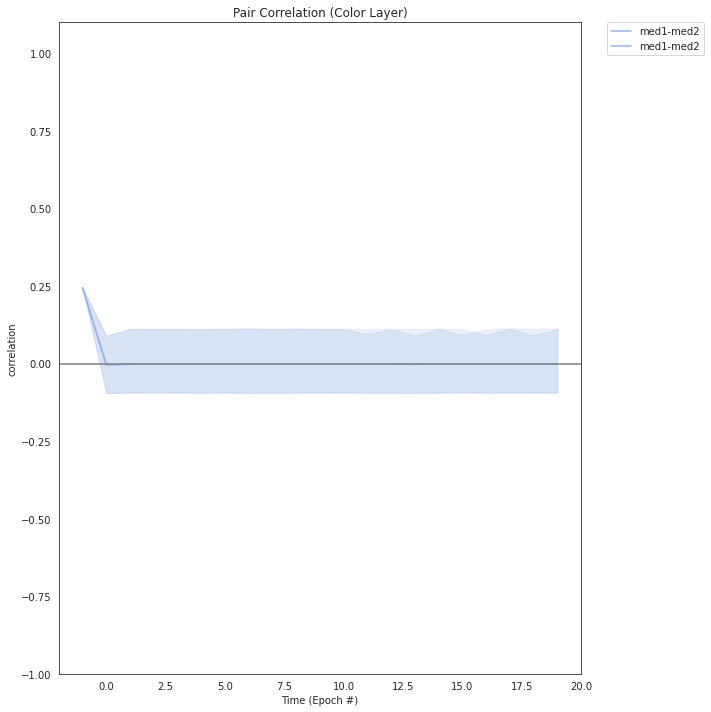

In [56]:
analyses_df = plot_correlation_over_time(output_corr_long, 'Color', 'TestColorAll', numPairs, analyses_df)




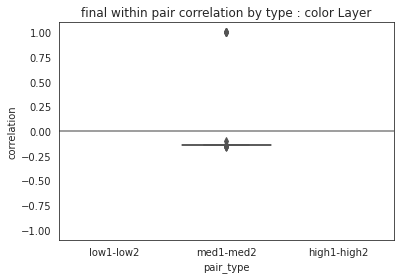

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 52.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


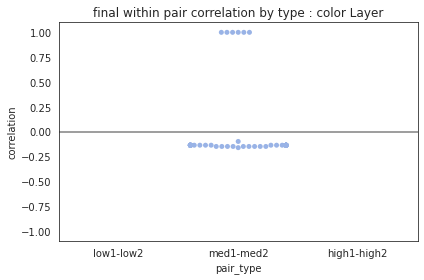

In [57]:

output_just_main_corr, analyses_df = plot_final_correlation_over_time(output_corr_long, 'color', analyses_df) 

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

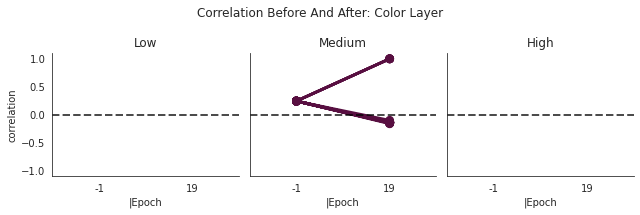

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

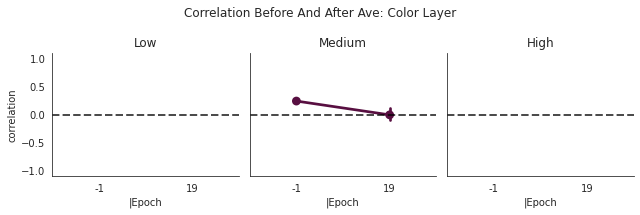

In [58]:

output_just_main_corr, analyses_df = plot_correlation_comparison(output_corr_long, 'color', analyses_df) 


In [59]:
## Use try except block to not break the script if there's an error
## This is useful for the Post_analyses.py where sometimes we run test parameter searches 

title = "is the low/med/high within pair correlation in the right order in the color layer?"
try:

    print('-------------------')
    
    if study_task_run == 1 :
        aov_table = sm.stats.anova_lm(mod, typ=2)

        mod, group_diff, group_order = analyze_within_pair_correlation(output_just_main_corr)

        ## is the model significant? i.e. is low / med / high different?
        temp = ['Color w_corr difference', group_diff, 0, 'Color within pair correlation-- is there a difference between low/med/high']
        temp_series = pd.Series(temp, index = results_df.columns)
        results_df = results_df.append(temp_series, ignore_index = True)



        ## is the low/med/high within pair correlation in the right order?
        temp = ['Color w_corr order', group_order, 0, 'Color within pair correlation-- is low/med/high in the right order']
        temp_series = pd.Series(temp, index = results_df.columns)
        results_df = results_df.append(temp_series, ignore_index = True)

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
except:
    traceback.print_exc()
    
    
    
    analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 

-------------------


### Hidden Layer: Is the low/med/high within pair correlation in the right order in the color layer?
<a id='is_the_low/med/high_within_pair_correlation_in_the_right_order_in_the_hidden_layer?'></a>

In [60]:
hidden_corr_long = make_corr_long(hiddenData, 'Hidden', 'TestColorAll', numPairs)

<Figure size 432x288 with 0 Axes>

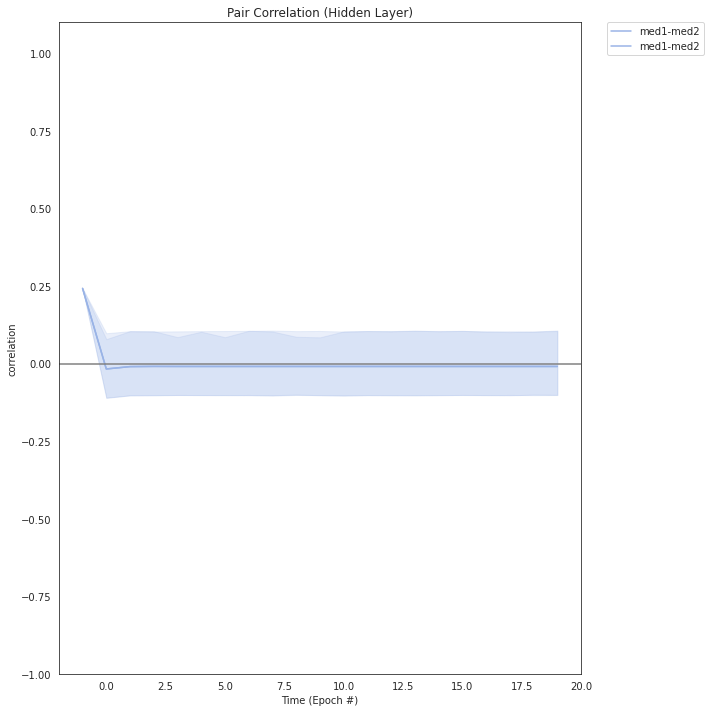

In [61]:
plt.clf()

analyses_df = plot_correlation_over_time(hidden_corr_long, 'Hidden', 'TestColorAll', numPairs, analyses_df)


In [62]:
# hidden_corr_long = plot_correlation_over_time(hiddenData, 'Hidden', 'TestFaceAll', numPairs)


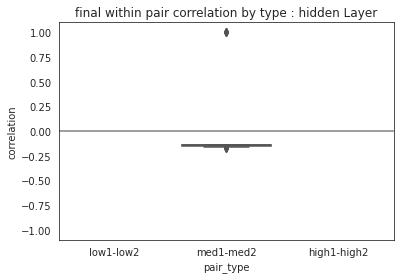

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 46.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


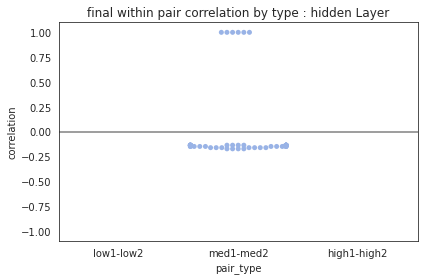

In [63]:
plt.clf()
hidden_just_main_corr, analyses_df = plot_final_correlation_over_time(hidden_corr_long, 'hidden', analyses_df) 

In [64]:
## Use try except block to not break the script if there's an error
## This is useful for the Post_analyses.py where sometimes we run test parameter searches 
title = "is the low/med/high within pair correlation in the right order in the hidden layer?"
try:

    if study_task_run == 1:
        mod, group_diff, group_order = analyze_within_pair_correlation(hidden_just_main_corr)


        ## is the model significant? i.e. is low / med / high different?
        temp = ['Hidden w_corr difference', group_diff, 0, 'Hidden within pair correlation-- is there a difference between low/med/high']
        temp_series = pd.Series(temp, index = results_df.columns)
        results_df = results_df.append(temp_series, ignore_index = True)

        ## is the low/med/high within pair correlation in the right order?
        temp = ['Hidden w_corr order', group_order, 0, 'Hidden within pair correlation-- is low/med/high in the right order']
        temp_series = pd.Series(temp, index = results_df.columns)
        results_df = results_df.append(temp_series, ignore_index = True)

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
except:
    traceback.print_exc()
    analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

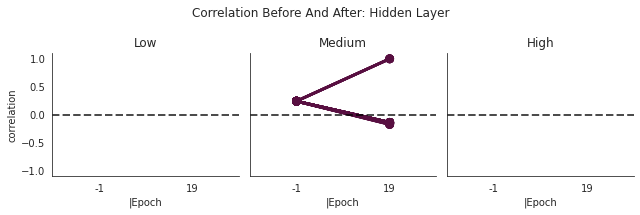

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

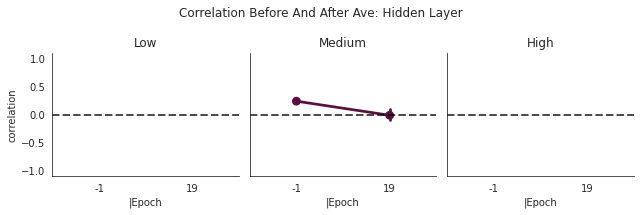

In [65]:
plt.clf()
hidden_just_main_corr, analyses_df = plot_correlation_comparison(hidden_corr_long, 'hidden', analyses_df) 

In [66]:
print(f"correlation analysis took {time.time() - tick} s", flush=True)

correlation analysis took 288.4883725643158 s


# Before vs after correlation

In [67]:
results_fig_dir

'/scratch/qanguyen/color_diff/alex_apr_9_distortionvscolor/results_--HiddNumOverlapUnits=2/fig/results/'

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


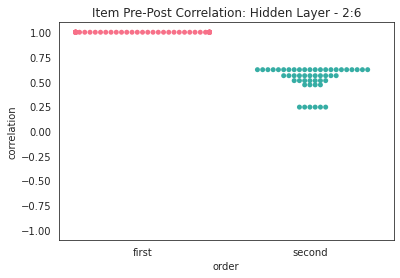

/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


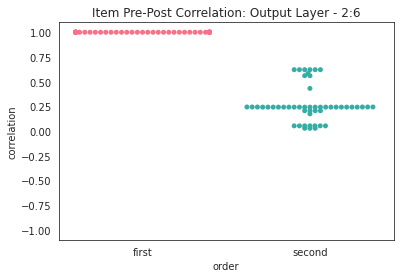

In [68]:


def plot_pre_post_correlation(data, layer):
    data=data.reset_index()


    ## get first and last epochs
    first_epoch = data['|Epoch'].min()
    last_epoch = data['|Epoch'].max()

    ## Reorganize the data frame
    data = data[data['|Epoch'].isin([first_epoch, last_epoch])]
    data = data.drop(columns = ['$CurrentTask', 'high1', 'high2', 'low1', 'low2'])
    data = data.melt(var_name='Trial', value_name='actM', value_vars=['med1', 'med2'], id_vars=['|Run', '|Epoch', '$CurrentTest', 'key'] )
    data = data.pivot(index=['|Run', '$CurrentTest', 'key', 'Trial'], columns = '|Epoch', values='actM').reset_index()
    data = data.sort_values(['|Run', '$CurrentTest', 'Trial', 'key'])

    ## Get the correlation values:
    data.head(30)
    df_pre_post_corr = data.groupby(['|Run', '$CurrentTest','Trial']).corr().reset_index()

    ## Reorganize the dataframe again:
    df_pre_post_corr = df_pre_post_corr.rename(columns={'|Epoch':'pre_post1'})
    df_pre_post_corr = df_pre_post_corr.melt(id_vars = ['|Run', '$CurrentTest', 'Trial', 'pre_post1'], var_name='pre_post2', value_vars=[first_epoch, last_epoch], value_name='correlation')

    ## We only care about correlation pre vs post:
    df_pre_post_corr = df_pre_post_corr[(df_pre_post_corr['pre_post1'] == first_epoch) & (df_pre_post_corr['pre_post2'] == last_epoch)]

    ## get the order (which trial came first or second)
    df_pre_post_corr = pd.merge(data_train_order, df_pre_post_corr, left_on = ['|Run', '$TrialName'], right_on = ['|Run', 'Trial'])

    ## add the trial type
    df_pre_post_corr['overlap'] = parameter_values['overlap']['overlapType']

    sns.swarmplot(x = 'order', y = 'correlation', data = df_pre_post_corr)
    plt.ylim(-1.1,1.1)
    
    
    title = 'Item Pre-Post Correlation: ' + layer.capitalize() + ' Layer - ' + parameter_values['overlap']['overlapType'].replace('/',':')
    plt.title(title)

    
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    
    df_pre_post_corr['layer'] = layer
    return df_pre_post_corr


df_pre_post_corr_hidd = plot_pre_post_correlation(hiddenData, 'hidden')
df_pre_post_corr_out = plot_pre_post_correlation(outputData, 'output')

df_pre_post_corr = pd.concat([df_pre_post_corr_hidd,df_pre_post_corr_out])


In [69]:
outputData

$TrialName                                                        high1  \
|Run |Epoch $CurrentTask    $CurrentTest key                              
0    -1     TaskColorWOOsc  TestColorAll #OutActM[2:0,0]<2:1,50>    0.0   
                                         #OutActM[2:0,1]            0.0   
                                         #OutActM[2:0,2]            0.0   
                                         #OutActM[2:0,3]            0.0   
                                         #OutActM[2:0,4]            0.0   
...                                                                 ...   
49    19    TaskColorRecall TestFaceAll  #OutActM[2:0,45]           0.0   
                                         #OutActM[2:0,46]           0.0   
                                         #OutActM[2:0,47]           0.0   
                                         #OutActM[2:0,48]           0.0   
                                         #OutActM[2:0,49]           0.0   

$TrialName                                                        high2  low1  \
|Run |Epoch $CurrentTask    $CurrentTest key                                    
0    -1     TaskColorWOOsc  TestColorAll #OutActM[2:0,0]<2:1,50>    0.0   0.0   
                                         #OutActM[2:0,1]            0.0   0.0   
                                         #OutActM[2:0,2]            0.0   0.0   
                                         #OutActM[2:0,3]            0.0   0.0   
                                         #OutActM[2:0,4]            0.0   0.0   
...                                                                 ...   ...   
49    19    TaskColorRecall TestFaceAll  #OutActM[2:0,45]           0.0   0.0   
                                         #OutActM[2:0,46]           0.0   0.0   
                                         #OutActM[2:0,47]           0.0   0.0   
                                         #OutActM[2:0,48]           0.0   0.0   
                                         #OutActM[2:0,49]           0.0   0.0   

$TrialName                                                        low2  \
|Run |Epoch $CurrentTask    $CurrentTest key                             
0    -1     TaskColorWOOsc  TestColorAll #OutActM[2:0,0]<2:1,50>   0.0   
                                         #OutActM[2:0,1]           0.0   
                                         #OutActM[2:0,2]           0.0   
                                         #OutActM[2:0,3]           0.0   
                                         #OutActM[2:0,4]           0.0   
...                                                                ...   
49    19    TaskColorRecall TestFaceAll  #OutActM[2:0,45]          0.0   
                                         #OutActM[2:0,46]          0.0   
                                         #OutActM[2:0,47]          0.0   
                                         #OutActM[2:0,48]          0.0   
                                         #OutActM[2:0,49]          0.0   

$TrialName                                                                med1  \
|Run |Epoch $CurrentTask    $CurrentTest key                                     
0    -1     TaskColorWOOsc  TestColorAll #OutActM[2:0,0]<2:1,50>  1.401000e-45   
                                         #OutActM[2:0,1]          1.401000e-45   
                                         #OutActM[2:0,2]          1.401000e-45   
                                         #OutActM[2:0,3]          1.401000e-45   
                                         #OutActM[2:0,4]          1.401000e-45   
...                                                                        ...   
49    19    TaskColorRecall TestFaceAll  #OutActM[2:0,45]         1.401000e-45   
                                         #OutActM[2:0,46]         1.401000e-45   
                                         #OutActM[2:0,47]         1.401000e-45   
                                         #OutActM[2:0,48]         1.401000e-45   
                       


# MDS
<a id='MDS'></a>

In [70]:
data_test

,|Run,|Epoch,$CurrentTask,$CurrentTest,|Trial,$TrialName,#Face_Err,#Face_SSE,#Face_AvgSSE,#Face_CosDiff,#Object_Err,#Object_SSE,#Object_AvgSSE,#Object_CosDiff,#Output_Err,...,"#OutActP[2:0,35]","#OutActP[2:0,36]","#OutActP[2:0,37]","#OutActP[2:0,38]","#OutActP[2:0,39]","#OutActP[2:0,40]","#OutActP[2:0,41]","#OutActP[2:0,42]","#OutActP[2:0,43]","#OutActP[2:0,44]","#OutActP[2:0,45]","#OutActP[2:0,46]","#OutActP[2:0,47]","#OutActP[2:0,48]","#OutActP[2:0,49]"
0,0,-1,TaskColorWOOsc,TestColorAll,0,med1,0,0.0,0.0,0.9977,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
1,0,-1,TaskColorWOOsc,TestColorAll,1,med2,0,0.0,0.0,1.0000,0,0,0,1,0,...,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45,1.401000e-45
2,0,-1,TaskColorWOOsc,TestColorAll,2,low1,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0,-1,TaskColorWOOsc,TestColorAll,3,low2,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0,-1,TaskColorWOOsc,TestColorAll,4,high1,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12295,49,19,TaskColorRecall,TestFaceAll,3,low2,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
12296,49,19,TaskColorRecall,TestColorAll,4,high1,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
12297,49,19,TaskColorRecall,TestFaceAll,4,high1,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
12298,49,19,TaskColorRecall,TestColorAll,5,high2,0,0.0,0.0,0.0000,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [71]:

def find_order_data_test(row, data_train_order) :

    curr_stim = row['$TrialName']
    curr_run = row['|Run']

    order = data_train_order[(data_train_order['|Run'] == curr_run) & (data_train_order['$TrialName'] == curr_stim)]['order']   

    order = order.iloc[0]
    return order


def prepare_MDS_data(data) :
    
    run = 0
    
    col = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '$TrialName']
    col.extend(filter_HiddM)

#    color_task = data['$CurrentTask'] == 'TaskColorRecall'
    color_test = data['$CurrentTest'] == 'TestColorAll'



    select_data = data[color_test][col]
    select_data= select_data[select_data['$TrialName'].isin(['med1', 'med2'])]
    select_data['order'] = select_data.apply(lambda row : find_order_data_test(row, data_train_order), axis = 1)

    

    
    all_data = np.empty([0, 50])
    all_runs = np.empty([0])
    all_names = np.empty([0])
    all_trialnames = np.empty([0])
    
    for run in range(nruns + 1):

        run_data = select_data[select_data['|Run'] == run]
        pre = run_data['|Epoch'] == run_data['|Epoch'].min()
        post = run_data['|Epoch'] == run_data['|Epoch'].max()
        first = run_data['order'] == 'first'
        second = run_data['order'] == 'second'
        
        first_pre = run_data[first & pre][filter_HiddM].to_numpy()
        first_post = run_data[first & post][filter_HiddM].to_numpy()

        second_pre = run_data[second & pre][filter_HiddM].to_numpy()
        second_post = run_data[second & post][filter_HiddM].to_numpy()

        run_array = np.array([first_pre[0], first_post[0], second_pre[0], second_post[0]])


        
        all_data = np.append(all_data, run_array,0)
    
        all_runs = np.append(all_runs, np.repeat(np.round(run), 4))
        all_names = np.append(all_names, ['first_pre','first_post', 'second_pre', 'second_post'])
        
        all_trialnames = np.append(all_trialnames, 
                                   np.concatenate([np.tile(run_data[first & pre]['$TrialName'].iloc[0],2),
                                   np.tile(run_data[second & pre]['$TrialName'].iloc[0],2)]))
    
        MDS_data = {'data' : all_data, 'runs': all_runs, 'names': all_names, 'trial_names': all_trialnames}

    if MDS_data['data'].shape[0] != MDS_data['runs'].shape[0] or MDS_data['data'].shape[0] != MDS_data['names'].shape[0]:
        raise ValueError
        print('Something wrong with the dimensions here')
    return select_data, MDS_data

select_data, MDS_data = prepare_MDS_data(data_test)



running MDS analysis


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

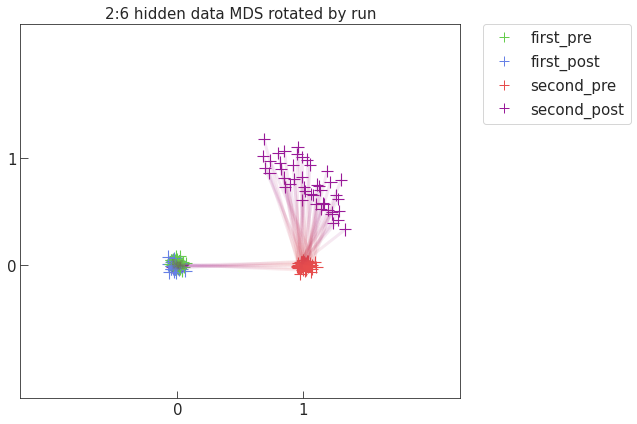

In [72]:
print("running MDS analysis", flush=True)
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.collections as mcoll

def multicolored_lines():
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    """

    x = np.linspace(0, 4. * np.pi, 100)
    y = np.sin(x)
    fig, ax = plt.subplots()
    lc = colorline(x, y, cmap='hsv')
    plt.colorbar(lc)
    plt.xlim(x.min(), x.max())
    plt.ylim(-1.0, 1.0)
    plt.show()

def colorline(ax,
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def MDS_plot_procrustes(MDS_data, run, distance_func="euclidean") :
    def euclidean(x,y):
        return np.linalg.norm(x-y)
    def pearsoncorr(x,y):
        return stats.stats.pearsonr(x, y)[0]
    if distance_func == "euclidean":
        distance_metric = euclidean
    else:
        distance_metric = pearsoncorr
        
    def show_activation(data):
        plt.clf()
        plt.imshow(data, cmap='plasma')
        plt.show()
    
    def show_distance_matrices_activation_embds(data, embds):
        plt.clf()
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
        run_distances = np.zeros((4, 4))
        for i in range(4):
            for j in range(4):
                run_distances[i, j] = distance_metric(data[i],data[j])
        ax0.imshow(run_distances, cmap='plasma')
        # We want to show all ticks...
        ax0.set_xticks(np.arange(4))
        ax0.set_yticks(np.arange(4))
        ax0.set_xticklabels(labels)
        ax0.set_yticklabels(labels)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax0.get_xticklabels(), rotation=90, ha="right",
                     rotation_mode="anchor")
        for i in range(4):
            for j in range(4):
                text = ax0.text(j, i, "%.2f" %(run_distances[i, j]),
                               ha="center", va="center", color="gray")

        run_distances_copy = np.zeros((4, 4))
        for i in range(4):
            for j in range(4):
                run_distances_copy[i, j] = distance_metric(embds[i],embds[j])
        
        ax1.imshow(run_distances_copy, cmap='plasma')
        # We want to show all ticks...
        ax1.set_xticks(np.arange(4))
        ax1.set_yticks(np.arange(4))
        ax1.set_xticklabels(labels)
        ax1.set_yticklabels(labels)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
                     rotation_mode="anchor")
        for i in range(4):
            for j in range(4):
                text = ax1.text(j, i, "%.2f" %(run_distances[i, j]),
                               ha="center", va="center", color="gray")
                
        plt.show()
        
    def show_scatter_pre_post_transform(pre, post, names):
        plt.clf()
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
        ax0.scatter(pre[:,0], pre[:,1], c = [color_dict[name] for name in names], 
                alpha = .9)
        ax1.scatter(post[:,0], post[:,1], c = [color_dict[name] for name in names], 
                alpha = .9)
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.show()
    
    def get_polar_angle(x, y):
        return np.arctan2(y, x) 
    
    def procrustes(data1, scale_pre_embd_dist):
        mtx1 = data1

        if mtx1.ndim != 2:
            raise ValueError("Input matrices must be two-dimensional")
        if mtx1.size == 0:
            raise ValueError("Input matrices must be >0 rows and >0 cols")
            
        # translate all the data to the origin
        
        translate = mtx1[[0]]
        temp = mtx1 - mtx1[[0]]
        theta = get_polar_angle(temp[1, 0], temp[1, 1])
        rotation_matrix = np.array([[np.cos(-theta), -np.sin(-theta)],
                                    [np.sin(-theta), np.cos(-theta)]])
        scale = np.linalg.norm(temp[1]) / (-0.2 * scale_pre_embd_dist  + 1.4)
        
        
        return translate, rotation_matrix, scale
    color_dict = {'first_pre': [.4, .8, .3], 'first_post': [.4, .5, .9],
                  'second_pre': [.9, .3, .3], 'second_post': [.6, .1, .6],
                  'mean_first': [.4, .65, .6], 'mean_second': [.75, .2, .45]
                 }
        

    data = MDS_data['data']
    names = MDS_data['names']
    labels = ['first_pre', 'first_post', 'second_pre', 'second_post']
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(9, 6))
    embedding = MDS(n_components = 2)
    #print(data.sh)

    # Flip embeddings across midline if trial starts with med2
    roll_units = {0: 0, 1: 0, 2:-1, 3:-1, 4: -2, 5:-2}
    if parameter_values['overlap']['numOverlapUnits'] % 2 == 1:
        data = np.hstack((data, np.zeros((data.shape[0], 1))))
    data = np.roll(data,roll_units[parameter_values['overlap']['numOverlapUnits']], axis=-1)
    transformed_data = []
    for run in range(nruns+1):
        
        if MDS_data["trial_names"][4 * run] == "med2":
            
            _ = np.fliplr(data[4 * run:4 * run+4])
            
        else:
            _ = data[4 * run:4 * run+4]
            
        #print(_)
        transformed_data.append(_)
    data = np.concatenate(transformed_data, axis=0)
    
    X_transformed = embedding.fit_transform(data)
    translate = X_transformed[[0]]
    X_transformed -= translate
    theta = get_polar_angle(X_transformed[2, 0], X_transformed[2, 1])
    rotation_matrix = np.array([[np.cos(-theta), -np.sin(-theta)],
                                [np.sin(-theta), np.cos(-theta)]])

    scale = np.linalg.norm(X_transformed[2]) / (-0.2 * parameter_values['overlap']['numOverlapUnits']  + 1.4)
    X_transformed =1/scale* (rotation_matrix@X_transformed.T).T + np.random.randn(*X_transformed.shape)*0.03
    
    # Flip across y-axis if most second-post points are below y-axis
    if np.mean(X_transformed[3::4, 1] > 0) < 0.5:
        X_transformed *= np.array([[1, -1]])
            
    scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], 
                         c = [color_dict[name] for name in names], 
            alpha = 1.0, marker='+', s=150,zorder=2, linewidths=1.10)
    
    
    for run in range(nruns+1):
        cm = LinearSegmentedColormap.from_list(
        "Custom", [color_dict['first_pre'], color_dict['first_post']], N=20)
        x = np.linspace(X_transformed[4*run+0,0],X_transformed[4*run+1,0],100)
        y = np.linspace(X_transformed[4*run+0,1],X_transformed[4*run+1,1],100)
        lc = colorline(ax, x, y, cmap=cm, alpha=0.1)

        cm = LinearSegmentedColormap.from_list(
        "Custom", [color_dict['second_pre'], color_dict['second_post']], N=20)
        x = np.linspace(X_transformed[4*run+2,0],X_transformed[4*run+3,0],100)
        y = np.linspace(X_transformed[4*run+2,1],X_transformed[4*run+3,1],100)
        lc = colorline(ax, x, y, cmap=cm, alpha=0.1)
        
    #plt.axis('square')
    
    legend_elements = [
                   Line2D([0], [0], marker='+', color=color_dict['first_pre'], label='first_pre',
                          markersize=10, lw = 0),
                    Line2D([0], [0], marker='+', color=color_dict['first_post'], label='first_post',
                                      markersize=10, lw = 0),
                    Line2D([0], [0], marker='+', color=color_dict['second_pre'], label='second_pre',
                                      markersize=10, lw = 0),
                    Line2D([0], [0], marker='+', color=color_dict['second_post'], label='second_post',
                                      markersize=10, lw = 0)
    ]

    ax.legend(handles = legend_elements, bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad=0., fontsize=15)
    title = parameter_values['overlap']['overlapType'].replace('/',':') + '_hidden_data_MDS_rotated_by_run'
    ax.set_title(title)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

    
    
    plt.xlim(-1.25, 2.25)
    plt.ylim(-1.25, 2.25)
    #ax.grid(True)
    #ax.xaxis.set_tick_params(width=5, length=15)
    #ax.yaxis.set_tick_params(width=5, length=15)
    
    #plt.setp(ax.xaxis.get_major_ticks(), visible=True, size=100)
    plt.xticks([0,1])
    plt.yticks([0,1])
    plt.tick_params(length=7.5, bottom=True, left=True, direction="in")
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    plt.savefig(eps_dir + title + '.eps')

    plt.show()

    
# MDS_plot(MDS_data, 0)
MDS_plot_procrustes(MDS_data, 'all')



<Figure size 432x288 with 0 Axes>

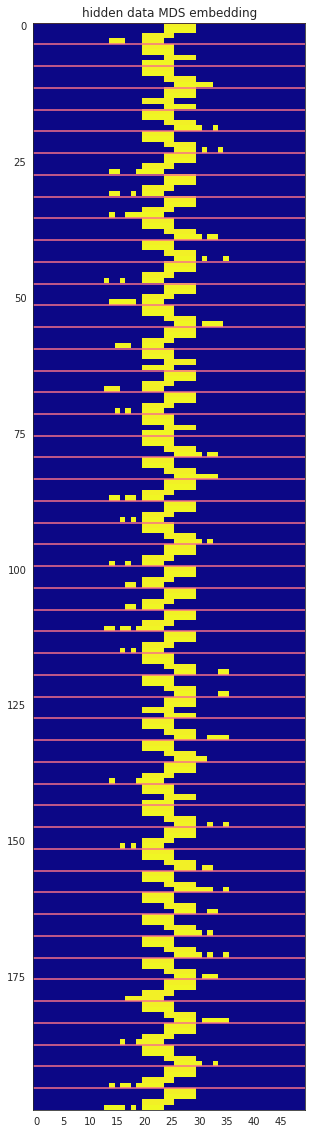

In [73]:
plt.clf()
fig, ax = plt.subplots(figsize = (10,20))
_ = np.roll(MDS_data["data"], -1, axis=-1)
plt.xticks(np.arange(0, 50, 5))
im = ax.imshow(np.flip(_,axis=-1), cmap='plasma')
[plt.axhline(i*4-0.5) for i in range(nruns+1)]
title = 'hidden data MDS embedding'
plt.title(title)
plt.savefig(results_fig_dir + title + '.png')
plt.show()

## Difference score
<a id='within-pair_correlation_minus_across-pair_correlation._Done_in_the_hidden_layer._'></a>
#### within-pair correlation minus across-pair correlation. Done in the hidden layer. 
as in Favila et al 2016, we expect that by the end, the high competition group should have a positive score indicating that the representations are more similar to each other than to other items. Medium overlap should have a negative score, and low overlap should be near zero. 

In [74]:
print('calculating difference score')

calculating difference score


In [75]:
if medium_only_analysis == False :

    def diff_score(data, layer, analyses_df) :
        title = 'Correlation Difference Score in ' + layer + ' Layer'
        try:
            plt.clf()
            df_diff_score = pd.DataFrame(columns = ['run', 'epoch', 'pair', 'diff_score'])

            #Difference score 
            names = data['firstItem'].unique()
            names = [n[:-1] for n in names]
            names = list(set(names))
            epochs_to_compare = [epoch_end_initial, max_final_epoch]
            for run in range(data_train['|Run'].max()) :
                #for loop run
                for epoch in epochs_to_compare :

                    for cat_overlap in names : 

                        first_item = cat_overlap + '1'
                        second_item = cat_overlap + '2'
                        pair = [first_item, second_item]

                        is_run = data['|Run'] == run
                        is_last_epoch  = data['|Epoch'] == epoch
                        is_first_trial = data['firstItem'] == first_item
                        is_second_trial = data['firstItem'] == second_item


                        #first pairmate, all correlations
                        first_item_all = data[is_first_trial & is_run & is_last_epoch]

                        #within pair correlation
                        within = first_item_all[first_item_all['secondItem'] == second_item]
                        within = within.iloc[0]['correlation']

                        #second pairmate, all correlations
                        second_item_all = data[is_second_trial & is_run & is_last_epoch]

                        #first pairmate, non pair correlations
                        other1 = first_item_all[-first_item_all['secondItem'].isin(pair)]
                        #second pairmate, non pair correlations
                        other2 = second_item_all[-second_item_all['secondItem'].isin(pair)]

                        #put them together and take mean
                        other = other1.append(other2)
                        other_corr_mean = other['correlation'].mean()

                        #calculate difference score
                        difference_score = within - other_corr_mean


                        #add to dataframe
                        temp = [run, epoch, cat_overlap, difference_score]
                        temp_series = pd.Series(temp, index =df_diff_score.columns)
                        df_diff_score = df_diff_score.append(temp_series, ignore_index =True)

            df_diff_score

            sns.barplot(x = 'pair', y = 'diff_score', hue='epoch', data = df_diff_score)
            plt.ylim(-1.5,1.5)

            plt.title(title)
            plt.tight_layout()
            plt.savefig(results_fig_dir + title + '.png')
            if from_cmdLine != 'cmd' :
                plt.show()

            analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
            return df_diff_score, analyses_df
        except:
            traceback.print_exc()
            analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
            return "error", analyses_df


    plt.clf()
    df_diff_score_hidden, analyses_df = diff_score(hidden_corr_long, 'Hidden', analyses_df)
    plt.clf()
    df_diff_score_color, analyses_df = diff_score(output_corr_long, 'Color', analyses_df)

# CENTER OF MASS 
<a id='CENTER_OF_MASS'></a>

In [76]:
print('analysis for center of mass')

analysis for center of mass


In [77]:
def calc_center_of_mass(act_array):
    unit_num = np.arange(1,51)

    weighted = unit_num * act_array
    weighted_sum = weighted.sum()
    mass_sum = act_array.sum() + 1e-30
    center_temp = weighted_sum / mass_sum
    #print("act_array", mass_sum)
    return center_temp

In [78]:
def calc_coa_true() :
    numTotalUnits = parameter_values['overlap']['numTotalUnits']
    numOverlapUnits = parameter_values['overlap']['numOverlapUnits'] 

    print("Warning: Assuming med2 color representation starts at index 25")
    unique = numTotalUnits - numOverlapUnits
    true_val_dict = {}
    true_val_dict['med1'] = (25 + 1 - 2 * unique + 25 + numTotalUnits)/2
    true_val_dict['med2'] = (25 + 1 + 25 + numTotalUnits)/2
    
    return true_val_dict

true_val_dict = calc_coa_true()

In [79]:


def find_center_of_mass(data, epoch, trial, run, layer) :
#     center_of_mass = np.empty(0)
#     for run in range(data_train['|Run'].max()):
    
    if_curr_run = data_test['|Run'] == run
    if_baseline_epoch = data_test['|Epoch'] == epoch
    if_trial = data_test['$TrialName'] == trial

    if layer == 'color':
        col_str = '#OutActM[' 
    elif layer == 'hidden' :
        col_str = '#HiddenActM['
        

    layer_col = [col for col in data.columns if col.startswith(col_str)]
    
    curr = data_test[if_curr_run & if_baseline_epoch & if_trial][layer_col].reset_index(drop = True)

    curr_np = curr.iloc[[0]].to_numpy()
    
    center_temp = calc_center_of_mass(curr_np)
    return center_temp


In [80]:

def get_center_mass_df(data, layer) :
    center_of_mass_df = pd.DataFrame(columns = ['run', 'time', 'type','stim', 'layer', 'c_o_m'])

    for run in range(data_train['|Run'].max()) :
        for time in ['pre', 'post'] :
            if time == 'pre' :
                epoch = epoch_end_initial

            elif time == 'post' :
                epoch = max_final_epoch

                
            for item in ['low1', 'low2', 'med1', 'med2', 'high1', 'high2']:
                c_o_a = find_center_of_mass(data, epoch, item, run, layer = layer)
                temp = [run, time, 'raw', item, layer, c_o_a]
                temp_series = pd.Series(temp, index = center_of_mass_df.columns)
                center_of_mass_df = center_of_mass_df.append(temp_series, ignore_index = True)


    return center_of_mass_df


In [81]:

def get_center_mass_df_all_epochs(data, layer) :
    center_of_mass_df = pd.DataFrame(columns = ['run', 'time', 'type','stim', 'layer', 'c_o_m'])

    for run in range(data_train['|Run'].max()) :
        for epoch in range(-1, max_final_epoch) :
            time = epoch


                
            for item in ['low1', 'low2', 'med1', 'med2', 'high1', 'high2']:
                c_o_a = find_center_of_mass(data, epoch, item, run, layer = layer)
                temp = [run, time, 'raw', item, layer, c_o_a]
                temp_series = pd.Series(temp, index = center_of_mass_df.columns)
                center_of_mass_df = center_of_mass_df.append(temp_series, ignore_index = True)

    return center_of_mass_df


In [82]:

is_color_test = data_test['$CurrentTest'] == 'TestColorAll'
is_color_recall = data_test['$CurrentTask'] == 'TaskColorRecall'

curr_data_test = data_test[is_color_test & is_color_recall]



color_center_of_mass_df = get_center_mass_df(curr_data_test, 'color')
hidden_center_of_mass_df = get_center_mass_df(curr_data_test, 'hidden')


color_center_of_mass_all_epochs_df = get_center_mass_df_all_epochs(curr_data_test, 'color') 

In [83]:
color_center_of_mass_all_epochs_df

,run,time,type,stim,layer,c_o_m
0,0,-1,raw,low1,color,0.000000
1,0,-1,raw,low2,color,0.000000
2,0,-1,raw,med1,color,24.504790
3,0,-1,raw,med2,color,28.495168
4,0,-1,raw,high1,color,0.000000
...,...,...,...,...,...,...
5875,48,18,raw,low2,color,0.000000
5876,48,18,raw,med1,color,24.499399
5877,48,18,raw,med2,color,33.166723
5878,48,18,raw,high1,color,0.000000


### compare to true center of mass

In [84]:
def flip_error(row, true_val_dict):
    
    curr_stim = row['stim']

    if curr_stim[-1] == '1' :
        other_stim_n = '2'
    elif curr_stim[-1] == '2' :
        other_stim_n = '1'
        
    other_stim = curr_stim[:-1] + other_stim_n
    
    if (other_stim in true_val_dict) and (curr_stim in true_val_dict):
        dist_size = true_val_dict[other_stim] - true_val_dict[curr_stim]

        ### NOTE: THIS ONLY WORKS RIGHT NOW DIST SIZE IS LESS THAN 180
        ### NOTE: THIS ONLY WORKS RIGHT NOW FOR MED UNITS
        if dist_size < 0 :
            rev_error = -1 * row['raw_error']
        else :
            rev_error = row['raw_error']


        return rev_error 
    else:
        return 0


In [85]:
color_center_of_mass_df

,run,time,type,stim,layer,c_o_m
0,0,pre,raw,low1,color,0.000000
1,0,pre,raw,low2,color,0.000000
2,0,pre,raw,med1,color,24.504790
3,0,pre,raw,med2,color,28.495168
4,0,pre,raw,high1,color,0.000000
...,...,...,...,...,...,...
583,48,post,raw,low2,color,0.000000
584,48,post,raw,med1,color,24.499399
585,48,post,raw,med2,color,33.166723
586,48,post,raw,high1,color,0.000000


In [86]:
def calc_error(c_o_a_df_color, true_val_dict) :
    
    c_o_a_df_color = c_o_a_df_color.dropna()

    c_o_a_df_color['true_c_o_m'] = c_o_a_df_color['stim'].map(true_val_dict)
    

    c_o_a_df_color['raw_error'] = round(c_o_a_df_color['c_o_m'] - c_o_a_df_color['true_c_o_m'], 5)
    
    c_o_a_df_color['rev_error'] = c_o_a_df_color.apply(lambda row: flip_error(row, true_val_dict), axis=1)
    

    return c_o_a_df_color
    
    ## This is where we'd run 

In [87]:
color_center_of_mass_all_epochs_df = calc_error(color_center_of_mass_all_epochs_df, true_val_dict)
color_center_of_mass_df = calc_error(color_center_of_mass_df, true_val_dict) 

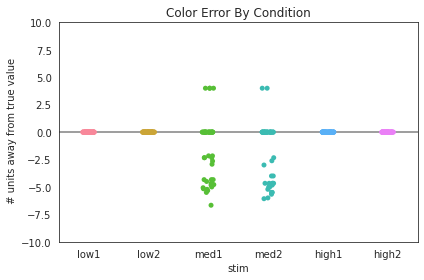

In [88]:
def plot_error(data) :
    plt.clf()
    is_post = data['time'] == 'post'

    subset_data = data[is_post ]
    sns.stripplot(x='stim', y = 'rev_error',data = subset_data)
    plt.axhline(0, ls = '-', color = 'gray')
    title = 'Color Error By Condition'
    plt.title(title)
    plt.ylim([-10,10])
    plt.ylabel(' # units away from true value')
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    


plot_error(color_center_of_mass_df)
    

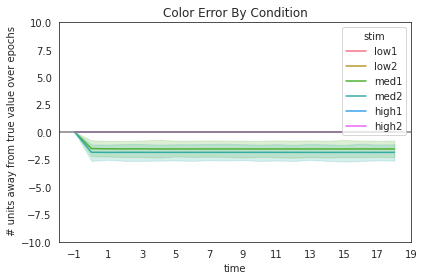

In [89]:
def plot_error_over_time(data) :
    

    plt.clf()
    sns.lineplot(x='time', y = 'rev_error', hue = 'stim', data = data)
    plt.axhline(0, ls = '-', color = 'gray')
    title = 'Color Error By Condition'
    plt.title(title)
    plt.ylim([-10,10])
    plt.ylabel(' # units away from true value over epochs')
    plt.xticks(np.arange(-1, max_final_epoch+1, 2))
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    


plot_error_over_time(color_center_of_mass_all_epochs_df)
    

In [90]:

## Get the initial order: 

data_train_order = data_train.copy()
data_train_order= data_train_order[['|Run','|Epoch', '$CurrentTask', '|Trial', '$TrialName']]

if task_run !='just_face':
    data_train_order = data_train_order[data_train_order['$CurrentTask'] == 'TaskColorRecall']
else:
    data_train_order = data_train_order[data_train_order['$CurrentTask'] == 'TaskFaceRecall']


data_train_order = data_train_order[data_train_order['$TrialName'].isin(['med1','med2'])]

data_train_order = data_train_order[data_train_order['|Epoch'] == min(data_train_order['|Epoch']) ]
print(data_train_order)

order_map_dict = {0: 'first', 1:'second'}
data_train_order['order'] = data_train_order['|Trial'].map(order_map_dict)
data_train_order = data_train_order[['|Run', '$TrialName', 'order']]


      |Run  |Epoch     $CurrentTask  |Trial $TrialName
0        0       0  TaskColorRecall       0       med1
1        0       0  TaskColorRecall       1       med2
120      1       0  TaskColorRecall       0       med2
121      1       0  TaskColorRecall       1       med1
240      2       0  TaskColorRecall       0       med2
...    ...     ...              ...     ...        ...
5641    47       0  TaskColorRecall       1       med1
5760    48       0  TaskColorRecall       0       med1
5761    48       0  TaskColorRecall       1       med2
5880    49       0  TaskColorRecall       0       med1
5881    49       0  TaskColorRecall       1       med2

[100 rows x 5 columns]


In [91]:
# color_center_of_mass_df[(color_center_of_mass_df['stim'].isin(['med1','med2'])) & (color_center_of_mass_df['run']==1)]

def find_order(row, data_train_order) :
    curr_stim = row['stim']
    curr_run = row['run']
    if curr_stim in np.unique(data_train_order['$TrialName']):
        order = data_train_order[(data_train_order['|Run'] == curr_run) & (data_train_order['$TrialName'] == curr_stim)]['order']   
        order = order.iloc[0]
        return order
    else:
        return None

color_center_of_mass_df['order'] = color_center_of_mass_df.apply(lambda row : find_order(row, data_train_order), axis = 1)
color_center_of_mass_all_epochs_df['order'] = color_center_of_mass_all_epochs_df.apply(lambda row : find_order(row, data_train_order), axis = 1)




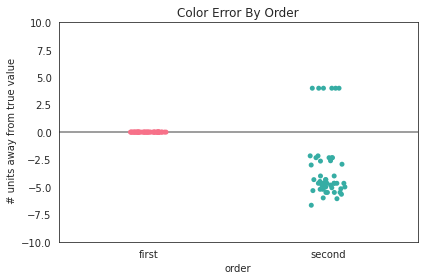

In [92]:
def plot_error_order(data) :
    plt.clf()
    is_post = data['time'] == 'post'

    subset_data = data[is_post]

    sns.stripplot(x='order', y = 'rev_error', data = subset_data)
    plt.axhline(0, ls = '-', color = 'gray')
    title = 'Color Error By Order'
    plt.title(title)
    
    plt.ylim([-10,10])
    plt.ylabel(' # units away from true value')
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()


plot_error_order(color_center_of_mass_df)

In [93]:
color_center_of_mass_all_epochs_df


,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error,order
0,0,-1,raw,low1,color,0.000000,NaN,NaN,0.00000,None
1,0,-1,raw,low2,color,0.000000,NaN,NaN,0.00000,None
2,0,-1,raw,med1,color,24.504790,24.5,0.00479,0.00479,first
3,0,-1,raw,med2,color,28.495168,28.5,-0.00483,0.00483,second
4,0,-1,raw,high1,color,0.000000,NaN,NaN,0.00000,None
...,...,...,...,...,...,...,...,...,...,...
5875,48,18,raw,low2,color,0.000000,NaN,NaN,0.00000,None
5876,48,18,raw,med1,color,24.499399,24.5,-0.00060,-0.00060,first
5877,48,18,raw,med2,color,33.166723,28.5,4.66672,-4.66672,second
5878,48,18,raw,high1,color,0.000000,NaN,NaN,0.00000,None


In [94]:
color_center_of_mass_all_epochs_df
color_center_of_mass_all_epochs_df[color_center_of_mass_all_epochs_df['run'] == 3].head(10)

,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error,order
360,3,-1,raw,low1,color,0.000000,NaN,NaN,0.00000,None
361,3,-1,raw,low2,color,0.000000,NaN,NaN,0.00000,None
362,3,-1,raw,med1,color,24.504804,24.5,0.00480,0.00480,first
363,3,-1,raw,med2,color,28.495928,28.5,-0.00407,0.00407,second
364,3,-1,raw,high1,color,0.000000,NaN,NaN,0.00000,None
365,3,-1,raw,high2,color,0.000000,NaN,NaN,0.00000,None
366,3,0,raw,low1,color,0.000000,NaN,NaN,0.00000,None
367,3,0,raw,low2,color,0.000000,NaN,NaN,0.00000,None
368,3,0,raw,med1,color,24.499123,24.5,-0.00088,-0.00088,first
369,3,0,raw,med2,color,24.499112,28.5,-4.00089,4.00089,second


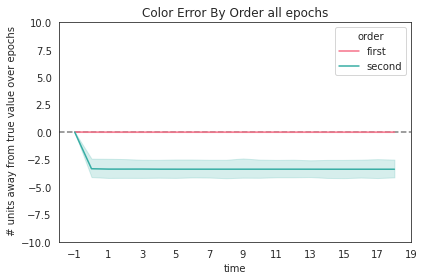

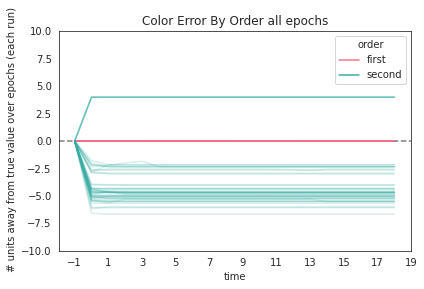

In [95]:
def plot_error_over_time_with_order(data) :
    
    plt.clf()
    

#     data = data[data['run'] == 3]
    plt.axhline(0, ls = '--', color = 'gray')

    sns.lineplot(x='time', y = 'rev_error', hue = 'order', data = data)
    title = 'Color Error By Order all epochs'
    plt.title(title)
    plt.ylim([-10,10])
    plt.ylabel(' # units away from true value over epochs')
    plt.xticks(np.arange(-1, max_final_epoch+1, 2))
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    

    ### each epoch separately 
    plt.clf()
    plt.axhline(0, ls = '--', color = 'gray')

    sns.lineplot(x='time', y = 'rev_error', hue = 'order', units = 'run', estimator = None, alpha = .2, data = data)
    title = 'Color Error By Order all epochs'
    plt.title(title)
    plt.ylim([-10,10])
    plt.ylabel(' # units away from true value over epochs (each run)')
    plt.xticks(np.arange(-1, max_final_epoch+1, 2))
    
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    


plot_error_over_time_with_order(color_center_of_mass_all_epochs_df)
    


#### Plot distance center of mass

In [96]:
def calc_c_o_a_distance(center_of_mass_df, layer) :
    for run in range(data_train['|Run'].max()) :
        for time in ['pre', 'post'] :
            pair = 'med' #this is only for med right now
            is_run = center_of_mass_df['run']==run
            is_time = center_of_mass_df['time']== time

            item1 = pair + '1'
            item2 = pair + '2'

            val2 = center_of_mass_df[is_run & is_time  & (center_of_mass_df['stim'] == item2)][['c_o_m']].to_numpy()
            val1 = center_of_mass_df[is_run & is_time  & (center_of_mass_df['stim'] == item1)][['c_o_m']].to_numpy()

 
            diff = val2 - val1
            diff = diff[0][0]
            true_coa = true_val_dict['med2'] - true_val_dict['med1']
            name = pair + '_diff'
            temp = [run, time, 'diff', name, layer, diff, true_coa, np.nan, np.nan, np.nan]

            temp_series = pd.Series(temp, index = center_of_mass_df.columns)

            center_of_mass_df = center_of_mass_df.append(temp_series, ignore_index = True)# for item in ['post_low1', 'post_low2', 'post_med1', 'post_med2' ,'post_high1', 'post_high2'] :

    return center_of_mass_df


In [97]:
# same thing, but over each epoch
def calc_c_o_a_distance_epochs(center_of_mass_df, layer) :
    for run in range(data_train['|Run'].max()) :
        for epoch in range(-1, max_final_epoch) :
            time = epoch
            pair = 'med' #this is only for med right now
            is_run = center_of_mass_df['run']==run
            is_time = center_of_mass_df['time']== time
            item1 = pair + '1'
            item2 = pair + '2'

            val2 = center_of_mass_df[is_run & is_time  & (center_of_mass_df['stim'] == item2)][['c_o_m']].to_numpy()
            val1 = center_of_mass_df[is_run & is_time  & (center_of_mass_df['stim'] == item1)][['c_o_m']].to_numpy()

            
            diff = val2 - val1
            diff = diff[0][0]
            true_coa = true_val_dict['med2'] - true_val_dict['med1']
            name = pair + '_diff'
            temp = [run, time, 'diff', name, layer, diff, true_coa, np.nan, np.nan, np.nan]

            temp_series = pd.Series(temp, index = center_of_mass_df.columns)

            center_of_mass_df = center_of_mass_df.append(temp_series, ignore_index = True)# for item in ['post_low1', 'post_low2', 'post_med1', 'post_med2' ,'post_high1', 'post_high2'] :

    return center_of_mass_df



In [98]:
def plot_center_of_mass_dist(center_of_mass_df, layer) :
    ## Use try except block to not break the script if there's an error
    ## This is useful for the Post_analyses.py where sometimes we run test parameter searches 
    title = 'Distance Between Center of Masses: ' + layer 
    
    try:
        plt.clf()
#         temp = center_of_mass_df[center_of_mass_df['stim'].isin(['med_diff'])]

#         print(temp.head())
        if study_task_run == 1 :
            ax = sns.violinplot(x="stim", y="c_o_m", hue="time", data=center_of_mass_df, dodge=True)
        elif study_task_run ==0 :
            ax = sns.swarmplot(x = "stim", y="c_o_m", hue="time", data=center_of_mass_df, alpha = .2)

        ax = sns.pointplot(x = "stim", y="c_o_m", hue="time", data=center_of_mass_df, legend = False)
        # sns.swarmplot(x="key", y="value", hue="time", data=temp, color = 'white', dodge=True)

        handles, labels = ax.get_legend_handles_labels()
        l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        plt.ylim(0,12)
        plt.ylabel('units apart')
        plt.title(title)
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png')
        if from_cmdLine != 'cmd' :
            plt.show()

        print('this is assuming just medium overlap condition:')
        units_apart = center_of_mass_df.dropna()
        units_apart[units_apart['time'] == 'post']
#         tstat, pvalue = stats.ttest_1samp(units_apart[units_apart['time'] == 'post']['c_o_m'], 4)
#         print('is post-difference significantly different from 4 (pre training unit apart distance)?')
#         print('t = ' + str(tstat))
#         print('p = ' + str(pvalue))

#         print('pre: ' + str(units_apart[units_apart['time'] == 'pre'].c_o_m.mean()))
#         print('post: ' + str(units_apart[units_apart['time'] == 'post'].c_o_m.mean()))


#         if study_task_run == 1:
#             model = ols('c_o_m ~ C(time)*C(stim)', temp).fit()
#             print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
#             print('----')
#             print('MODEL SUMMARY: ')
#             print(model.summary())
#             print('----')
#             res = sm.stats.anova_lm(model, typ= 2)
#             print(res)

#             analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 

    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 

In [99]:
def plot_center_of_mass_dist_epochs(center_of_mass_df, layer) :
    ## Use try except block to not break the script if there's an error
    ## This is useful for the Post_analyses.py where sometimes we run test parameter searches 
    title = 'Distance Between Center of Masses Across Epochs: ' + layer 
    

    plt.clf()

    ax = sns.lineplot(x = "time", y="c_o_m", units="run", estimator=None, data=center_of_mass_df, alpha = .2, legend = False)

    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.ylim(-1,12)
    plt.ylabel('units apart')
    plt.xticks(np.arange(-1, max_final_epoch+1, 2))

    correct_val = true_val_dict['med2'] - true_val_dict['med1']
    plt.axhline(y=correct_val, linestyle='--',color = 'k')
    
    plt.title(title)
    
    
    
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()

    print('this is assuming just medium overlap condition:')
    units_apart = center_of_mass_df.dropna()
    units_apart[units_apart['time'] == 'post']


In [100]:
color_center_of_mass_df = calc_c_o_a_distance(color_center_of_mass_df, 'layer')
color_distance_df = color_center_of_mass_df[color_center_of_mass_df['stim'].isin(['med_diff'])]

color_center_of_mass_all_epochs_df = calc_c_o_a_distance_epochs(color_center_of_mass_all_epochs_df, 'layer')
color_distance_epochs_df = color_center_of_mass_all_epochs_df[color_center_of_mass_all_epochs_df['stim'].isin(['med_diff'])]


In [101]:
color_center_of_mass_all_epochs_df

,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error,order
0,0,-1,raw,low1,color,0.000000,NaN,NaN,0.00000,None
1,0,-1,raw,low2,color,0.000000,NaN,NaN,0.00000,None
2,0,-1,raw,med1,color,24.504790,24.5,0.00479,0.00479,first
3,0,-1,raw,med2,color,28.495168,28.5,-0.00483,0.00483,second
4,0,-1,raw,high1,color,0.000000,NaN,NaN,0.00000,None
...,...,...,...,...,...,...,...,...,...,...
6855,48,14,diff,med_diff,layer,8.667324,4.0,NaN,NaN,NaN
6856,48,15,diff,med_diff,layer,8.667324,4.0,NaN,NaN,NaN
6857,48,16,diff,med_diff,layer,8.667324,4.0,NaN,NaN,NaN
6858,48,17,diff,med_diff,layer,8.667324,4.0,NaN,NaN,NaN


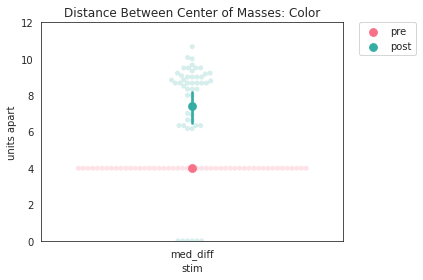

this is assuming just medium overlap condition:


In [102]:
plot_center_of_mass_dist(color_distance_df, 'Color')
# plot_center_of_mass_dist(hidden_center_of_mass_df, 'Hidden')

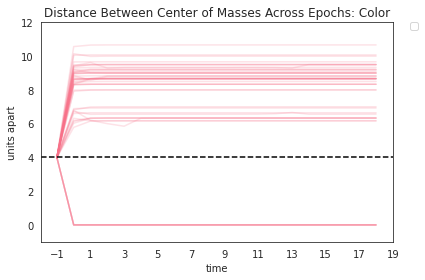

this is assuming just medium overlap condition:


In [103]:
plot_center_of_mass_dist_epochs(color_distance_epochs_df, 'Color')


In [104]:
color_center_of_mass_all_epochs_df

,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error,order
0,0,-1,raw,low1,color,0.000000,NaN,NaN,0.00000,None
1,0,-1,raw,low2,color,0.000000,NaN,NaN,0.00000,None
2,0,-1,raw,med1,color,24.504790,24.5,0.00479,0.00479,first
3,0,-1,raw,med2,color,28.495168,28.5,-0.00483,0.00483,second
4,0,-1,raw,high1,color,0.000000,NaN,NaN,0.00000,None
...,...,...,...,...,...,...,...,...,...,...
6855,48,14,diff,med_diff,layer,8.667324,4.0,NaN,NaN,NaN
6856,48,15,diff,med_diff,layer,8.667324,4.0,NaN,NaN,NaN
6857,48,16,diff,med_diff,layer,8.667324,4.0,NaN,NaN,NaN
6858,48,17,diff,med_diff,layer,8.667324,4.0,NaN,NaN,NaN


    epoch  repulsion  repulsion_percent overlap
0      -1          0           0.000000     2/6
1       0         43          87.755102     2/6
2       1         43          87.755102     2/6
3       2         43          87.755102     2/6
4       3         43          87.755102     2/6
5       4         43          87.755102     2/6
6       5         43          87.755102     2/6
7       6         43          87.755102     2/6
8       7         43          87.755102     2/6
9       8         43          87.755102     2/6
10      9         43          87.755102     2/6
11     10         43          87.755102     2/6
12     11         43          87.755102     2/6
13     12         43          87.755102     2/6
14     13         43          87.755102     2/6
15     14         43          87.755102     2/6
16     15         43          87.755102     2/6
17     16         43          87.755102     2/6
18     17         43          87.755102     2/6
19     18         43          87.755102 

<ipython-input-105-3d8285037f55>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repulsion_all['repulsion'] = np.where(np.round(repulsion_all['c_o_m'],3) > np.round(repulsion_all['true_c_o_m'],3), 1, 0)


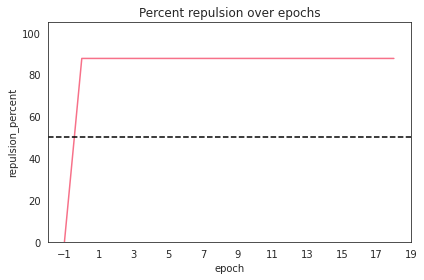

In [105]:
def plot_percent_repulsion_over_epochs(color_center_of_mass_all_epochs_df) :
    
    plt.clf()
    repulsion_all = color_center_of_mass_all_epochs_df[color_center_of_mass_all_epochs_df['stim'] == 'med_diff']
    repulsion_all['repulsion'] = np.where(np.round(repulsion_all['c_o_m'],3) > np.round(repulsion_all['true_c_o_m'],3), 1, 0)
    repulsion_count_each_run = pd.DataFrame(repulsion_all.groupby('time')['repulsion'].sum()).reset_index()
    repulsion_count_each_run
    repulsion_count_each_run['repulsion_percent'] = repulsion_count_each_run['repulsion'].div(nruns) * 100
    repulsion_count_each_run =repulsion_count_each_run.rename(columns={"time": "epoch"})
    repulsion_count_each_run['overlap'] = parameter_values['overlap']['overlapType']
    
    sns.lineplot(x= 'epoch', y = 'repulsion_percent', data = repulsion_count_each_run)
    plt.axhline(y = 50, linestyle = '--', color= 'k')
    plt.ylim(0,105)
    plt.xticks(np.arange(-1, max_final_epoch+1, 2))

    title = 'Percent repulsion over epochs'
    plt.title(title)
    print(repulsion_count_each_run)
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
        
    return repulsion_count_each_run, repulsion_all
    
repulsion_count_each_run, repulsion_all = plot_percent_repulsion_over_epochs(color_center_of_mass_all_epochs_df)
    
#     sns.lineplot(x= 'time', y = 'repulsion_percent', data = r)

In [106]:
def join_center_of_mass_DFs(color_c_m_DF, hidden_c_m_DF) :
    
    color_c_m_DF['layer'] = 'color'
    hidden_c_m_DF['layer'] = 'hidden'

    new_df = color_c_m_DF.append(hidden_c_m_DF)
    
    new_df['overlap'] = parameter_values['overlap']['overlapType']
    return new_df

center_of_mass_df = join_center_of_mass_DFs(color_center_of_mass_df,hidden_center_of_mass_df)


In [107]:
center_of_mass_df

,run,time,type,stim,layer,c_o_m,true_c_o_m,raw_error,rev_error,order,overlap
0,0,pre,raw,low1,color,0.000000,NaN,NaN,0.00000,None,2/6
1,0,pre,raw,low2,color,0.000000,NaN,NaN,0.00000,None,2/6
2,0,pre,raw,med1,color,24.504790,24.5,0.00479,0.00479,first,2/6
3,0,pre,raw,med2,color,28.495168,28.5,-0.00483,0.00483,second,2/6
4,0,pre,raw,high1,color,0.000000,NaN,NaN,0.00000,None,2/6
...,...,...,...,...,...,...,...,...,...,...,...
583,48,post,raw,low2,hidden,0.000000,NaN,NaN,NaN,NaN,2/6
584,48,post,raw,med1,hidden,24.500002,NaN,NaN,NaN,NaN,2/6
585,48,post,raw,med2,hidden,31.999936,NaN,NaN,NaN,NaN,2/6
586,48,post,raw,high1,hidden,0.000000,NaN,NaN,NaN,NaN,2/6


In [108]:
hidden_center_of_mass_df.iloc[:50]

,run,time,type,stim,layer,c_o_m
0,0,pre,raw,low1,hidden,0.000000
1,0,pre,raw,low2,hidden,0.000000
2,0,pre,raw,med1,hidden,24.500124
3,0,pre,raw,med2,hidden,28.499905
4,0,pre,raw,high1,hidden,0.000000
5,0,pre,raw,high2,hidden,0.000000
6,0,post,raw,low1,hidden,0.000000
7,0,post,raw,low2,hidden,0.000000
8,0,post,raw,med1,hidden,24.500002
9,0,post,raw,med2,hidden,32.285713


In [109]:
category_palette

{'low': (0.7, 0.4, 0.7), 'med': (0.3, 0.4, 0.7), 'high': (0.5, 0.8, 0.5)}

layer_color  c_o_m_color  true_c_o_m_color  \
run time type stim                                                  
0   post raw  low1           color     0.000000               NaN   
              low2           color     0.000000               NaN   
              med1           color    24.499315              24.5   
              med2           color    33.500000              28.5   
              high1          color     0.000000               NaN   
...                            ...          ...               ...   
44  post diff med_diff       color     8.001040               4.0   
45  post diff med_diff       color     9.214913               4.0   
46  post diff med_diff       color     6.334535               4.0   
47  post diff med_diff       color     9.500800               4.0   
48  post diff med_diff       color     8.667324               4.0   

                        raw_error_color  rev_error_color   order layer_hidden  \
run time type stim                                                              
0   post raw  low1                  NaN         0.193164    None          NaN   
              low2                  NaN        -0.108951    None          NaN   
              med1             -0.00069         0.078863   first       hidden   
              med2              5.00000        -4.924984  second       hidden   
              high1                 NaN        -0.194748    None          NaN   
...                                 ...              ...     ...          ...   
44  post diff med_diff              NaN              NaN     NaN          NaN   
45  post diff med_diff              NaN              NaN     NaN          NaN   
46  post diff med_diff              NaN              NaN     NaN          NaN   
47  post diff med_diff              NaN              NaN     NaN          NaN   
48  post diff med_diff              NaN              NaN     NaN          NaN   

                        c_o_m_hidden  true_c_o_m_hidden  raw_error_hidden  \
run time type stim                                                          
0   post raw  low1               NaN                NaN               NaN   
              low2               NaN                NaN               NaN   
              med1         24.500002               24.5           0.00000   
              med2         32.285713               28.5           3.78571   
              high1              NaN                NaN               NaN   
...                              ...                ...               ...   
44  post diff med_diff           NaN                NaN               NaN   
45  post diff med_diff           NaN                NaN               NaN   
46  post diff med_diff           NaN                NaN               NaN   
47  post diff med_diff           NaN                NaN               NaN   
48  post diff med_diff           NaN                NaN               NaN   

                        rev_error_hidden  
run time type stim                        
0   post raw  low1                   NaN  
              low2                   NaN  
              med1             -0.080305  
              med2             -3.544036  
              high1                  NaN  
...                                  ...  
44  post diff med_diff               NaN  
45  post diff med_diff               NaN  
46  post diff med_diff               NaN  
47  post diff med_diff               NaN  
48  post diff med_diff               NaN  

[343 rows x 11 columns]

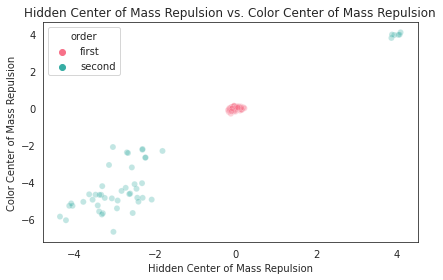

In [117]:

def plot_hidden_distortion_vs_color_distortion():
    title = 'Hidden Center of Mass Repulsion vs. Color Center of Mass Repulsion'
    try:
        plt.clf()
        hidden_distortion = calc_error(hidden_center_of_mass_df, true_val_dict) 
        _cond = (hidden_distortion["time"] == "post") & (hidden_distortion["stim"].str.contains("med"))
        hidden_distortion = hidden_distortion[_cond]

        _cond = color_center_of_mass_df["time"] == "post"
        color_distortion = color_center_of_mass_df[_cond]

        color_distortion = (color_distortion.set_index(["run", "time", "type","stim"]))
        hidden_distortion = (hidden_distortion.set_index(["run", "time", "type","stim"]))
        merged = pd.merge(color_distortion, hidden_distortion, left_index=True, right_index=True, how="left", suffixes=('_color', '_hidden'))
        merged["rev_error_hidden"] += 0.1*np.random.randn(len(merged["rev_error_hidden"]))
        merged["rev_error_color"] += 0.1*np.random.randn(len(merged["rev_error_color"]))
        display(merged)
        plt.title(title)
        plt.xlabel("Hidden Center of Mass Repulsion")
        plt.ylabel("Color Center of Mass Repulsion")
        sns.scatterplot(data=merged, x="rev_error_hidden", y="rev_error_color", hue="order", alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(results_fig_dir + title + '.png')
    except:
        traceback.print_exc()

        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        
plot_hidden_distortion_vs_color_distortion()

# Analyze Face Layer in Association Task
<a id='Face_Association_Task'></a>

In [ ]:
print('analyze face layer in association task')

In [ ]:
def assign_type_face(row) :
    face_dict = {'med1': {'low1_ActM': 'other',
                      'low2_ActM': 'other',
                      'med1_ActM': 'target', 
                      'med2_ActM': 'competitor',
                      'high1_ActM': 'other', 
                      'high2_ActM': 'other'},
            'med2': {'low1_ActM': 'other',
                      'low2_ActM': 'other',
                      'med1_ActM': 'competitor', 
                      'med2_ActM': 'target',
                      'high1_ActM': 'other', 
                      'high2_ActM': 'other'}}
    
    if row['$TrialName'] in face_dict :
        unit_type = face_dict[row['$TrialName']][row['unit']]
    else :
        
        unit_type = np.NAN

    return unit_type

print('assuming only med1 and med2 -- every other trial type here set to NAN')



In [ ]:
def get_face_act_df() :
    plt.clf()
    face_columns = [col for col in data_test.columns if col.startswith('#FaceActM')]
    columns = ['|Run', '|Epoch', '$CurrentTask', '$CurrentTest', '|Trial', '$TrialName']
    initial_columns = columns.copy()
    columns.extend(face_columns)

    is_face_test = data_test['$CurrentTest']=='TestFaceAll'
    
    is_Task = data_test['$CurrentTask'] == 'TaskColorRecall'
    is_med = data_test['$TrialName'].isin(['med1','med2'])

    relevant_data = data_test[is_face_test & is_Task & is_med]
    relevant_data[columns]

    face_data_df = relevant_data[columns].rename(columns = faceKeyM)
    print(face_data_df)
    face_data_df = face_data_df.melt(id_vars = initial_columns, value_name = 'Act_M', var_name = 'unit', value_vars=['low1_ActM','low2_ActM', 'med1_ActM', 'med2_ActM', 'high1_ActM', 'high2_ActM'])
    face_data_df['type'] = face_data_df.apply(lambda row: assign_type_face(row), axis = 1)
    
    face_data_df['overlap'] = parameter_values['overlap']['overlapType']
    
    sns.lineplot(x = '|Epoch', y = 'Act_M', hue='type', data = face_data_df)
    title ='Face Layer Activity Over Time'
    plt.title(title)
    plt.ylabel('Face Unit Activity')
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()

    return face_data_df

if task_run != 'just_face':
    face_data_df = get_face_act_df()


In [ ]:
# face_data_df

In [ ]:

def plot_error_face_unit_relationship_specific(face_data_df, center_of_mass_df, face_unit_type): 
    palette = {'target': [.4 ,.6, .6], 'other': [.8, .4, .3], 'competitor': [.8, .4, .7]}
    final_face = face_data_df[face_data_df['|Epoch'] == face_data_df['|Epoch'].max()]
    final_face_specific_unit = final_face[final_face['type'] == face_unit_type]
    final_face_specific_unit_ave = final_face_specific_unit.groupby('|Run')['Act_M'].mean().reset_index()

    center_of_mass_post = center_of_mass_df[center_of_mass_df['time'] == 'post']

    center_of_mass_post = center_of_mass_post[center_of_mass_post['stim'].isin(['med_diff'])]
    center_of_mass_post = center_of_mass_post[center_of_mass_post['layer'] == 'color']
    merged_df_face_error = pd.merge(center_of_mass_post, final_face_specific_unit_ave, left_on=['run'], right_on=['|Run'])
    ax = sns.regplot(x = 'c_o_m', y = 'Act_M', data = merged_df_face_error, label = face_unit_type, color = palette[face_unit_type])   
    ax.legend()

    #######

def plot_error_face_unit_relationship(face_data_df, center_of_mass_df) :
    plt.clf()
    palette = {'target': [.4 ,.6, .6], 'other': [.8, .4, .3], 'competitor': [.8, .4, .7]}

    plot_error_face_unit_relationship_specific(face_data_df,center_of_mass_df, 'target')
    plot_error_face_unit_relationship_specific(face_data_df,center_of_mass_df, 'competitor')
    plot_error_face_unit_relationship_specific(face_data_df,center_of_mass_df, 'other')


    ax = plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax = plt.axhline(y = 0, ls = '--', color = 'grey')

    plt.ylabel('Face Unit Activity')
    plt.xlabel('# Units Apart')
    plt.ylim(-.1,1)
    title = 'Memory Repulsion and Face Test'
    plt.title(title)
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    

    #####
    
    for type_overlap in ['competitor', 'target', 'other']:
        plt.clf()
        plot_error_face_unit_relationship_specific(face_data_df,center_of_mass_df, type_overlap)
        ax = plt.gca()
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        plt.ylabel('Face Unit Activity')
        plt.xlabel('# Units Apart')
        plt.ylim(-.1,1)
        plt.axhline(y = 0, ls = '--', color = 'grey')

        title = 'Memory Repulsion and Face Test: ' + type_overlap.capitalize()
        plt.title(title)
        if from_cmdLine != 'cmd' :
            plt.show()
    
    

    
if task_run !='just_face':
    plot_error_face_unit_relationship(face_data_df, center_of_mass_df)
    
    

In [ ]:
plot_error_face_unit_relationship(face_data_df, center_of_mass_df)


In [ ]:
def get_probability_face_unit(all_face_df) :
    
    
    print('\n\n=== all_face_df head:')
#     print(all_face_df.head())
    print('\n\n=== temp groupby')
    temp = all_face_df.groupby(['|Run', '|Epoch', 'type'])['Act_M'].mean().reset_index()
    print(temp.head())
    

    print('====pivot:')
#     temp = temp.set_index(['|Run', '|Epoch']).pivot(columns='type',values= 'Act_M').reset_index()
    temp = temp.pivot(index=['|Run', '|Epoch'], columns='type', values='Act_M').reset_index()

    print(temp)

    print(temp.head())
    
    
    temp['Selected_Face'] = temp[['competitor', 'other', 'target']].idxmax(axis = 1)
    indiv_amounts = temp.groupby(['|Epoch'])['Selected_Face'].value_counts()
    total_amounts = temp.groupby(['|Epoch']).size()
    probability_face_df = indiv_amounts.div(total_amounts).reset_index()
    probability_face_df= probability_face_df.rename(columns={0: 'probability'})
    return probability_face_df
    
if task_run!='just_face':
    probability_face_df = get_probability_face_unit(face_data_df)

In [ ]:
pd.__version__


In [ ]:
def plot_probability_all(probability_face_df):
    plt.clf()
    sns.lineplot(x = '|Epoch', y = 'probability', hue='Selected_Face', data = probability_face_df)
    title = 'Probability of Choosing Correct Face Unit'
    plt.title(title)
    plt.ylabel('% trials Unit was chosen')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.savefig(results_fig_dir + title + '.png')
    if from_cmdLine != 'cmd' :
        plt.show()
    

if task_run!='just_face':
    plot_probability_all(probability_face_df)

# Analyze Pop Up Over Time
<a id='Analyze_Pop_Up_Over_Time'></a>

### Define functions to plot cycles
<a id='Define_functions_to_plot_cycles'></a>

In [ ]:

def cycleByEpoch(faceLayerCycle, selectedEpoch, selectedTrial, ciType, type, face_palette, numPairs) :
    plt.clf()
    title = 'Face Layer Cycle ' + type + ': Epoch #' + str(selectedEpoch)

    #CHANGE THIS SO IT's NOT HARD CODED AS 6
    tdata = faceLayerCycle[faceLayerCycle['|Epoch'] == selectedEpoch]

    if (numPairs == 2) :
        if (type == 'Ge') : 
            face_order = ['small1 Ge','small2 Ge','small3 Ge','small4 Ge']

        elif (type == 'Act') :
            face_order = ['small1','small2','small3','small4']
    elif (numPairs == 3) :
        if (type == 'Ge') : 
            face_order = ['low1 Ge','low2 Ge','med1 Ge','med2 Ge', 'high1 Ge', 'high2 Ge']

        elif (type == 'Act') :
            face_order = ['low1', 'low2', 'med1', 'med2', 'high1', 'high2']

    g = sns.lineplot(x="|Cycle", y=selectedTrial,
                 hue="Face Unit", ci = ciType, palette = face_palette,hue_order = face_order,
                 data=tdata)

    g.set_xlabel('Time: Cycle #')

    if (type == 'Act') :
        g.set_ylim(-1, 1.3)
    elif (type == 'Ge') :
        g.set_ylim(-1, 2.5)


    plt.title(title)
    g.axhline(0, ls='-', color = 'gray')
    plt.tight_layout()
    plt.savefig(checkpoint_fig_dir + 'cycle_plots/' + title, bbox_inches = "tight")
    if from_cmdLine != 'cmd' :
        plt.show()
        
    
    
def plotEveryCycle(faceLayerCycle, selectedTrial, face_palette, type, numPairs, analyses_df, ciType = 95) :
    
    title = f"plotEveryCycle in {selectedTrial} trial of {type} units"
    try:
        print(ciType)
        for i in range(max(faceLayerCycle['|Epoch'])) :   
            cycleByEpoch(faceLayerCycle, i, selectedTrial, ciType, type, face_palette, numPairs)
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
    return analyses_df


#### This takes a long time, so default to having it uncommented. It prints out every cycle for each epoch. It takes a while because of the confidence intervals-- So set ciType to be none if you want to speed up, or leave it out to have it be 95% confidence interval.


In [ ]:
def prep_cycle_data(data, unit_start, unit_end, layer, key = faceKey) :

    LayerCycle = data_trn_cyc_stacked.loc[(slice(None),  slice(None), slice(None), slice(None), slice(unit_start, unit_end)),:]

    LayerCycle.head()

    LayerCycle.reset_index(inplace=True) 
    
    if (layer == 'Face') :
        LayerCycle = LayerCycle.rename(columns={"key": "Face Unit"})
        LayerCycle["Face Unit"].replace(key, inplace = True)
    
    return LayerCycle

In [ ]:

def plot_categorized_cycle(selectedEpoch, dataLayerCycle, analysisType, Layer, analyses_df, selectedTrial = 'small1', selectedRun = 'all') :
    #if selectedRun is 'all', then it will be an aggragate of all runs. otherwise, set to be a specific run. 
    title = Layer + ' Layer Cycle ' + analysisType + ' ' + selectedTrial.capitalize() + ' Epoch #' + str(selectedEpoch)
    try:
        plt.clf()
        tdata = dataLayerCycle[dataLayerCycle['|Epoch'] == selectedEpoch]

        if (selectedRun != 'all') :

            tdata = tdata[tdata['|Run'] == selectedRun]

        else:
            ;

        g = sns.lineplot(x="|Cycle", y=selectedTrial,
                         hue="Categorization", hue_order = hidd_order, palette = hidden_palette,
                         data=tdata)

        g.set_xlabel('Time')
        g.set_ylim(-1, 1)

        
    #     if analysisType == 'Act':
    #         title = 'Hidden Layer Cycle Activation: ' + selectedTrial.capitalize() + ' Epoch #' + str(selectedEpoch)

    #     elif analysisType == 'AvgM':
    #         title = 'Hidden Layer Cycle AvgM: ' + selectedTrial.capitalize() + ' Epoch #' + str(selectedEpoch)

    #     elif analysisType == 'Ge':
    #         title = 'Hidden Layer Cycle Ge: ' + selectedTrial.capitalize() + ' Epoch #' + str(selectedEpoch)

        plt.title(title)
        g.axhline(0, ls='-', color = 'gray')
        g.axhline(0, ls='-', color = 'gray')

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        plt.savefig(checkpoint_fig_dir + 'cycle_plots/' + title + '.png', bbox_inches = "tight")
        if from_cmdLine != 'cmd' :
            plt.show()
        
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
        print('done')
    except:
        traceback.print_exc()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        
    return analyses_df


In [ ]:
if train_cycle_done ==1 :
    analyses_df = plot_categorized_cycle(epoch_end_initial+1, outputLayerCycle_act, 'Act', 'Color', analyses_df, selectedTrial = 'low1', selectedRun='all')
    analyses_df = plot_categorized_cycle(epoch_end_initial+1, outputLayerCycle_act, 'Act', 'Color', analyses_df, selectedTrial = 'med1', selectedRun='all')
    analyses_df = plot_categorized_cycle(epoch_end_initial+1, outputLayerCycle_act, 'Act', 'Color', analyses_df, selectedTrial = 'high1', selectedRun='all')



### Hidden Layer: Pop Up
<a id='Hidden_Layer:_Pop_Up'></a>
##### First, Assign units by initial activation
<a id='First,_Assign_units_by_initial_activation'></a>

NOTES FOR THIS: 
final test epoch in the TaskColorWOOsc task, a hidden unit will get classified depending on activation. That classification get's applied on a per-run basis (since the activation patterns will be different each time)

"active" means minus phase activation above .01. 

* same1 = units only active for same1
* same2 = units only active for same2
* same12 = units active for same 1 and same 2 (but not same 3 or same 4)
* same3 = units only active for same 3
* same4 = units only active for same 4
* same34 = units active for same 3 and same 4 (but not same 1 or same 2)
* not active = units that have no activity for same1, 2, 3, or 4
* cross-pair = units that don't fall into the above (i.e. active for same 1 and same 3)

Eventually will use with hiddenData, stacked dataframe, to get average activation and cycle over time for each of the above groups. Maybe best for now to have the above categories as keys in a dictionary?

Note -- this process has to be done *separately* for each 'run', since the units active for each trial will change for each run. 

The data to look at this is in the variable 'hiddenData', which is just a subset of data_test_stacked, but only includes the hiddenActM rows. We want to specifically categorize based on activation from the final epoch run in TaskColorWOOsc. So, if the highest epoch number in that task is 5, you get just those trials with the following line of code (where .loc takes an input for each of index of the hierarchical)

hiddenData.loc[(slice(None), 5, 'TaskColorWOOsc', slice(None)), :]

### classify units

In [ ]:
print('classify hidden units')
# Get a list of the names of columns storing hidden unit values
hiddenunitnames = []

for rowname in hiddenData.loc[(0, epoch_end_initial, slice(None), 'TestColorAll', slice(None)), :]["low1"].index.values:
    hiddenunitnames.append(rowname[-1])
    
def get_hidden_id(unit_name, hidden_dimensions = hidden_dimensions):
    if hidden_dimensions == 1:
        xy = (unit_name.split(":")[1].split(",")[-1].split("]")[0] )
        return int(xy)  
    elif hidden_dimensions == 2:
        xy = list(unit_name.split(":")[1][:3])
        return int(xy[0]) * 10 + int(xy[2])

def get_face_id(unit_name):
    xy = list(unit_name.split(":")[1][:7])
    return int(xy[0]) * 3 + int(xy[6])

In our previous scheme, units that were active in [high1, high2, med1] trials were classified as cross-pair. I classified these as [high1, high2] because they are active in both similar trials. We can remove this, but I think this removes a lot of the noise in the cross-pair hidden units.



In [ ]:
def classify_units(activeunits, unit_dict, name):
    def are_units_active(units, where): # units have to be active in all of these trials to return True
        for unit in units:
            if unit not in units:
                return False
        return True 
    if hidden_dimensions == 1:
        hidden_unit_id = get_hidden_id(name)
        NumUniqueUnits = parameter_values['overlap']['numTotalUnits'] - parameter_values['overlap']['numOverlapUnits']
        if 25 - NumUniqueUnits <= hidden_unit_id < 25:
            unit_dict['med1'].append(name)
        elif 25 <= hidden_unit_id < 25 + parameter_values['overlap']['numOverlapUnits']:
            unit_dict['med1+2'].append(name)
        elif 25 + parameter_values['overlap']['numOverlapUnits'] <= hidden_unit_id < 25 + parameter_values['overlap']['numTotalUnits']:
            unit_dict['med2'].append(name)
        else:
            unit_dict['not active'].append(name)
    elif hidden_dimensions == 2:
        where = list(np.where(np.array(activeunits.iloc[0]))[0])
        if numPairs == 3:
            if where == [0]:
                unit_dict['high1'].append(name)
            elif where == [1]:
                unit_dict['high2'].append(name)
            elif where == [0,1]:
                unit_dict['high1+2'].append(name)
            elif where == [2]:
                unit_dict['low1'].append(name)
            elif where == [3]:
                unit_dict['low2'].append(name)
            elif where == [2,3]:
                unit_dict['low1+2'].append(name)
            elif where == [4]:
                unit_dict['med1'].append(name)
            elif where == [5]:
                unit_dict['med2'].append(name)
            elif where == [4,5]:
                unit_dict['med1+2'].append(name)
            elif where == []:
                unit_dict['not active'].append(name)
            else:
                unit_dict["cross-pair"].append(name)
    #             if are_units_active([0, 1], where):
    #                 unit_dict['high1+2'].append(name)
    #             elif are_units_active([2, 3], where):
    #                 unit_dict['low1+2'].append(name)
    #             elif are_units_active([4, 5], where):
    #                 unit_dict['med1+2'].append(name)
    #             else:
    #                 print(where)
    #                 unit_dict["cross-pair"].append(name)

        elif numPairs == 2:
            if where == [0]:
                unit_dict['small1'].append(name)
            elif where == [1]:
                unit_dict['small2'].append(name)
            elif where == [0,1]:
                unit_dict['small12'].append(name)
            elif where == [2]:
                unit_dict['small3'].append(name)
            elif where == [3]:
                unit_dict['small4'].append(name)
            elif where == [2,3]:
                unit_dict['small34'].append(name)
            elif where == []:
                unit_dict['not active'].append(name)
            else:
                unit_dict["cross-pair"].append(name)
    return unit_dict

In [ ]:
if train_trial_done == 1:
    unit_dict_list = [] # a list of all unit dictionaries for every run

    threshold_hid_act = .5 #threshold above which to consider activity. was .1 initially.
    for run in range(nruns +1): # because we index from 0 and nruns = Max Run (9)

        unit_dict = defaultdict(list) # a dictionary for every run
        for name in hiddenunitnames:
            activeunits = hiddenData.loc[(run, epoch_end_initial+1, slice(None), 'TestColorAll', name), :] > threshold_hid_act
            unit_dict = classify_units(activeunits, unit_dict, name)
        unit_dict_list.append(unit_dict)
    #     for k in ['small1', 'small2', 'small12', 'small3', 'small4', 'small34','not active','cross-pair']:
    #          print(k, unit_dict[k])
    #     break


    #["$TrialName",:]

    unit_dict_list_2 = [] # reverse key, so each unit is the key and the value is the category
    for run in range(nruns +1) : 

        temp = {v_0:k for k, v in unit_dict_list[run].items() for v_0 in v}
        unit_dict_list_2.append(temp)

In [ ]:
def new_unit_dict(nruns, unit_dict_list_2, to_be_replaced, to_replace): #iterates over each run
    new_dict_list =  [None] * (nruns+1)

    for n in range(nruns+1) :
        new_dict_list[n] = print_dict(unit_dict_list_2[n], to_be_replaced, to_replace)
    
    return new_dict_list

def print_dict(d, to_be_replaced, to_replace): #iterates over each unit, within one run. 
    new = {}
    for k, v in d.items():
        if isinstance(v, dict):
            v = print_dict(v)
        new[k.replace(to_be_replaced, to_replace)] = v
    return new


#replace the keys for the relevant analyses
unit_dict_list_act = new_unit_dict(nruns, unit_dict_list_2, 'M', '')   #because in cycle data, there's no actM, it's just Act
unit_dict_list_actM = new_unit_dict(nruns, unit_dict_list_2, '', '')   #because in cycle data, there's no actM, it's just Act
unit_dict_list_avgM = new_unit_dict(nruns, unit_dict_list_2, 'ActM', 'AvgM')   #because in cycle data, there's no actM, it's just Act
unit_dict_list_avgS = new_unit_dict(nruns, unit_dict_list_2, 'ActM', 'AvgS')   #because in cycle data, there's no actM, it's just Act
unit_dict_list_ge = new_unit_dict(nruns, unit_dict_list_2, 'ActM', 'Ge')
unit_dict_list_AvgSLrn = new_unit_dict(nruns, unit_dict_list_2, 'ActM', 'AvgSLrn')   #because in cycle data, there's no actM, it's just Act

print('done')

In [ ]:
if train_trial_done == 1:
    outputunitnames = []
    for rowname in outputData.loc[(0, epoch_end_initial, slice(None), 'TestColorAll', slice(None)), :]["low1"].index.values:
        outputunitnames.append(rowname[-1])
    
    output_unit_dict_list = [] # a list of all unit dictionaries for every run

    threshold_hid_act = .5 #threshold above which to consider activity. was .1 initially.
    for run in range(nruns +1): # because we index from 0 and nruns = Max Run (9)

        output_unit_dict = defaultdict(list) # a dictionary for every run
        for name in outputunitnames:

    #         name_noM = name.replace('M', '') #because for cycle activity, there's no M

            activeunits = outputData.loc[(run, epoch_end_initial+1, slice(None), 'TestColorAll', name), :] > threshold_hid_act
            output_unit_dict = classify_units(activeunits, output_unit_dict, name)
        output_unit_dict_list.append(output_unit_dict)
    #     for k in ['small1', 'small2', 'small12', 'small3', 'small4', 'small34','not active','cross-pair']:
    #          print(k, unit_dict[k])
    #     break


    #["$TrialName",:]

    output_unit_dict_list_2 = [] # reverse key, so each unit is the key and the value is the category
    for run in range(nruns +1) : 

        temp = {v_0:k for k, v in output_unit_dict_list[run].items() for v_0 in v}
        output_unit_dict_list_2.append(temp)

    #replace the keys for the relevant analyses
    output_unit_dict_list_act = new_unit_dict(nruns, output_unit_dict_list_2, 'M', '')   #because in cycle data, there's no actM, it's just Act
    output_unit_dict_list_actM = new_unit_dict(nruns, output_unit_dict_list_2, '', '')   #because in cycle data, there's no actM, it's just Act
    output_unit_dict_list_avgM = new_unit_dict(nruns, output_unit_dict_list_2, 'ActM', 'AvgM')   #because in cycle data, there's no actM, it's just Act
    output_unit_dict_list_avgS = new_unit_dict(nruns, output_unit_dict_list_2, 'ActM', 'AvgS')   #because in cycle data, there's no actM, it's just Act
    output_unit_dict_list_ge = new_unit_dict(nruns, output_unit_dict_list_2, 'ActM', 'Ge')
    output_unit_dict_list_AvgSLrn = new_unit_dict(nruns, output_unit_dict_list_2, 'ActM', 'AvgSLrn')   #because in cycle data, there's no actM, it's just Act

    print('done')

### How Many in each category
<a id='How_Many_in_each_category'></a>

In [ ]:
print('how many in each category')

def plot_number_of_units_per_category(analyses_df):
    title = 'Hidden Unit Classification Count'
    try:
        plt.clf()
        ## how many in each category?
        catList = []
        catNames = ['low1','low2', 'low1+2', 'med1','med2', 'med1+2', 'high1','high2', 'high1+2', 'not active' ,'cross-pair']
        for cat in catNames:
            catList.append(cat)

        catList.sort()

        print(catList)

        hiddCountDf = pd.DataFrame(columns = catList, index = range(nruns) )

        for r in range(nruns+1) : 

            count_dict = defaultdict(int)

            for cat in unit_dict_list[r] :


                count = len(unit_dict_list[r][cat])


                count_dict[cat] = count
        #     print(pd.Series(count_dict))
            hiddCountDf.loc[r] = pd.Series(count_dict)

        hiddCountDf = hiddCountDf.reset_index()
        hiddCountDf = hiddCountDf.rename(columns={'index':'run'})

        pd.set_option('display.max_columns', 30)

        # hiddCountDf.set_index('run').stack().unstack(level = 'run')

        # b = hiddCountDf.set_index('run').stack()

        # b = pd.DataFrame(b)
        # b
        plt.clf

        hiddCountDf_melt = hiddCountDf.melt(id_vars =['run']).sort_values(by=['run'])

        hiddCountDf_melt
        fig = plt.figure(figsize=(8,8))
        ax = sns.barplot(x="value", y="variable", data=hiddCountDf_melt, palette = hidden_palette, order = hidd_order)
        ax.set_xlabel('count')
        ax.set_ylabel('hidden unit classification')
        
        plt.title(title)
        plt.tight_layout()
        plt.savefig(checkpoint_fig_dir + title + '.png', bbox_inches = "tight")
        if from_cmdLine != 'cmd' :
            plt.show()
        
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
        return hiddCountDf_melt, analyses_df
    except:
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        return "error", analyses_df 

if train_trial_done == 1:
    hiddCountDf_melt, analyses_df = plot_number_of_units_per_category(analyses_df)

In [ ]:
## checkpoint # ? Check that hidden layer has minimum units assigned to each category
if train_trial_done == 1:
    hiddCountDf_melt['threshold'] = hiddCountDf_melt.value >= 0

    #just conditions we care about
    hiddCountDf_melt2 = hiddCountDf_melt[~hiddCountDf_melt['variable'].isin(['cross-pair', 'not active'])]
    
    #for each run, is the condition met fully (i.e. threshold = 1)
    percent_condition_met_by_run = hiddCountDf_melt2.groupby('run').mean()
    
    runs_condition_not_met = percent_condition_met_by_run[percent_condition_met_by_run['threshold']!=1]
    runs_condition_met = percent_condition_met_by_run[percent_condition_met_by_run['threshold']==1]

    num_runs_condition_not_met = len(runs_condition_not_met)
    num_runs_condition_met = len(runs_condition_met)
    #acrosss all runs, what percent of runs had some units assigned to each category?
    percent_conditions = num_runs_condition_met / (num_runs_condition_met + num_runs_condition_not_met)
    print('runs with units assigned to each category:\n ' + str(percent_conditions * 100) + '%')
    threshold_not_met = sum(hiddCountDf_melt2['threshold']==False) # number of times the minimum wasn't met. 

    if threshold_not_met >0 :
        checkpoint_TF = False
    else :
        checkpoint_TF = True
    temp = ['hidden unit count ', checkpoint_TF, percent_conditions * 100, 'Check that hidden layer has some units assigned to each category. Value is the percent of runs that have units for each category']
    temp_series = pd.Series(temp, index = checkpoints_df.columns)
    checkpoints_df = checkpoints_df.append(temp_series, ignore_index = True)


## XCAL
<a id='XCAL'></a>

### AvgSLrn

#### some necessary set up for avgslrn


In [ ]:
print('XCAL')

In [ ]:
#some necessary set up for avgslrn
data_train['pair'] = data_train['$TrialName'].apply(lambda x: x[:-1])
    
#which trial in each pair comes first in train trials?
first_each_epoch_train = data_train.loc[data_train.groupby(['|Run', '|Epoch','pair'])['|Trial'].idxmin()][['|Run','|Epoch', 'pair', '$TrialName']]
first_each_epoch_train = first_each_epoch_train.sort_values(by=['|Run', '|Epoch'])


#### function definitions


In [ ]:
# def get_selected_output_activity(run, data, epoch, trial_type, first_unit_type, printvals = False) :

#     run_activity_df = pd.DataFrame(columns = ['run', 'trial', 'unit_assignment', 'activity'])
    
#     activity_runs = np.empty(0);

#     if run == 'all' :
#         runs_to_do = range(data_train_stacked.index.get_level_values(0).max() + 1)
#     else : 
#         runs_to_do = [run]

#     for r in runs_to_do :
#         #get units we care about:
#         first_units = getKeysByValue(output_classification_dict_AvgSLrn, first_unit_type) # med 2 units
        
#         #get activations for these units during the first trial of trial_type during the recall task
#         trial_first_units =data.loc[idx[r,epoch,:,first_units], [trial_type]]

#         #reshape these to be nx1 and 1xn so we can do dot products
#         trial_first_units_reshape = trial_first_units[[trial_type]].values

#         if printvals == True :
#             print('run = ' + str(r))
#             print(first_unit_type + ' activations:\n')
#             print(trial_first_units_reshape)
        
#         temp_series = pd.Series([r, trial_type, first_unit_type, np.mean(trial_first_units_reshape)], index = run_activity_df.columns)
#         run_activity_df = run_activity_df.append(temp_series, ignore_index = True)
#         #activity_runs = np.append(activity_runs, trial_first_units)
#     return (run_activity_df)

# def get_selected_hidden_activity(run, data,  epoch,trial_type, first_unit_type, printvals = False) :

#     run_activity_df = pd.DataFrame(columns = ['run', 'trial', 'unit_assignment', 'activity'])
    
#     activity_runs = np.empty(0);

#     if run == 'all' :
#         runs_to_do = range(data_train_stacked.index.get_level_values(0).max() + 1)
#     else : 
#         runs_to_do = [run]

#     for r in runs_to_do :
#         #get units we care about:
#         first_units = getKeysByValue(unit_dict_list_AvgSLrn[r], first_unit_type) # med 2 units

#         #get activations for these units during the first trial of trial_type during the recall task
#         trial_first_units =data.loc[idx[r,epoch,:,first_units], [trial_type]]

#         #reshape these to be nx1 and 1xn so we can do dot products
#         trial_first_units_reshape = trial_first_units[[trial_type]].values

#         if printvals == True :
#             print('run = ' + str(r))
#             print(first_unit_type + ' activations:\n')
#             print(trial_first_units_reshape)
        
#         temp_series = pd.Series([r, trial_type, first_unit_type, np.mean(trial_first_units_reshape)], index = run_activity_df.columns)
#         run_activity_df = run_activity_df.append(temp_series, ignore_index = True)
#         #activity_runs = np.append(activity_runs, trial_first_units)
#     return (run_activity_df)

In [ ]:
def plot_selected_AvgSLrn(Layer, data, epoch, analyses_df) :
    title = 'Competitor AvgSLrn in ' + Layer + ' layer, epoch #' + str(epoch)
    try:
        plt.clf()
        
        if Layer == 'Color' :
            med, med_all = get_selected_output_activity_first_trial('all', data_train_stacked, epoch, 'med', 'Color', printvals = False)
            low, low_all = get_selected_output_activity_first_trial('all', data_train_stacked,  epoch,'low', 'Color',printvals = False)
            high, high_all = get_selected_output_activity_first_trial('all', data_train_stacked,  epoch,'high', 'Color', printvals = False)
        elif Layer == 'Hidden' :
            med, med_all = get_selected_output_activity_first_trial('all', data_train_stacked, epoch, 'med', 'Hidden', printvals = False)
            low, low_all = get_selected_output_activity_first_trial('all', data_train_stacked,  epoch,'low', 'Hidden',printvals = False)
            high, high_all = get_selected_output_activity_first_trial('all', data_train_stacked,  epoch,'high', 'Hidden', printvals = False)
        elif Layer == 'Face' :
            med, med_all = get_selected_output_activity_first_trial('all', data_train_stacked, epoch, 'med', 'Face', printvals = False)
            low, low_all = get_selected_output_activity_first_trial('all', data_train_stacked,  epoch,'low', 'Face',printvals = False)
            high, high_all = get_selected_output_activity_first_trial('all', data_train_stacked,  epoch,'high', 'Face', printvals = False)

        all_competitors = pd.concat([low,med,high], axis = 0)
        all_AvgSLrn_connections = pd.concat([low_all, med_all, high_all], axis = 0 )
        if study_task_run == 1 :
            sns.boxplot(x = 'pair', hue = 'targ', y = 'activity', data = all_competitors)
        
        elif study_task_run == 0 :
        
            sns.barplot(x = 'pair', hue = 'targ', y = 'activity', data = all_competitors)

#         sns.swarmplot(x = 'pair', hue = 'targ', y = 'activity', data = all_competitors)
        plt.title(title)
        plt.ylim(0,1)
        plt.ylabel('AvgSLrn')
        plt.tight_layout()
        plt.savefig(checkpoint_fig_dir + title + '.png', bbox_inches = "tight")
        if from_cmdLine != 'cmd' :
            plt.show()


        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 

        return all_competitors, all_AvgSLrn_connections, analyses_df

    except Exception as e:
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        traceback.print_exc()

        return "error", "error", analyses_df



In [ ]:

def get_selected_output_activity_first_trial(run, data,  epoch,pair, Layer, printvals = False) :
    run_activity_df = pd.DataFrame(columns = ['run', 'epoch', 'pair', 'trial', 'unit', 'targ', 'activity'])

    activity_runs = np.empty(0);

    if run == 'all' :
        runs_to_do = range(data_train_stacked.index.get_level_values(0).max() + 1)
    else : 
        runs_to_do = [run]

    all_connections_df = pd.DataFrame()
    
    for r in runs_to_do  :
        is_run = first_each_epoch_train['|Run'] == r
        is_epoch = first_each_epoch_train['|Epoch'] == epoch
        is_pair = first_each_epoch_train['pair'] == pair
        
        
        curr_first_trial = first_each_epoch_train[is_run & is_epoch & is_pair]['$TrialName'].to_string(index=False)
        if curr_first_trial[0] == ' ': #weird bug where there's a space first...
            curr_first_trial = curr_first_trial[1:]


        if curr_first_trial[-1:] == '1' :
            target = curr_first_trial
            competitor = pair + '2' 

        elif curr_first_trial[-1:] == '2' :
            target = curr_first_trial
            competitor = pair + '1'

        shared = pair +'1+2'
        
        if Layer == 'Color' :
            u_dict = output_classification_dict_AvgSLrn
        elif Layer == 'Hidden' :
            u_dict = unit_dict_list_AvgSLrn[r]
        elif Layer == 'Face' :
            u_dict = faceKey_AvgSLrn
            
        #get units we care about:
        competitor_units = getKeysByValue(u_dict, competitor) # med 2 units
        target_units = getKeysByValue(u_dict, target) # med 2 units
        
        if Layer != 'Face' :
            shared_units = getKeysByValue(u_dict, shared) # med 2 units
            
        #get activations for these units during the first trial of trial_type during the recall task
        trial_competitor_act =data.loc[idx[r,epoch,:,competitor_units], [curr_first_trial]]

        trial_target_act =data.loc[idx[r,epoch,:,target_units], [curr_first_trial]]

        if Layer != 'Face' :
            trial_shared_act =data.loc[idx[r,epoch,:,shared_units], [curr_first_trial]]

        list_of_non_pair_units = []
        for k, v in u_dict.items() :
            if v == target or v == competitor or v == shared:
                continue;
            else:
#                 if Layer == 'Hidden' :
                list_of_non_pair_units.append(k)


            
        trial_non_pair_act =data.loc[idx[r,epoch,:,list_of_non_pair_units], [curr_first_trial]]
        trial_non_pair_act = trial_non_pair_act[curr_first_trial].mean()

        #reshape these to be nx1 and 1xn so we can do dot products
        trial_competitor_act_reshape = trial_competitor_act[[curr_first_trial]].values

        trial_target_act_reshape = trial_target_act[[curr_first_trial]].values
        if Layer != 'Face' :
            trial_shared_act_reshape = trial_shared_act[[curr_first_trial]].values

        if printvals == True :
            print('run = ' + str(r))
            print(competitor + ' activations:\n')
            print(trial_competitor_act_reshape)
            print(target + ' activations:\n')
            print(trial_target_act_reshape)


        temp_series = pd.Series([r, epoch, pair, curr_first_trial, competitor, 'competitor', np.mean(trial_competitor_act_reshape)], index = run_activity_df.columns)
        run_activity_df = run_activity_df.append(temp_series, ignore_index = True)
        temp_series = pd.Series([r, epoch, pair, curr_first_trial, target, 'target', np.mean(trial_target_act_reshape)], index = run_activity_df.columns)
        run_activity_df = run_activity_df.append(temp_series, ignore_index = True)
        
        if Layer != 'Face' :
            temp_series = pd.Series([r, epoch, pair, curr_first_trial, shared, 'shared', np.mean(trial_shared_act_reshape)], index = run_activity_df.columns)
            run_activity_df = run_activity_df.append(temp_series, ignore_index = True)
        

        temp_series = pd.Series([r, epoch, pair, curr_first_trial, 'non_pair', 'non_pair', trial_non_pair_act], index = run_activity_df.columns)
        run_activity_df = run_activity_df.append(temp_series, ignore_index = True)


        for type in ['competitor', 'target', 'shared'] :
            if type == 'competitor' :
                stim = competitor
                specific_activity = trial_competitor_act_reshape.reshape(1, len(trial_competitor_act_reshape))[0]
            elif type == 'target' :
                stim = target
                specific_activity = trial_target_act_reshape.reshape(1, len(trial_target_act_reshape))[0]
            elif type == 'shared' :
                if Layer != 'Face' :
                    stim = shared
                    specific_activity = trial_shared_act_reshape.reshape(1, len(trial_shared_act_reshape))[0]

            t_df = pd.DataFrame({'AvgSLrn': specific_activity})
            t_df['run'] = r
            t_df['epoch'] = epoch
            t_df['pair'] = pair
            t_df['curr_first_trial'] = curr_first_trial
            t_df['competitor'] = stim
            t_df['type'] = type
            all_connections_df = all_connections_df.append(t_df)
    
    all_connections_df = all_connections_df.reset_index(drop=True)
        #activity_runs = np.append(activity_runs, trial_first_units)
    return run_activity_df, all_connections_df



#### plot the AvgSLrn in each layer for target, competitor, and shared units in first epoch of Color Recall Task
<a id='Plot_the_AvgSLrn_in_each_layer_for_target,_competitor,_and_shared_units_in_first_epoch_of_Color_Recall_Task'></a>

In [ ]:

if run_learning_analyses == 1:
    
    if train_trial_done == 1:
        plt.clf()
        color_competitor_AvgSLrn, all_color_AvgSLrn_df, analyses_df = plot_selected_AvgSLrn('Color', data_train_stacked, epoch_end_initial+1, analyses_df)
        plt.clf()
        hidden_competitor_AvgSLrn, all_hidden_AvgSLrn_df, analyses_df = plot_selected_AvgSLrn('Hidden', data_train_stacked, epoch_end_initial+1,analyses_df)
        plt.clf()
        face_competitor_AvgSLrn, all_face_AvgSLrn_df, analyses_df = plot_selected_AvgSLrn('Face', data_train_stacked, epoch_end_initial+1,analyses_df)


#### Checkpoint for avgSLrn
<a id='Checkpoint_for_avgSLrn'></a>

In [ ]:
def AvgSLrn_checkpoint(Layer, AvgSLrn_data, checkpoints_df):
    
    if AvgSLrn_data.sum != 'error' :
        #color layer:
        is_low = AvgSLrn_data['pair'] == 'low'
        is_med = AvgSLrn_data['pair'] == 'med'
        is_high = AvgSLrn_data['pair'] == 'high'

        is_competitor = AvgSLrn_data['targ'] == 'competitor'
        is_target = AvgSLrn_data['targ'] == 'target'

        low = AvgSLrn_data[is_low & is_competitor]['activity'].mean()
        med = AvgSLrn_data[is_med & is_competitor]['activity'].mean()
        high = AvgSLrn_data[is_high & is_competitor]['activity'].mean()

        if low< med < high:
            checkpoint_TF = True
        else :
            checkpoint_TF = False
        description = Layer + ' Layer: is AvgSLrn for competitor the first trial of the second task in correct low-med-high order'
        temp = [Layer + ' AvgSLrn l-m-h', checkpoint_TF, 0, description]
        temp_series = pd.Series(temp, index = checkpoints_df.columns)
        checkpoints_df = checkpoints_df.append(temp_series, ignore_index = True)

        mean_values = dict(low=low, med=med, high=high)

        for type_overlap, mean_avgSLrn in mean_values.items() :

            description = Layer + ' Layer: ' + type_overlap + ' competitor value of AvgSLrn (ignore true/false)'
            temp = [Layer + ' ' + type_overlap +' ' + 'compet AvgSLrn VALUE', True, mean_avgSLrn, description]
            temp_series = pd.Series(temp, index = checkpoints_df.columns)
            checkpoints_df = checkpoints_df.append(temp_series, ignore_index = True)

        temp = [Layer + ' AvgSLrn range', True, high - low, 'range of high competitor avgSlrn - low competitor avgslrn']
        temp_series = pd.Series(temp, index = checkpoints_df.columns)
        checkpoints_df = checkpoints_df.append(temp_series, ignore_index = True)


        low_targ = AvgSLrn_data[is_low & is_target]['activity'].mean()
        med_targ = AvgSLrn_data[is_med & is_target]['activity'].mean()
        high_targ = AvgSLrn_data[is_high & is_target]['activity'].mean()

        mean_values = dict(low=low_targ, med=med_targ, high=high_targ)

        for type_overlap, mean_avgSLrn in mean_values.items() :

            description = Layer + ' Layer: ' + type_overlap + ' target value of AvgSLrn (ignore true/false)'
            temp = [Layer + ' ' + type_overlap +' ' + 'targ AvgSLrn VALUE', True, mean_avgSLrn, description]
            temp_series = pd.Series(temp, index = checkpoints_df.columns)
            checkpoints_df = checkpoints_df.append(temp_series, ignore_index = True)

        is_non_pair = AvgSLrn_data['targ'] == 'non_pair'
        low_non_pair = AvgSLrn_data[is_low & is_non_pair]['activity'].mean()
        med_non_pair = AvgSLrn_data[is_med & is_non_pair]['activity'].mean()
        high_non_pair = AvgSLrn_data[is_high & is_non_pair]['activity'].mean()

        mean_values = dict(low=low_non_pair, med=med_non_pair, high=high_non_pair)

        for type_overlap, mean_avgSLrn in mean_values.items() :
            description = Layer + ' Layer: ' + type_overlap + ' non-pair value of AvgSLrn (ignore true/false)'
            temp = [Layer + ' ' + type_overlap +' ' + 'nonPair AvgSLrn VALUE', True, mean_avgSLrn, description]
            temp_series = pd.Series(temp, index = checkpoints_df.columns)
            checkpoints_df = checkpoints_df.append(temp_series, ignore_index = True)

        return(checkpoints_df)

if run_learning_analyses == 1:

    checkpoints_df = AvgSLrn_checkpoint('Color', color_competitor_AvgSLrn, checkpoints_df)
    checkpoints_df = AvgSLrn_checkpoint('Hidden', hidden_competitor_AvgSLrn, checkpoints_df)
    checkpoints_df = AvgSLrn_checkpoint('Face', face_competitor_AvgSLrn, checkpoints_df)


## FIGURE OUT NMPH LEARNING FUNCTION FOR EACH PROJECTION
<a id='calc NMPH curve'></a>

## Calculate Learning Curve based on Trial 1 Activity

In [ ]:

if calculate_learning_curve == 1 :

    def calc_coproduct_layer(layer1_act, layer2_act, same_or_different):

        if same_or_different == 'same' :
            # if the two AvgSLRn sets of units are the same, only multiply pairs of units one time, and don't multiply same units. 
            coproducts = [layer1_act[a1] * layer2_act[b1] for a1 in range(len(layer1_act)) for b1 in range(len(layer2_act)) if a1 < b1]

        elif same_or_different == 'different' :
            coproducts =[layer1_act[a1] * layer2_act[b1] for a1 in range(len(layer1_act)) for b1 in range(len(layer2_act))]

        return coproducts

    def filter_runs_for_coproducts(first_layer_AvgSLrn, second_layer_AvgSLrn, first_layer, second_layer, percentile_give) :
        #percentile_give gives the percentile flexibility. If 100, then it will be strict. if 95, then it takes the 95% percentile.


        epoch = epoch_end_initial + 1
        all_coact = pd.DataFrame()

        if first_layer == second_layer :
            within_layer = 1
        else :
            within_layer = 0

        #strict filters:
        filter_run_list = {'Max_compet_shared_MED_less_Min_target_shared_MED' :[]}
        filter_run_list['Max_compet_shared_MED_less_Min_target_target_MED'] = []
        filter_run_list['Max_compet_target_MED_less_Min_target_shared_MED'] = []
        filter_run_list['Max_compet_target_MED_less_Min_target_target_MED'] = []

    #     filter_run_list['Max_compet_shared_LOW_less_Min_compet_shared_MED'] = []
    #     filter_run_list['Max_compet_shared_MED_less_Min_compet_shared_HIGH'] = []
    #     filter_run_list['Max_compet_shared_MED_less_Min_target_shared_HIGH'] = []
        filter_run_list['Max_compet_compet_MED_less_Min_compet_shared_MED'] = []



        filter_run_list['all filters'] = []
        for run in range(nruns + 1):
            run_coact = pd.DataFrame()
            currentRun_L1 = first_layer_AvgSLrn[first_layer_AvgSLrn['run'] == run]
            currentRun_L2 = second_layer_AvgSLrn[second_layer_AvgSLrn['run'] == run]

            for pair in ['low', 'med', 'high'] : 
                compet_act_1 = currentRun_L1[(currentRun_L1['type'] == 'competitor') & (currentRun_L1['pair'] == pair)]['AvgSLrn'].reset_index(drop = True)
                targ_act_1 = currentRun_L1[(currentRun_L1['type'] == 'target') & (currentRun_L1['pair'] == pair)]['AvgSLrn'].reset_index(drop = True)
                shared_act_1 = currentRun_L1[(currentRun_L1['type'] == 'shared') & (currentRun_L1['pair'] == pair)]['AvgSLrn'].reset_index(drop = True)

                compet_act_2 = currentRun_L2[(currentRun_L2['type'] == 'competitor') & (currentRun_L2['pair'] == pair)]['AvgSLrn'].reset_index(drop = True)
                targ_act_2 = currentRun_L2[(currentRun_L2['type'] == 'target') & (currentRun_L2['pair'] == pair)]['AvgSLrn'].reset_index(drop = True)
                shared_act_2 = currentRun_L2[(currentRun_L2['type'] == 'shared') & (currentRun_L2['pair'] == pair)]['AvgSLrn'].reset_index(drop = True)


                temp_DF = pd.DataFrame()


                if within_layer == 1 :
                    coprod_compet_compet = calc_coproduct_layer(compet_act_1, compet_act_2, 'same')
                else :
                    coprod_compet_compet = calc_coproduct_layer(compet_act_1, compet_act_2, 'different')
                coprod_compet_targ = calc_coproduct_layer(compet_act_1, targ_act_2, 'different')

                coprod_compet_shared = calc_coproduct_layer(compet_act_1, shared_act_2, 'different')

                coprod_targ_compet = calc_coproduct_layer(targ_act_1, compet_act_2, 'different')
                if within_layer == 1 :
                    coprod_targ_targ = calc_coproduct_layer(targ_act_1, targ_act_2, 'same')
                else :
                    coprod_targ_targ = calc_coproduct_layer(targ_act_1, targ_act_2, 'different')
                coprod_targ_shared = calc_coproduct_layer(targ_act_1, shared_act_2, 'different')

                coprod_shared_compet = calc_coproduct_layer(shared_act_1, compet_act_2, 'different')
                coprod_shared_targ = calc_coproduct_layer(shared_act_1, targ_act_2, 'different')
                if within_layer == 1 :
                    coprod_shared_shared = calc_coproduct_layer(shared_act_1, shared_act_2, 'same')
                else:
                    coprod_shared_shared = calc_coproduct_layer(shared_act_1, shared_act_2, 'different')

                for coact_type in ['coprod_compet_compet', 'coprod_compet_targ', 'coprod_compet_shared', 
                                  'coprod_targ_compet', 'coprod_targ_targ', 'coprod_targ_shared',
                                  'coprod_shared_compet', 'coprod_shared_targ', 'coprod_shared_shared'] :
                    coact = eval(coact_type)
                    temp_df= pd.DataFrame({'coproduct' : coact})
                    temp_df['run'] = run
                    temp_df['epoch'] = epoch
                    temp_df['pair'] = pair
                    temp_df['coact_type'] = coact_type
                    run_coact = run_coact.append(temp_df)



            all_coact = all_coact.append(run_coact)

            #############################
            #######FILTERS:

            ###### Flag for if this run satisfies all the filters for this projection. 
            ###### If any filter fails, it gets set to 0. 
            all_filters_passed = 1;

            low = run_coact['pair'] == 'low'
            med = run_coact['pair'] == 'med'
            high = run_coact['pair'] == 'high'

            #---------------------
            # FILTER #1
            ## 'max of compet_shared LOW < min compet_shared MED')
    #         try: 

    #             a = np.percentile(run_coact[low & (run_coact['coact_type'] == 'coprod_compet_shared')]['coproduct'], percentile_give) #max
    #             b = np.percentile(run_coact[med & (run_coact['coact_type'] == 'coprod_compet_shared')]['coproduct'], 100 - percentile_give) #min   

    #             if a < b : 
    #                 filter_run_list['Max_compet_shared_LOW_less_Min_compet_shared_MED'].append(run)
    #             else : 
    #                 all_filters_passed = 0;
    #         except:
    #             all_filters_passed = 0;
            #---------------------
            # FILTER #2
            ## 'max of compet_shared MED < min compet_shared HIGH')

    #         try:

    #             a = np.percentile(run_coact[med & (run_coact['coact_type'] == 'coprod_compet_shared')]['coproduct'], percentile_give) #max
    #             b = np.percentile(run_coact[high & (run_coact['coact_type'] == 'coprod_compet_shared')]['coproduct'], 100 - percentile_give)#min

    #             if a < b : 
    #                 filter_run_list['Max_compet_shared_MED_less_Min_compet_shared_HIGH'].append(run)
    #             else : 
    #                 all_filters_passed = 0;
    #         except: 
    #             all_filters_passed = 0;


            #---------------------
    #         # FILTER #3

    #             a = np.percentile(run_coact[med & (run_coact['coact_type'] == 'coprod_compet_shared')]['coproduct'], percentile_give)
    #             b = np.percentile(run_coact[high & (run_coact['coact_type'] == 'coprod_target_shared')]['coproduct'], 100 - percentile_give)

    #             if a < b : 
    #                 filter_run_list['Max_compet_shared_MED_less_Min_target_shared_HIGH'].append(run)
    #             else : 
    #                 all_filters_passed = 0;

    #         except :
    #             all_filters_passed = 0


            #---------------------
            # FILTER #4
            try:

                a = np.percentile(run_coact[med & (run_coact['coact_type'] == 'coprod_compet_compet')]['coproduct'], percentile_give) #max
                b = np.percentile(run_coact[med & (run_coact['coact_type'] == 'coprod_compet_shared')]['coproduct'], 100 - percentile_give) #min

                if a < b : 
                    filter_run_list['Max_compet_compet_MED_less_Min_compet_shared_MED'].append(run)
                else : 
                    all_filters_passed = 0;
            except:
                all_filters_passed = 0;

                    #---------------------
            # FILTER #5
            try:

                # we want this one to be strict, so not using percentile:
                a = run_coact[med & (run_coact['coact_type'] == 'coprod_compet_shared')]['coproduct'].max() #max
                b = run_coact[med & (run_coact['coact_type'] == 'coprod_targ_shared')]['coproduct'].min() #min

                if a < b : 
                    filter_run_list['Max_compet_shared_MED_less_Min_target_shared_MED'].append(run)
                else : 
                    all_filters_passed = 0;
            except:
                all_filters_passed = 0;

            ##---------------------
            # FILTER #6
            try:

                # we want this one to be strict, so not using percentile:
                a = run_coact[med & (run_coact['coact_type'] == 'coprod_compet_shared')]['coproduct'].max() #max
                b = run_coact[med & (run_coact['coact_type'] == 'coprod_targ_targ')]['coproduct'].min() #min

                if a < b : 
                    print(a)
                    print(b)
                    filter_run_list['Max_compet_shared_MED_less_Min_target_target_MED'].append(run)
                else : 
                    all_filters_passed = 0;
            except:
                all_filters_passed = 0;

                    #---------------------
            # FILTER #7
            try:

                # we want this one to be strict, so not using percentile:
                a = run_coact[med & (run_coact['coact_type'] == 'coprod_compet_targ')]['coproduct'].max() #max
                b = run_coact[med & (run_coact['coact_type'] == 'coprod_targ_shared')]['coproduct'].min() #min

                if a < b : 
                    filtclassifyer_run_list['Max_compet_target_MED_less_Min_target_shared_MED'].append(run)
                else : 
                    all_filters_passed = 0;
            except:
                all_filters_passed = 0;

            ##---------------------
            # FILTER #8
            try:

                # we want this one to be strict, so not using percentile:
                a = run_coact[med & (run_coact['coact_type'] == 'coprod_compet_targ')]['coproduct'].max() #max
                b = run_coact[med & (run_coact['coact_type'] == 'coprod_targ_targ')]['coproduct'].min() #min

                if a < b : 
                    filter_run_list['Max_compet_target_MED_less_Min_target_target_MED'].append(run)
                else : 
                    all_filters_passed = 0;
            except:
                all_filters_passed = 0;

            #DONE!
            if all_filters_passed == 1:
                filter_run_list['all filters'].append(run)

        return all_coact, filter_run_list



    all_coact_hidd_hidd, filter_hidd_hidd = filter_runs_for_coproducts(all_hidden_AvgSLrn_df, all_hidden_AvgSLrn_df, 'Hidden', 'Hidden', 70)
    all_coact_hidd_col, filter_hidd_col = filter_runs_for_coproducts(all_hidden_AvgSLrn_df, all_color_AvgSLrn_df, 'Hidden', 'Output',0)
    all_coact_face_hidd, filter_face_hidd = filter_runs_for_coproducts(all_face_AvgSLrn_df, all_hidden_AvgSLrn_df, 'Face', 'Hidden',0)


    # to get seed:
    # run = ___
    # seed = data_run[data_run['|Run'] == run]['$Seed']

    print(' ')
    print('filter_hidd_hidd')
    pp.pprint(filter_hidd_hidd)
    print(' ')
    print('filter_hidd_col')
    pp.pprint(filter_hidd_col)
    print(' ')
    print('filter_face_hidd')
    pp.pprint(filter_face_hidd)
    
    def find_common_run(list1, list2) :
        intersection_set = set.intersection(set(list1), set(list2))
        intersection_list = list(intersection_set)
        return intersection_list



    allruns = np.arange(nruns+1)

    # for curr_prjn in [filter_hidd_hidd, filter_face_hidd, filter_hidd_col] :
    for curr_prjn in [filter_hidd_hidd] :
        all_common_runs = find_common_run(allruns, curr_prjn['all filters'])

    print('\n\n***********\n***********\n')
    print('THE ONLY RUNS THAT SATISFY ALL THE FILTERS FOR EACH PROJECTION' )

    print(all_common_runs)
    print('\n')

In [ ]:

if calculate_learning_curve == 1 :

    chosen_run = 0

    if chosen_run not in all_common_runs :
        raise ValueError('you need to manually set "chosen run" to be one of the runs that satisfy all the filters above')

    else :
        seed = data_run[data_run['|Run'] == chosen_run]['$Seed']
        print(seed)




In [ ]:
# ##TEMPORARY CODE TO JUST CHECK THAT THESE COACTIVITIES ARE THE SAME
# # AS THE ONES WE PLOTTED IN TEH XCAL FUNCTION. 

# data_t = all_coact_hidd_col
# low = data_t['pair'] == 'low'
# med = data_t['pair'] == 'med'
# high = data_t['pair'] == 'high'

# run = data_t['run'] == 0
# overlap = med
# prjn_name = 'coprod_compet_shared'
# prjn = data_t['coact_type'] == prjn_name


# print(len(data_t[run & overlap & prjn]['coproduct']))
# print(data_t[run & overlap & prjn]['coproduct'].min())
# print(data_t[run & overlap & prjn]['coproduct'].max())
# print(sorted(data_t[run & overlap & prjn]['coproduct']))

# # for coact_type in ['coprod_compet_compet', 'coprod_compet_targ', 'coprod_compet_shared', 
# #                   'coprod_targ_compet', 'coprod_targ_targ', 'coprod_targ_shared',
# #                   'coprod_shared_compet', 'coprod_shared_targ', 'coprod_shared_shared'] :
    
# #     prjn = data_t['coact_type'] == coact_type
# #     sns.swarmplot(x = 'pair', hue = 'pair', y = 'coproduct', data = data_t[run & prjn])
# #     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# #     plt.title(coact_type)
# #     if from_cmdLine != 'cmd' :
# #         plt.show()

In [ ]:
## select correct boundaries:

if calculate_learning_curve == 1 :
    def select_NMPH_boundaries(projection, run) :
        med = projection['pair'] == 'med'
        run = projection['run'] == run

        min_compet_shared_val = projection[run & med & (projection['coact_type'] == 'coprod_compet_shared')]['coproduct'].min()
        max_compet_compet_val = projection[run & med & (projection['coact_type'] == 'coprod_compet_compet')]['coproduct'].max()
        max_compet_shared_val = projection[run & med & (projection['coact_type'] == 'coprod_compet_shared')]['coproduct'].max()

        min_targ_targ_val = projection[run &med & (projection['coact_type'] == 'coprod_targ_targ')]['coproduct'].min()
        min_targ_shared_val = projection[run &med & (projection['coact_type'] == 'coprod_targ_shared')]['coproduct'].min()

        #get D_Thr first

        if max_compet_compet_val < min_compet_shared_val :#if it's easy, and there's a clean divide:

            left_boundary_left = min(.0001, np.mean([min_compet_shared_val, max_compet_compet_val]))
            boundary_Dthr = max_compet_compet_val + left_boundary_left
        else :
            left_boundary_right = .0001
            boundary_Dthr = min_compet_shared_val - left_boundary_right

        #get ThrP:

        min_integration_values = min(min_targ_targ_val, min_targ_shared_val)

        boundary_ThrP = np.mean([min_integration_values, max_compet_shared_val])    


        boundary_DRev = np.median(projection[run & med & (projection['coact_type'] == 'coprod_compet_shared')]['coproduct'])

        if boundary_DRev > boundary_ThrP :
            boundary_DRev = np.mean([boundary_ThrP, boundary_Dthr])

    #     print('DThr: ' + str(boundary_Dthr))
    #     print('DRev: ' + str(boundary_DRev))
    #     print('ThrP: ' + str(boundary_ThrP))

        return boundary_Dthr, boundary_DRev, boundary_ThrP


    print ('chosen run is ' + str(chosen_run))
    h_h_boundary = {}
    h_h_boundary['DThr'], h_h_boundary['DRev'], h_h_boundary['ThrP'] = select_NMPH_boundaries(all_coact_hidd_hidd, chosen_run)
    h_h_boundary['ProjectionName'] = 'HiddenToHidden'

    h_c_boundary = {}
    h_c_boundary['DThr'], h_c_boundary['DRev'], h_c_boundary['ThrP'] = select_NMPH_boundaries(all_coact_hidd_col, chosen_run)
    h_c_boundary['ProjectionName'] = 'HiddenToOutput'

    f_h_boundary = {}
    f_h_boundary['DThr'], f_h_boundary['DRev'], f_h_boundary['ThrP'] = select_NMPH_boundaries(all_coact_face_hidd, chosen_run)
    f_h_boundary['ProjectionName'] = 'FaceToHidden'

    h_h_boundary

## Print out param sheet for each projection type to easily paste into color_diff.go
<a id='Print_out_param_sheet_for_each_projection_type_to_easily_paste_into_color_diff.go'></a>

In [ ]:
if calculate_learning_curve == 1 :
    for projection in [h_h_boundary, h_c_boundary, f_h_boundary] :

        this_projection = projection['ProjectionName']
        Layers = this_projection.split('To')
        reverse_projection = Layers[1] + 'To' + Layers[0]

        if this_projection == reverse_projection :
            projection_list = [this_projection]

        else :
            projection_list = [this_projection, reverse_projection]

        for prjn_direction_name in projection_list :

            print('{Sel: "#' + prjn_direction_name + '", "default connection (will change for non-shape learning task).", \
            \n\tParams: params.Params{\n \
            \t\t"Prjn.Learn.XCal.DThr_NMPH" : "' + str(projection['DThr']) +'",\n\
            \t\t"Prjn.Learn.XCal.DRev_NMPH" : "' + str(projection['DRev']) +'",\n\
            \t\t"Prjn.Learn.XCal.DRevMag_NMPH" : "-0.3",\n\
            \t\t"Prjn.Learn.XCal.DMaxMag_NMPH" : "0.3",\n\
            \t\t"Prjn.Learn.XCal.ThrP_NMPH" : "' + str(projection['ThrP']) +'",\n\
            }},')




## Plot scatter plot of DWt vs. AvgSLrn coproducts
<a id='plot_scatter_plot_DWt_vs_AvgSLrn_coproducts'></a>

In [ ]:
import traceback
from matplotlib.lines import Line2D


def get_unit_key_from_id(idx, layer):
    
    if layer == 'Face':
        x, y = [idx // 3, idx % 3]
        if (x == 0) & (y == 0):
            extra = '<4:2,1,1,3>'
        else:
            extra = ''

        return f'#FaceAvgSLrn[4:{x},0,0,{y}]{extra}'
    elif layer == 'Output':
        x, y = [idx // 50, idx % 50]
        
        if (x == 0) & (y == 0):
            extra = '<2:1,50>'
        else:
            extra = ''

        return f'#OutAvgSLrn[2:{x},{y}]{extra}'
    elif layer == 'Hidden':
        if hidden_dimensions == 1 :
            x, y = [idx // 50, idx % 50]
#             print(idx, x, y)
            if (x == 0) & (y == 0):
                extra ='<2:1,50>' 
            else:
                extra = ''

            return f'#HiddenAvgSLrn[2:{x},{y}]{extra}'
        
        elif hidden_dimensions == 2 :
            x, y = [idx // 10, idx % 10]
            if (x == 0) & (y == 0):
                extra ='<2:10,10>' 
            else:
                extra = ''

            return f'#HiddenAvgSLrn[2:{x},{y}]{extra}'

def get_unit_type_dict_for_layer(layer, run = 0):
    # Get dictionary classifying unit type by layer
    if layer == 'Hidden':
        return unit_dict_list_AvgSLrn[run]
    elif layer == 'Output':
        return output_unit_dict_list_AvgSLrn[run]
    elif layer == 'Face':
        return faceKey_AvgSLrn

def analyze_DWt_AvgSLrn_by_trial_type(data, run, epoch, trial_type, 
                                      first_layer, second_layer, 
                                      first_trial_name, second_trial_name,
                                      wt_index_start, wt_index_end,
                                      dwt_index_start, dwt_index_end,
                                      plot_all_combinations):
    """
    data: data_train_stacked 
    trial_type: one of ['low', 'med', 'high']
    """  
    
    # Define target, competitor, and shared unit types
    plt.clf()
    idx = pd.IndexSlice
    # display(data_train_stacked)
    num_units_sender_layer = parameter_values['Num_units_per_layer'][first_layer]
    num_units_receiver_layer = parameter_values['Num_units_per_layer'][second_layer]
    print(num_units_sender_layer, num_units_sender_layer)
    
    target_first_trial_type = first_trial_name
    #target_first_trial_type = target_first_trial_type[0]
    competitor_unit_first_trial_type = second_trial_name
    shared_unit_first_trial_type = first_trial_name[:-1] + '1+2'
    #analyzed_units = [target_first_trial_type, competitor_unit_first_trial_type, shared_unit_first_trial_type]
    
    
    
    # get AvgSLrn values into trial_first_units 
    def get_layer_start_and_end_indices_AvgSLrn(layer):
        if layer == "Hidden":
            start_index = hidden_Start_AvgSLrn
            end_index = hidden_End_AvgSLrn
        elif layer == "Face":
            start_index = face_Start_AvgSLrn
            end_index = face_End_AvgSLrn
        elif layer == "Output":
            start_index = output_Start_AvgSLrn
            end_index = output_End_AvgSLrn
        return start_index, end_index
    
    start_index, end_index = get_layer_start_and_end_indices_AvgSLrn(first_layer)
    trial_first_units = data.loc[idx[run,epoch,slice(None),slice(start_index, end_index)], [first_trial_name]]
    trial_first_units = trial_first_units.values
    # display("trial_first_units\n",trial_first_units)
    
    start_index, end_index = get_layer_start_and_end_indices_AvgSLrn(second_layer)
    trial_second_units = data.loc[idx[run,epoch,slice(None),slice(start_index, end_index)], [first_trial_name]]
    trial_second_units = trial_second_units.values
    # display("trial_second_units\n",trial_second_units)
    
    # get saved DWt
    if first_layer == "Hidden" and second_layer == "Hidden":
        start_index = hidden_to_hidden_DWt_Start
        end_index = hidden_to_hidden_DWt_End
    elif first_layer == "Hidden" and second_layer == "Face":
        start_index = hidden_to_face_DWt_Start
        end_index = hidden_to_face_DWt_End
    elif first_layer == "Face" and second_layer == "Hidden":
        start_index = face_to_hidden_DWt_Start
        end_index = face_to_hidden_DWt_End
    elif first_layer == "Hidden" and second_layer == "Output":
        start_index = hidden_to_output_DWt_Start
        end_index = hidden_to_output_DWt_End
    elif first_layer == "Output" and second_layer == "Hidden":
        start_index = output_to_hidden_DWt_Start
        end_index = output_to_hidden_DWt_End
    run_dwt = data.loc[idx[run,epoch,slice(None),slice(start_index, end_index)], [first_trial_name]].values
    # display("run_dwt\n",run_dwt)
    
    
    # connection_type holds the type of connection (one of compet-compet, compet-shared, target-shared)
    connection_type = []
    
    # coprods holds the coproducts of AvgSLrn values for different connection types
    coprods = []
    
    # dwts holds the dwt values for different connection types
    dwts = []
    
    
        
    def infer_receiving_unit_type(sender_unit_type):
        if plot_all_combinations:
            return [shared_unit_first_trial_type, competitor_unit_first_trial_type, target_first_trial_type]
        else:
            if sender_unit_type == competitor_unit_first_trial_type:
                return [shared_unit_first_trial_type, competitor_unit_first_trial_type]
            elif sender_unit_type == target_first_trial_type:
                return [shared_unit_first_trial_type]
        
    classify_sending_layer_units_dict = get_unit_type_dict_for_layer(first_layer, run)
    classify_receiving_layer_units_dict = get_unit_type_dict_for_layer(second_layer, run)
#     print(classify_receiving_layer_units_dict)
    for i in range(num_units_sender_layer):
        sender_unit = get_unit_key_from_id(i, first_layer)
        sender_unit_type =  classify_sending_layer_units_dict[sender_unit]
        if sender_unit_type in [competitor_unit_first_trial_type, target_first_trial_type]:
            for j in range(num_units_receiver_layer):
                if i == j:
                    continue
                receiver_unit = get_unit_key_from_id(j, second_layer)
                receiver_unit_type = classify_receiving_layer_units_dict[receiver_unit]
                if receiver_unit_type in infer_receiving_unit_type(sender_unit_type):
                    coprods.append(trial_first_units[i] * trial_second_units[j])
                    connection_type.append(f"{sender_unit_type}-{receiver_unit_type}")
                    # Hidden units don't connect to themselves: this affects how we access DWt
                    if first_layer == "Hidden" and second_layer == "Hidden":
                        weight_id = i * (num_units_receiver_layer - 1) + j - int(j > i) 
                    else:
                        weight_id = i * (num_units_receiver_layer) + j 
                    
                    dwts.append(run_dwt[weight_id])
                    
#     print(len(coprods), len(connection_type), len(dwts))
#     print((coprods))
#     print(connection_type)
#     print(dwts)
#     print(competitor_unit_first_trial_type, shared_unit_first_trial_type, target_first_trial_type)
#     print(connection_type)
#     print(dwts)

    color_dictionary = {f"{competitor_unit_first_trial_type}-{competitor_unit_first_trial_type}": "red",
                        f"{competitor_unit_first_trial_type}-{shared_unit_first_trial_type}": "blue",
                        f"{competitor_unit_first_trial_type}-{target_first_trial_type}": "blue",
                        f"{target_first_trial_type}-{shared_unit_first_trial_type}": "cyan",
                        f"{target_first_trial_type}-{competitor_unit_first_trial_type}": "blue",
                        f"{target_first_trial_type}-{target_first_trial_type}": "cyan",
                       }
    connection_color = [color_dictionary[conn] for conn in connection_type]


    title = f"{first_layer}_to_{second_layer}: First trial ({target_first_trial_type}) DWt vs. AvgSLrn from {first_layer} to {second_layer}  Run {run} Epoch {epoch}"   
    fig, ax = plt.subplots(figsize=(6,6))

    ax.scatter(coprods, dwts, c = connection_color, alpha = .3)

    ax.set_xlabel('Coproducts', fontsize=25)
    ax.set_xlim(0,1)
    ax.set_ylabel(f'DWt', fontsize=25)
    ax.set_ylim(-1.1,0.4)

    ax.set_title(f"{title}")
    ax.axhline()
#     legend_elements = [
#                    Line2D([0], [0], marker='o', color='w', markerfacecolor=('red'), label=f"{competitor_unit_first_trial_type}-{competitor_unit_first_trial_type}", markersize=8),
#                    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label=f"{competitor_unit_first_trial_type}-{shared_unit_first_trial_type}", markersize=8),
#                    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label=f"{competitor_unit_first_trial_type}-{target_first_trial_type}", markersize=8),
#                    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label=f"{target_first_trial_type}-{competitor_unit_first_trial_type}", markersize=8),
#                    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label=f"{target_first_trial_type}-{shared_unit_first_trial_type}", markersize=8),
#                    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', label=f"{target_first_trial_type}-{target_first_trial_type}", markersize=8)
#     ]
    legend_elements = [
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=('red'), label=f"competitor-competitor", markersize=8),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label=f"competitor-target/shared", markersize=8),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', label=f"target-target/shared", markersize=8),
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    dwt_fig_dir = results_fig_dir + "dwt_plots/"
    if not os.path.exists(dwt_fig_dir) :
        os.mkdir(dwt_fig_dir)
    fig.tight_layout()
    fig.savefig(dwt_fig_dir + title + '.png', bbox_inches = "tight")
    plt.close()

def plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data, first_layer, second_layer, 
                                                first_trial_name, second_trial_name,
                                                wt_index_start, wt_index_end,
                                                dwt_index_start, dwt_index_end,
                                                plot_all_combinations, analyses_df):
    # trial_types = ['low', 'med', 'high']
    trial_types = ['med']
    
    try:
        runs_to_do = range(nruns+1)
        epochs_to_do = [epoch_end_initial + 1] #range(max_final_epoch)
        # print("epoch_end_initial", epoch_end_initial)
        for run in runs_to_do :
            for epoch in epochs_to_do:
                for trial_type in trial_types:
                    coprods = analyze_DWt_AvgSLrn_by_trial_type(data, run, epoch, trial_type, 
                                                                first_layer, second_layer, 
                                                                first_trial_name, second_trial_name,
                                                                wt_index_start, wt_index_end,
                                                                dwt_index_start, dwt_index_end,
                                                                plot_all_combinations=plot_all_combinations)

        #analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
    except:
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        traceback.print_exc()
    return analyses_df
    


In [ ]:
if run_learning_analyses == 1 or dwt_coprod_plot == 1:

    first_trial_name = data_train["$TrialName"][0]
    second_trial_name = data_train["$TrialName"][1]
    analyses_df = plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data_train_stacked, "Hidden", "Hidden", 
                                                              first_trial_name=first_trial_name,
                                                              second_trial_name=second_trial_name,
                                                              wt_index_start = hiddenM_Start, 
                                                              wt_index_end = hiddenM_End,
                                                              dwt_index_start=hidden_to_hidden_DWt_Start, 
                                                              dwt_index_end=hidden_to_hidden_DWt_End,
                                                              plot_all_combinations=True, analyses_df=analyses_df)
    if from_cmdLine != 'cmd' :
        plt.show()
    analyses_df = plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data_train_stacked, "Face", "Hidden", 
                                                              first_trial_name=first_trial_name,
                                                              second_trial_name=second_trial_name,
                                                              wt_index_start = hiddenM_Start, 
                                                              wt_index_end = hiddenM_End,
                                                              dwt_index_start=face_to_hidden_DWt_Start, 
                                                              dwt_index_end=face_to_hidden_DWt_End,
                                                              plot_all_combinations=True, analyses_df=analyses_df)
    

    if from_cmdLine != 'cmd' :
        plt.show()
        
    analyses_df = plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data_train_stacked, "Hidden", "Face", 
                                                              first_trial_name=first_trial_name,
                                                              second_trial_name=second_trial_name,
                                                              wt_index_start = hiddenM_Start, 
                                                              wt_index_end = hiddenM_End,
                                                              dwt_index_start=face_to_hidden_DWt_Start, 
                                                              dwt_index_end=face_to_hidden_DWt_End,
                                                              plot_all_combinations=True, analyses_df=analyses_df)
    

    if from_cmdLine != 'cmd' :
        plt.show()
        
    analyses_df = plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data_train_stacked, "Hidden", "Output", 
                                                              first_trial_name=first_trial_name,
                                                              second_trial_name=second_trial_name,
                                                              wt_index_start = hiddenM_Start, 
                                                              wt_index_end = hiddenM_End,
                                                              dwt_index_start=face_to_hidden_DWt_Start, 
                                                              dwt_index_end=face_to_hidden_DWt_End,
                                                              plot_all_combinations=True, analyses_df=analyses_df)
    

    if from_cmdLine != 'cmd' :
        plt.show()
        
    analyses_df = plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data_train_stacked, "Output", "Hidden", 
                                                              first_trial_name=first_trial_name,
                                                              second_trial_name=second_trial_name,
                                                              wt_index_start = hiddenM_Start, 
                                                              wt_index_end = hiddenM_End,
                                                              dwt_index_start=face_to_hidden_DWt_Start, 
                                                              dwt_index_end=face_to_hidden_DWt_End,
                                                              plot_all_combinations=True, analyses_df=analyses_df)
    

    if from_cmdLine != 'cmd' :
        plt.show()
        
#     analyses_df = plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data_train_stacked, "Hidden", "Face", index_start, index_end,
#                                                               plot_all_combinations=True, analyses_df=analyses_df)
#     if from_cmdLine != 'cmd' :
#         plt.show()
#     analyses_df = plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data_train_stacked, "Hidden", "Output", index_start, index_end,
#                                                               plot_all_combinations=True, analyses_df=analyses_df)
#     if from_cmdLine != 'cmd' :
#         plt.show()
#     analyses_df = plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data_train_stacked, "Output", "Hidden", index_start, index_end,
#                                                               plot_all_combinations=True, analyses_df=analyses_df)
#     if from_cmdLine != 'cmd' :
#         plt.show()

In [ ]:
import traceback
from matplotlib.lines import Line2D


def get_unit_key_from_id(id):
    x, y = [id // 10, id % 10]
    if (x == 0) & (y == 0):
        extra = '<2:10,10>'
    else:
        extra = ''

    return f'#HiddenAvgSLrn[2:{x},{y}]{extra}'

def analyze_DWt_AvgSLrn_by_trial_type(data, run, epoch, trial_type, pdf, 
                                      first_layer = "Hidden", second_layer = "Hidden"):
    """
    data: data_train_stacked 
    trial_type: one of ['low', 'med', 'high']
    """  
    
    # Define target, competitor, and shared unit types
    target_first_trial_type = list(hidden_competitor_AvgSLrn[(hidden_competitor_AvgSLrn['run'] == run) & (hidden_competitor_AvgSLrn['pair'] == trial_type)]['trial'])
    target_first_trial_type = target_first_trial_type[0]
    competitor_unit_first_trial_type = competitor_trial(target_first_trial_type)
    shared_unit_first_trial_type = trial_type + '1+2'
    analyzed_units = [target_first_trial_type, competitor_unit_first_trial_type, shared_unit_first_trial_type]
    
    # trial_first_units hold the AvgSLrn values  
    trial_first_units = data.loc[idx[run,epoch,slice(None),slice(hidden_Start_AvgSLrn, hidden_End_AvgSLrn)], [target_first_trial_type]]
    trial_first_units = trial_first_units.values
    
    # get saved DWt
    start_index, end_index = [hidden_to_hidden_DWt_Start, hidden_to_hidden_DWt_End]
    run_dwt = np.array(data.loc[(run, epoch, slice(None), slice(start_index, end_index)), 
                                target_first_trial_type]) 
    
    
    # connection_type holds the type of connection (one of compet-compet, compet-shared, target-shared)
    connection_type = []
    
    # coprods holds the coproducts of AvgSLrn values for different connection types
    coprods = []
    
    # dwts holds the dwt values for different connection types
    dwts = []
    
    def infer_receiving_unit_type(sender_unit_type):
        if sender_unit_type == competitor_unit_first_trial_type:
            return [shared_unit_first_trial_type, competitor_unit_first_trial_type]
        elif sender_unit_type == target_first_trial_type:
            return [shared_unit_first_trial_type]
        
    for i in range(100):
        sender_unit = get_unit_key_from_id(i)
        sender_unit_type = unit_dict_list_AvgSLrn[run][sender_unit]
        if sender_unit_type in [competitor_unit_first_trial_type, target_first_trial_type]:
            for j in range(100):
                if i == j:
                    continue
                receiver_unit = get_unit_key_from_id(j)
                receiver_unit_type = unit_dict_list_AvgSLrn[run][receiver_unit]
                if receiver_unit_type in infer_receiving_unit_type(sender_unit_type):
                    coprods.append(trial_first_units[i] * trial_first_units[j])
                    connection_type.append(f"{sender_unit_type}-{receiver_unit_type}")
                    weight_id = i * 99 + j - int(j > i) 
                    dwts.append(run_dwt[weight_id])
                    
#     print(len(coprods), len(connection_type), len(dwts))
#     print(connection_type)
#     print(dwts)

    color_dictionary = {f"{competitor_unit_first_trial_type}-{competitor_unit_first_trial_type}": "red",
                        f"{competitor_unit_first_trial_type}-{shared_unit_first_trial_type}": "black",
                        f"{target_first_trial_type}-{shared_unit_first_trial_type}": "blue"
                       }
    connection_color = [color_dictionary[conn] for conn in connection_type]


    title = f"First trial ({target_first_trial_type}) DWt vs. AvgSLrn from {first_layer} to {second_layer}"   
    fig, ax = plt.subplots(figsize=(6,6))

    ax.scatter(coprods, dwts, c = connection_color, alpha = .3)

    ax.set_xlabel('Coproducts', fontsize=25)
    ax.set_xlim(0,1)
    ax.set_ylabel(f'DWt', fontsize=25)
    ax.set_ylim(-0.1,0.1)

    ax.set_title(f"{title} Run {run} Epoch {epoch}")
    ax.axhline()
    legend_elements = [
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label=f"{competitor_unit_first_trial_type}-{competitor_unit_first_trial_type}", markersize=8),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label=f"{competitor_unit_first_trial_type}-{shared_unit_first_trial_type}", markersize=8),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label=f"{target_first_trial_type}-{shared_unit_first_trial_type}", markersize=8)
    ]
    ax.legend(handles=legend_elements, loc='lower right')

    pdf.savefig(fig, bbox_inches = "tight")

def plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data, first_layer, second_layer, 
                                                first_unit_type, second_unit_type, 
                                                weight_or_dwt, analyses_df):
    
    try:
        pdf = PdfPages(checkpoint_fig_dir + f"AvgSLrn_vs_DWt_scatter_plots.pdf")
        runs_to_do = range(nruns + 1)
        epochs_to_do = [8] #range(max_final_epoch)
        for run in runs_to_do :
            for epoch in epochs_to_do:
                for trial_type in ['low', 'med', 'high']:
                    analyze_DWt_AvgSLrn_by_trial_type(data, run, epoch, trial_type, pdf)

        pdf.close()
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, True) 
    except:
        analyses_df = add_analysis_to_analyses_df(analyses_df, title, False) 
        traceback.print_exc()
    return analyses_df

if task_run!='just_face':


    analyses_df = plot_scatter_plot_DWt_vs_AvgSLrn_coproducts(data_train_stacked, "Hidden", "Hidden", "med1+2", 
                                                              "med2", "dwt", analyses_df)
    if from_cmdLine != 'cmd' :
        plt.show()


In [ ]:
# ## ######

In [ ]:
codeprofiler.disable()


## Add necessary checkpoint info
<a id='Add_necessary_checkpoint_info'></a>

In [ ]:
if results_df['TF'].sum() == len(results_df['TF']) :
    all_results_true = True
    temp = ['ALL RESULTS MET', all_results_true, 1, 'Only add if all resulting predictions are met']
    temp_series = pd.Series(temp, index = results_df.columns)
    results_df = results_df.append(temp_series, ignore_index = True)

else :
    all_results_true = False



In [ ]:
checkpoints_df['OscAmnt_Face'] = parameter_values['OscAmnt']['Face']
checkpoints_df['Gi_Face'] = parameter_values['Gi']['Face']
checkpoints_df['OscAmnt_Hidd'] = parameter_values['OscAmnt']['Hidden']
checkpoints_df['Gi_Hidd'] = parameter_values['Gi']['Hidden']
checkpoints_df['OscAmnt_Out'] = parameter_values['OscAmnt']['Output']
checkpoints_df['Gi_Out'] = parameter_values['Gi']['Output']
checkpoints_df['dir_name'] = data_file

checkpoints_df.to_csv(checkpoint_fig_dir + 'checkpoints.csv')

results_df['OscAmnt_Face'] = parameter_values['OscAmnt']['Face']
results_df['Gi_Face'] = parameter_values['Gi']['Face']
results_df['OscAmnt_Hidd'] = parameter_values['OscAmnt']['Hidden']
results_df['Gi_Hidd'] = parameter_values['Gi']['Hidden']
results_df['OscAmnt_Out'] = parameter_values['OscAmnt']['Output']
results_df['Gi_Out'] = parameter_values['Gi']['Output']
results_df['dir_name'] = data_file
results_df.to_csv(results_fig_dir + 'results.csv')


analyses_df['dir_name'] = data_file
analyses_df.to_csv(figDir + 'analyses.csv')

center_of_mass_df.to_csv(results_fig_dir + 'center_of_mass.csv')
color_center_of_mass_all_epochs_df.to_csv(results_fig_dir + 'color_center_of_mass_all.csv')
if task_run != 'just_face':
    face_data_df.to_csv(results_fig_dir + 'face_data.csv')
    
## correlation df:
hidden_corr_long['layer'] = 'hidden'
output_corr_long['layer'] = 'output'
corr_df = hidden_corr_long.append(output_corr_long)
corr_df['overlap'] = parameter_values['overlap']['overlapType']
corr_df.to_csv(results_fig_dir + 'correlation.csv')


repulsion_count_each_run.to_csv(results_fig_dir + 'repulsion_count_each_run.csv')
df_pre_post_corr.to_csv(results_fig_dir + 'pre_post_corr.csv')

with open(f"{dataDir}/codeprofiler.txt", "w", encoding="utf-8") as f:
    s = io.StringIO()
    ps = pstats.Stats(codeprofiler, stream=s).sort_stats("cumtime")
    ps.print_stats()
    f.write(s.getvalue())



## Save
<a id='Save'></a>

In [ ]:
if from_cmdLine != 'cmd' :
    os.system('ipython nbconvert --to HTML Post_analyses.ipynb')
    os.system('mv Post_analyses.html ' + dataDir + data_file + '_analysis.html')
    print(data_file)

In [ ]:
print('done with analysis!')